Neural Network Final Project
[Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802)

Students
 - Weihao Wang(1988339)
 - jithin kumar palepu(2022405) 

## Background

This paper proposes a new Neural Networks (GANs) based method for super-resolution image generation. The main problem that paper addresses is of generating high-resolution images from low-resolution images given as input.

The proposed architecture (SRGAN) combines two neural networks, a generator network and a discriminator network. The generator network is responsible for mapping low-resolution images to high-resolution images, while the discriminator network learns to distinguish between the generated high-resolution images and real high-resolution images.

The generator network includes an architecture called Residual Dense Block (RDB) that is designed to learn complex mappings between low-resolution and high-resolution images. The RDB architecture is comprised of several densely connected convolutional layers, which allows the network to better capture the image features.

The discriminator network is designed to distinguish between real and generated images. It uses a deep Convolutional Neural Network (CNN) architecture to learn the features that differentiate real and generated images. The discriminator is trained with two objectives: 
1) to distinguish between real and generated images

2) to guide the generator to produce more photo-realistic images.

Loss Function:
The authors used the perceptual loss function based on the VGG-19 network to provide more photo-realistic details in generated images.

The update:

\begin{align*}
    \hatθ_G=\underset{θ_G}{\operatorname{argmax}}\frac{1}{N}\sum_{n=1}^{N}{l^{SR}(G_{\theta_G}(I^{LR}_n),I^{HR}_n)}
\end{align*}

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import layers, Model
from keras.models import Sequential
from keras.applications import VGG19
from sklearn.model_selection import train_test_split
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, Lambda, Add, add, Conv2D, PReLU,BatchNormalization, Flatten,Lambda


In [2]:
train_dir = "data/original_images"

### Data preparation:

resize_and_save_images takes the original images as input and diverge them into 2 different paths which is low-res(25x25) dir and high-res(100x100) dir.   

In [3]:

def resize_and_save_images(train_dir, size, save_dir):
    for img in os.listdir(train_dir):
        img_array = Image.open(os.path.join(train_dir, img))
        resized_img_array = img_array.resize(size)
        resized_img_array.save(os.path.join(save_dir, img))


In [ ]:
hr_dir = "data/hr_images"
lr_dir = "data/lr_images"
resize_and_save_images(train_dir, (100, 100), hr_dir)
resize_and_save_images(hr_dir, (25, 25), lr_dir)

In [4]:
#Preparinf the dataframe for 3000 images

n = 3000
lr_images = []
hr_images = []
lr_list = os.listdir("data/lr_images")[:n]
hr_list = os.listdir("data/hr_images")[:n]

for img_name in lr_list:
    img = Image.open("data/lr_images/" + img_name)
    lr_images.append(np.array(img))

for img_name in hr_list:
    img = Image.open("data/hr_images/" + img_name)
    hr_images.append(np.array(img))

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


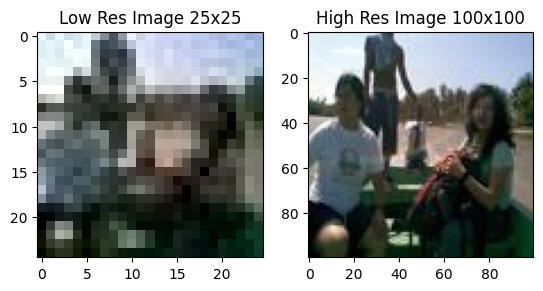

In [5]:
image_number = random.randint(0, len(lr_images)-1)
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(lr_images[image_number])
ax.set_title('Low Res Image 25x25')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(hr_images[image_number])
ax.set_title('High Res Image 100x100')
plt.show()

In [6]:

def VggNet(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

### Residual Blocks

A residual block from [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) (He et al. 2015) is a stack of layers set in such a way that the output of a layer is taken and added to another layer deeper in the block. The non-linearity is then applied after adding it together with the output of the corresponding layer in the main path.

### Batch Normalization:

This is to improve training and generalization performance. It involves normalizing the input to each layer, in a mini-batch of data, before passing it through the activation function. This has the effect of standardizing the inputs to each layer so that they have a mean of zero and standard deviation of one. By normalizing the input to each layer, batch normalization can help reduce the effects of internal covariate shift, and in turn, help speed up training and improve the performance of deep neural networks. It has become a popular technique in many state-of-the-art neural network architectures.

Specifically on internal covariance shift:

Internal covariate shift is a phenomenon that occurs during training of deep neural networks, where the distribution of the activations of each layer changes as the parameters of the previous layers are updated. This makes it difficult for the subsequent layers to learn stable representations of the input, and can slow down or prevent convergence.

Batch normalization is a technique used in deep learning to address the problem of internal covariate shift. It normalizes the input to each layer by subtracting the batch mean and dividing by the batch standard deviation. This helps to keep the distribution of the activations stable across the layers, and can help to reduce the effects of internal covariate shift. This, in turn, can speed up training and improve the performance of the network.

### Parametric ReLU (PReLU)

ReLU is one of the simplest activation functions that can be described as

\begin{align*}
    x_{\text{ReLU}} := \max(0, x),
\end{align*}

where negative values of $x$ become thresholded at $0$. However, this stops gradient through these negative values, which can hinder training. The authors of [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852) addressed this by introducing a more general ReLU by scaling negative values by some constant $a > 0$:

\begin{align*}
    x_{\text{PReLU}} := \max(0, x) + a * \min(0, x).
\end{align*}

### Upscale block

Upscale function is responsible for increasing the spatial resolution of an image.

During the training of SRGAN, low-resolution images are fed to the generator network, which then upscales the image to produce a high-resolution image. The "upscale" function is typically used as part of this process, taking a low-resolution image as input and producing a higher-resolution image as output.

In the code, the "upscale" function is used to perform upsampling interpolation, which is a common method for upscaling images. Specifically, the function takes a low-resolution image as input, and uses the "resize" function from the OpenCV library to increase the spatial resolution of the image. The resulting image is then returned as output.


### Create gen block:

This function creates and returns a generator model. The function builds a deep neural network with convolutional and upscale blocks that have been described on top, along with residual blocks that help to preserve the details of the original image during the super-resolution process. It uses techniques such as batch normalization, parametric ReLU activation, and skip connections to improve the stability and quality of the generated images. Finally, the model is compiled and returned as a Keras Model object and as same as presented in the paper.



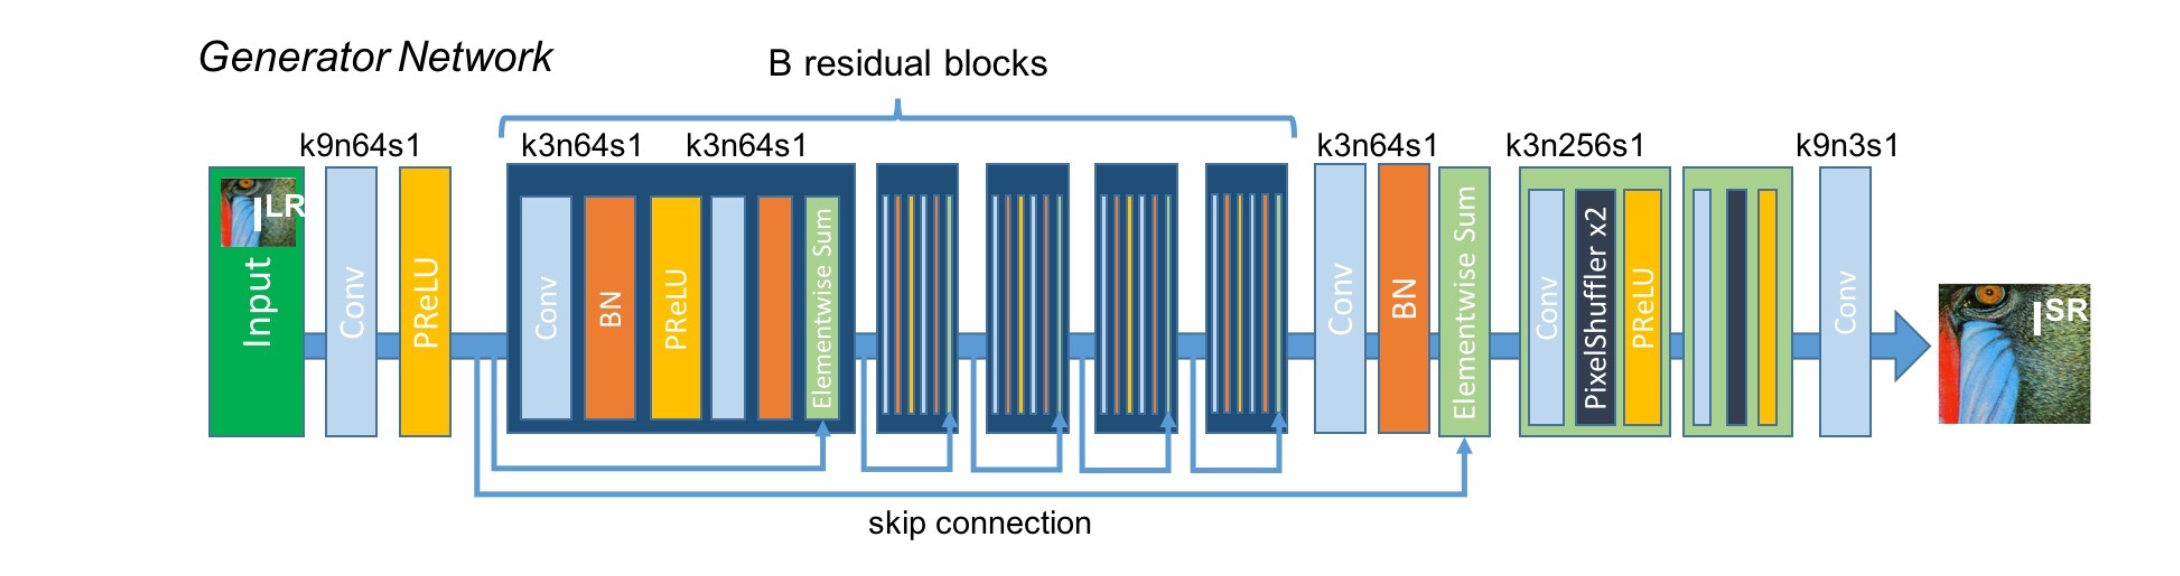




In [7]:
class SRGenerator:
    
    def __init__(self, num_res_block):
        self.num_res_block = num_res_block

    def res_block(self, ip):
        res_model = Conv2D(64, (3,3), padding = "same")(ip)
        res_model = BatchNormalization(momentum = 0.5)(res_model)
        res_model = PReLU(shared_axes = [1,2])(res_model)
        res_model = Conv2D(64, (3,3), padding = "same")(res_model)
        res_model = BatchNormalization(momentum = 0.5)(res_model)
        return add([ip,res_model])

    def upscale_block(self, ip):
        up_model = Conv2D(256, (3,3), padding="same")(ip)
        up_model = UpSampling2D(size = 2 )(up_model)
        up_model = PReLU(shared_axes=[1,2])(up_model)
        return up_model

    def create_gen(self, gen_ip):
        layers = Conv2D(64, (9,9), padding="same")(gen_ip)
        layers = PReLU(shared_axes=[1,2])(layers)
        temp = layers

        for i in range(self.num_res_block):
            layers = self.res_block(layers)

        layers = Conv2D(64, (3,3), padding="same")(layers)
        layers = BatchNormalization(momentum=0.5)(layers)
        layers = add([layers,temp])
        layers = self.upscale_block(layers)
        layers = self.upscale_block(layers)
        op = Conv2D(3, (9,9), padding="same")(layers)
        return Model(inputs=gen_ip, outputs=op)

    
    

### Discriminator Network:

In short,
The discriminator takes a low-resolution image as input and aims to distinguish between the output generated by the generator (a super-resolved image) and a high-resolution image from the dataset.

The discriminator network consists of a series of convolutional blocks that extract features from the input image. Each block comprises of a 3x3 convolutional layer followed by batch normalization and a LeakyReLU activation. The number of filters used in each block increases as we move deeper into the network.

The output of the final convolutional block is then flattened and passed through a dense layer with 16 times the number of filters used in the last convolutional block. The output of the dense layer is then passed through another LeakyReLU activation and a final dense layer with sigmoid activation, which produces a binary output indicating whether the input is real or fake (i.e. generated by the generator).

The "discriminator_block" method takes an input tensor (ip), the number of filters (filters) to be used in the convolutional layer, and the stride length (strides) for the convolution operation (default value is 1). If bn is True, a batch normalization layer is added after the convolutional layer.

The method creates a convolutional layer with a 3x3 filter and a specified number of filters (filters). If batch normalization is specified (bn=True), then batch normalization is applied to the output of the convolutional layer. The method then applies a LeakyReLU activation function with a negative slope of 0.2 to the output of the previous layer.

The create_disc method uses multiple calls to the discriminator_block method to create a larger discriminator network.


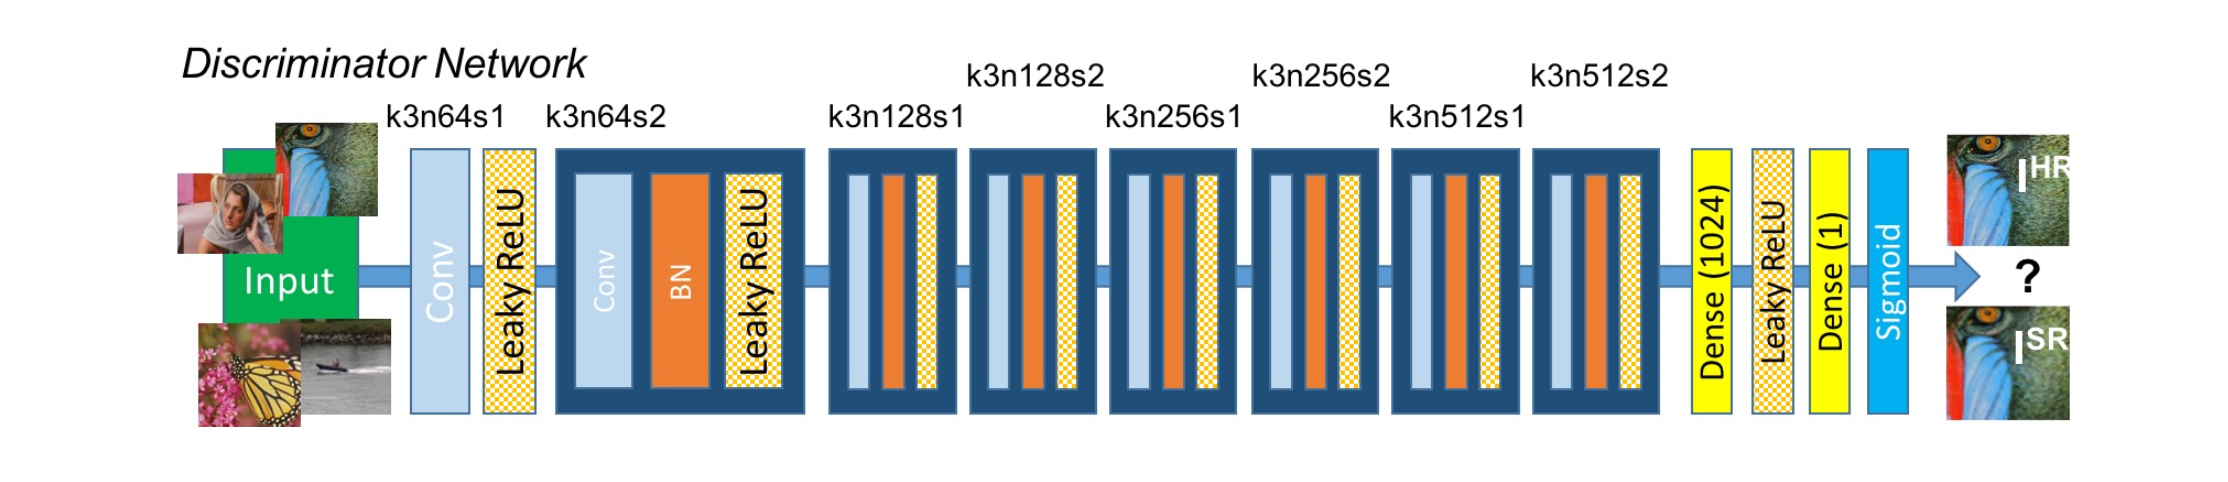


In [8]:

class SRDiscriminator:
    
    def __init__(self):
        pass

    def discriminator_block(self, ip, filters, strides=1, bn=True):
        
        disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip) 
        if bn:
            disc_model = BatchNormalization( momentum=0.8 )(disc_model)

        disc_model = LeakyReLU( alpha=0.2 )(disc_model)

        return disc_model

    
    def create_disc(self, disc_ip):
        
        df = 64

        d1 = self.discriminator_block(disc_ip, df, bn=False)
        d2 = self.discriminator_block(d1, df, strides=2)
        d3 = self.discriminator_block(d2, df*2)
        d4 = self.discriminator_block(d3, df*2, strides=2)
        d5 = self.discriminator_block(d4, df*4)
        d6 = self.discriminator_block(d5, df*4, strides=2)
        d7 = self.discriminator_block(d6, df*8)
        d8 = self.discriminator_block(d7, df*8, strides=2)
        d8_5 = Flatten()(d8)
        d9 = Dense(df*16)(d8_5)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validity = Dense(1, activation='sigmoid')(d10)

        return Model(disc_ip, validity)


### Normalizing values of images and spliting the dataset

In [9]:
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.33, random_state=42)

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])


In [10]:
#generator object declaration
generator = SRGenerator(num_res_block=16)
generator_input = Input(shape=lr_shape)
generator_model = generator.create_gen(generator_input)
generator_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 25, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 25, 25, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 25, 25, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 25, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [11]:
#Discriminator object declaration
discriminator = SRDiscriminator()
discriminator_input = Input(shape=hr_shape)
discriminator_model = discriminator.create_disc(discriminator_input)
discriminator_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 100, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 50, 50, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 50, 50, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 50, 50, 64)        0         
                                                           

### Loss functions:

1. Perceptual Loss: Perceptual loss is used to measure the difference between the high-resolution and generated images in terms of perceptual quality. It is computed as the mean squared error between the feature maps of the VGG-19 network of the high-resolution and generated images. The VGG-19 network is pre-trained on the ImageNet dataset.

\begin{align*}
    \mathcal{L} &= \mathcal{L}_{VGG} + 10^{-3}\mathcal{L}_{ADV}
\end{align*}

2. Content Loss: The content loss is used to ensure that the high-resolution image and the generated image have similar content. It is calculated as the mean squared error between the high-resolution image and the generated image.

\begin{align*}
    \mathcal{L}_{VGG} &= \left|\left|\phi_{5,4}(I^{\text{HR}}) - \phi_{5,4}(G(I^{\text{LR}}))\right|\right|_2^2
\end{align*}

where $I^{\text{HR}}$ is the original high-resolution image and $I^{\text{LR}}$ is the corresponding low-resolution image.


3. Adversarial Loss: The adversarial loss is used to ensure that the generated image is perceptually similar to the high-resolution image. It is calculated by training a discriminator network to distinguish between the high-resolution images and the generated images. The generator network is then trained to minimize the discriminator's ability to differentiate between the two images. The adversarial loss is computed as the binary cross-entropy loss between the predicted output of the discriminator network and the target output.


\begin{align*}
    \mathcal{L}_{ADV} &= \sum_{n=1}^N -\log D(G(I^{\text{LR}}))
\end{align*}

Note that $-\log D(G(\cdot))$ is used instead of $\log [1 - D(G(\cdot))]$ for better gradient behavior.

In [12]:
#vgg initiation
vgg = VggNet((100,100,3))
vgg.trainable = False

### Creating the GAN network:

In [13]:

def create_GAN(gen_model, disc_model, vgg, lr_ip, hr_ip):
    
    gen_img = gen_model(lr_ip) 
    gen_features = vgg(gen_img)
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

gan_model = create_GAN(generator_model, discriminator_model, vgg, generator_input,discriminator_input)


In [14]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")

gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 25, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 100, 100, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            30384961    ['model[0][0]']            


The epochs and batch_size variables are used to determine the number of iterations needed to complete one full epoch of training data.

Then we initialize two lists (empty), train_lr_batches and train_hr_batches, and then loops through the training data, which is in two arrays: hr_train and lr_train.

For each batch in the training data, the code extracts a slice of size batch_size from hr_train and lr_train arrays starting from the index start_idx and ending at the index end_idx. These slices are then appended to their respective lists, train_hr_batches and train_lr_batches.


In [18]:
epochs = 30
batch_size = 10  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

Within each epoch here, the program will loop through each batch of high-resolution (HR) and low-resolution (LR) images and trains the discriminator on both real and generated (fake) images. The generator is then trained on a combination of adversarial and content losses. The losses for each batch are saved to lists and are later averaged to report the progress of the training.

After each epoch, the average losses are printed, and the generator model is saved to a file. Finally, the trained generator model is saved to a file named "exp" plus the final epoch number.

In [19]:
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator_model.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator_model.trainable = True
        d_loss_gen = discriminator_model.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator_model.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator_model.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator_model.save("Generator"+ str(e+1) +".h5")

generator_model.save("exp"+ str(e) +".h5")
 

  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:05<19:11,  5.76s/it]

1/1 [==============================] - 0s 121ms/step


  1%|▌                                                        | 2/201 [00:09<15:13,  4.59s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▊                                                        | 3/201 [00:13<13:28,  4.08s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:16<12:48,  3.90s/it]

1/1 [==============================] - 0s 122ms/step


  2%|█▍                                                       | 5/201 [00:20<12:20,  3.78s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▋                                                       | 6/201 [00:23<12:02,  3.70s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:27<11:54,  3.68s/it]

1/1 [==============================] - 0s 122ms/step


  4%|██▎                                                      | 8/201 [00:30<11:42,  3.64s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▌                                                      | 9/201 [00:34<11:37,  3.63s/it]

1/1 [==============================] - 0s 119ms/step


  5%|██▊                                                     | 10/201 [00:38<11:33,  3.63s/it]

1/1 [==============================] - 0s 123ms/step


  5%|███                                                     | 11/201 [00:41<11:24,  3.60s/it]

1/1 [==============================] - 0s 125ms/step


  6%|███▎                                                    | 12/201 [00:45<11:15,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


  6%|███▌                                                    | 13/201 [00:48<11:13,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


  7%|███▉                                                    | 14/201 [00:52<11:07,  3.57s/it]

1/1 [==============================] - 0s 123ms/step


  7%|████▏                                                   | 15/201 [00:56<11:08,  3.60s/it]

1/1 [==============================] - 0s 127ms/step


  8%|████▍                                                   | 16/201 [00:59<11:11,  3.63s/it]

1/1 [==============================] - 0s 125ms/step


  8%|████▋                                                   | 17/201 [01:03<10:59,  3.58s/it]

1/1 [==============================] - 0s 123ms/step


  9%|█████                                                   | 18/201 [01:06<11:00,  3.61s/it]

1/1 [==============================] - 0s 123ms/step


  9%|█████▎                                                  | 19/201 [01:10<10:52,  3.59s/it]

1/1 [==============================] - 0s 124ms/step


 10%|█████▌                                                  | 20/201 [01:14<11:03,  3.66s/it]

1/1 [==============================] - 0s 142ms/step


 10%|█████▊                                                  | 21/201 [01:18<11:26,  3.81s/it]

1/1 [==============================] - 0s 124ms/step


 11%|██████▏                                                 | 22/201 [01:22<11:11,  3.75s/it]

1/1 [==============================] - 0s 122ms/step


 11%|██████▍                                                 | 23/201 [01:25<11:00,  3.71s/it]

1/1 [==============================] - 0s 124ms/step


 12%|██████▋                                                 | 24/201 [01:29<10:54,  3.70s/it]

1/1 [==============================] - 0s 123ms/step


 12%|██████▉                                                 | 25/201 [01:32<10:47,  3.68s/it]

1/1 [==============================] - 0s 124ms/step


 13%|███████▏                                                | 26/201 [01:36<10:39,  3.66s/it]

1/1 [==============================] - 0s 123ms/step


 13%|███████▌                                                | 27/201 [01:40<10:37,  3.66s/it]

1/1 [==============================] - 0s 124ms/step


 14%|███████▊                                                | 28/201 [01:43<10:34,  3.67s/it]

1/1 [==============================] - 0s 124ms/step


 14%|████████                                                | 29/201 [01:47<10:28,  3.65s/it]

1/1 [==============================] - 0s 123ms/step


 15%|████████▎                                               | 30/201 [01:51<10:27,  3.67s/it]

1/1 [==============================] - 0s 122ms/step


 15%|████████▋                                               | 31/201 [01:54<10:15,  3.62s/it]

1/1 [==============================] - 0s 121ms/step


 16%|████████▉                                               | 32/201 [01:58<10:15,  3.64s/it]

1/1 [==============================] - 0s 122ms/step


 16%|█████████▏                                              | 33/201 [02:01<09:46,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▍                                              | 34/201 [02:04<09:38,  3.46s/it]

1/1 [==============================] - 0s 122ms/step


 17%|█████████▊                                              | 35/201 [02:08<09:42,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████                                              | 36/201 [02:12<09:48,  3.57s/it]

1/1 [==============================] - 0s 123ms/step


 18%|██████████▎                                             | 37/201 [02:15<09:36,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▌                                             | 38/201 [02:18<09:20,  3.44s/it]

1/1 [==============================] - 0s 122ms/step


 19%|██████████▊                                             | 39/201 [02:22<09:02,  3.35s/it]

1/1 [==============================] - 0s 122ms/step


 20%|███████████▏                                            | 40/201 [02:25<08:47,  3.28s/it]

1/1 [==============================] - 0s 122ms/step


 20%|███████████▍                                            | 41/201 [02:28<08:36,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▋                                            | 42/201 [02:31<08:51,  3.34s/it]

1/1 [==============================] - 0s 123ms/step


 21%|███████████▉                                            | 43/201 [02:35<09:03,  3.44s/it]

1/1 [==============================] - 0s 123ms/step


 22%|████████████▎                                           | 44/201 [02:39<09:07,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▌                                           | 45/201 [02:42<09:11,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 23%|████████████▊                                           | 46/201 [02:46<09:08,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 23%|█████████████                                           | 47/201 [02:49<08:59,  3.50s/it]

1/1 [==============================] - 0s 122ms/step


 24%|█████████████▎                                          | 48/201 [02:53<09:00,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 24%|█████████████▋                                          | 49/201 [02:56<08:58,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 25%|█████████████▉                                          | 50/201 [03:00<08:49,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 25%|██████████████▏                                         | 51/201 [03:03<08:39,  3.46s/it]

1/1 [==============================] - 0s 132ms/step


 26%|██████████████▍                                         | 52/201 [03:07<08:43,  3.51s/it]

1/1 [==============================] - 0s 123ms/step


 26%|██████████████▊                                         | 53/201 [03:11<08:56,  3.62s/it]

1/1 [==============================] - 0s 123ms/step


 27%|███████████████                                         | 54/201 [03:14<08:54,  3.63s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████▎                                        | 55/201 [03:18<08:47,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▌                                        | 56/201 [03:22<08:42,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▉                                        | 57/201 [03:25<08:39,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▏                                       | 58/201 [03:28<08:16,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▍                                       | 59/201 [03:32<08:13,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 30%|████████████████▋                                       | 60/201 [03:35<08:17,  3.53s/it]

1/1 [==============================] - 0s 133ms/step


 30%|████████████████▉                                       | 61/201 [03:39<08:24,  3.61s/it]

1/1 [==============================] - 0s 136ms/step


 31%|█████████████████▎                                      | 62/201 [03:43<08:31,  3.68s/it]

1/1 [==============================] - 0s 121ms/step


 31%|█████████████████▌                                      | 63/201 [03:47<08:26,  3.67s/it]

1/1 [==============================] - 0s 122ms/step


 32%|█████████████████▊                                      | 64/201 [03:50<08:09,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 32%|██████████████████                                      | 65/201 [03:54<08:09,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▍                                     | 66/201 [03:57<07:58,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▋                                     | 67/201 [04:01<07:59,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 34%|██████████████████▉                                     | 68/201 [04:04<07:58,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 34%|███████████████████▏                                    | 69/201 [04:08<07:53,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 35%|███████████████████▌                                    | 70/201 [04:11<07:44,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▊                                    | 71/201 [04:15<07:32,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████                                    | 72/201 [04:18<07:14,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████▎                                   | 73/201 [04:21<07:00,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▌                                   | 74/201 [04:24<06:49,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▉                                   | 75/201 [04:27<06:40,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▏                                  | 76/201 [04:30<06:34,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▍                                  | 77/201 [04:34<06:42,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 39%|█████████████████████▋                                  | 78/201 [04:37<06:55,  3.38s/it]

1/1 [==============================] - 0s 124ms/step


 39%|██████████████████████                                  | 79/201 [04:41<07:01,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▎                                 | 80/201 [04:45<07:00,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


 40%|██████████████████████▌                                 | 81/201 [04:48<06:50,  3.42s/it]

1/1 [==============================] - 0s 119ms/step


 41%|██████████████████████▊                                 | 82/201 [04:51<06:45,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 41%|███████████████████████                                 | 83/201 [04:54<06:30,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▍                                | 84/201 [04:58<06:36,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▋                                | 85/201 [05:01<06:39,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 43%|███████████████████████▉                                | 86/201 [05:05<06:41,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 43%|████████████████████████▏                               | 87/201 [05:09<06:43,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▌                               | 88/201 [05:12<06:39,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▊                               | 89/201 [05:15<06:21,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████                               | 90/201 [05:18<06:07,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████▎                              | 91/201 [05:22<06:09,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▋                              | 92/201 [05:25<05:58,  3.29s/it]

1/1 [==============================] - 0s 124ms/step


 46%|█████████████████████████▉                              | 93/201 [05:28<06:02,  3.35s/it]

1/1 [==============================] - 0s 119ms/step


 47%|██████████████████████████▏                             | 94/201 [05:32<05:49,  3.26s/it]

1/1 [==============================] - 0s 119ms/step


 47%|██████████████████████████▍                             | 95/201 [05:35<05:50,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 48%|██████████████████████████▋                             | 96/201 [05:38<05:47,  3.30s/it]

1/1 [==============================] - 0s 119ms/step


 48%|███████████████████████████                             | 97/201 [05:41<05:36,  3.24s/it]

1/1 [==============================] - 0s 119ms/step


 49%|███████████████████████████▎                            | 98/201 [05:44<05:28,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▌                            | 99/201 [05:48<05:22,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▎                           | 100/201 [05:51<05:16,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▋                           | 101/201 [05:54<05:11,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 51%|███████████████████████████▉                           | 102/201 [05:57<05:07,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 51%|████████████████████████████▏                          | 103/201 [06:00<05:09,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▍                          | 104/201 [06:03<05:13,  3.24s/it]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████▋                          | 105/201 [06:07<05:06,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████                          | 106/201 [06:10<05:00,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:13<04:55,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:16<04:50,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:19<04:45,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████                         | 110/201 [06:22<04:42,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:25<04:47,  3.19s/it]

1/1 [==============================] - 0s 122ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:29<04:49,  3.26s/it]

1/1 [==============================] - 0s 122ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:32<04:42,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:35<04:36,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:38<04:39,  3.25s/it]

1/1 [==============================] - 0s 124ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:42<04:46,  3.38s/it]

1/1 [==============================] - 0s 123ms/step


 58%|████████████████████████████████                       | 117/201 [06:45<04:37,  3.30s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:49<04:39,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:52<04:37,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:55<04:27,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [06:58<04:18,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


 61%|█████████████████████████████████▍                     | 122/201 [07:02<04:15,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:05<04:18,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:08<04:10,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:11<04:04,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:14<03:58,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:17<03:52,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████                    | 128/201 [07:21<03:55,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:24<03:57,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:27<03:50,  3.24s/it]

1/1 [==============================] - 0s 119ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:31<03:44,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████                   | 132/201 [07:34<03:38,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:37<03:41,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:40<03:40,  3.29s/it]

1/1 [==============================] - 0s 119ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:44<03:33,  3.24s/it]

1/1 [==============================] - 0s 119ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:47<03:27,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:50<03:25,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:54<03:29,  3.33s/it]

1/1 [==============================] - 0s 122ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:57<03:30,  3.39s/it]

1/1 [==============================] - 0s 119ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:01<03:29,  3.43s/it]

1/1 [==============================] - 0s 123ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:04<03:22,  3.38s/it]

1/1 [==============================] - 0s 122ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:07<03:14,  3.30s/it]

1/1 [==============================] - 0s 119ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:10<03:08,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:13<03:02,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:17<03:03,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:20<03:05,  3.37s/it]

1/1 [==============================] - 0s 122ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:23<02:57,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:27<02:57,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:30<02:54,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:33<02:47,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:36<02:40,  3.22s/it]

1/1 [==============================] - 0s 122ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:40<02:43,  3.34s/it]

1/1 [==============================] - 0s 122ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:44<02:43,  3.41s/it]

1/1 [==============================] - 0s 122ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:47<02:43,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:51<02:40,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:54<02:37,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:58<02:34,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:01<02:29,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:05<02:27,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:08<02:25,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:12<02:22,  3.55s/it]

1/1 [==============================] - 0s 123ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:15<02:17,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:19<02:14,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:22<02:10,  3.52s/it]

1/1 [==============================] - 0s 122ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:26<02:07,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:29<02:02,  3.51s/it]

1/1 [==============================] - 0s 119ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:33<02:00,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:37<01:57,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:40<01:53,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:44<01:50,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:47<01:47,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:51<01:43,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:55<01:40,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:58<01:36,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [10:02<01:33,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:05<01:29,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:09<01:25,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:12<01:21,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:16<01:18,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:20<01:15,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:23<01:11,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:27<01:08,  3.61s/it]

1/1 [==============================] - 0s 122ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:30<01:04,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:34<01:01,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:38<00:57,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:41<00:53,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:45<00:50,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:48<00:46,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:52<00:43,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:55<00:39,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:59<00:35,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [11:03<00:31,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [11:06<00:28,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:10<00:24,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:13<00:21,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:17<00:17,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:20<00:14,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:24<00:10,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:28<00:07,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:31<00:03,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:35<00:00,  3.46s/it]


epoch: 1 g_loss: 58.21865607494146 d_loss: [0.06480355 0.98656716]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<12:03,  3.62s/it]

1/1 [==============================] - 0s 118ms/step


  1%|▌                                                        | 2/201 [00:07<11:46,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


  1%|▊                                                        | 3/201 [00:10<11:44,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▏                                                       | 4/201 [00:14<11:38,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:17<11:42,  3.58s/it]

1/1 [==============================] - 0s 123ms/step


  3%|█▋                                                       | 6/201 [00:21<11:56,  3.67s/it]

1/1 [==============================] - 0s 143ms/step


  3%|█▉                                                       | 7/201 [00:25<12:09,  3.76s/it]

1/1 [==============================] - 0s 125ms/step


  4%|██▎                                                      | 8/201 [00:29<12:10,  3.78s/it]

1/1 [==============================] - 0s 122ms/step


  4%|██▌                                                      | 9/201 [00:32<11:28,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


  5%|██▊                                                     | 10/201 [00:35<10:54,  3.43s/it]

1/1 [==============================] - 0s 122ms/step


  5%|███                                                     | 11/201 [00:38<10:31,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


  6%|███▎                                                    | 12/201 [00:41<10:15,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


  6%|███▌                                                    | 13/201 [00:45<10:03,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


  7%|███▉                                                    | 14/201 [00:48<09:55,  3.18s/it]

1/1 [==============================] - 0s 122ms/step


  7%|████▏                                                   | 15/201 [00:51<09:48,  3.17s/it]

1/1 [==============================] - 0s 123ms/step


  8%|████▍                                                   | 16/201 [00:54<09:42,  3.15s/it]

1/1 [==============================] - 0s 122ms/step


  8%|████▋                                                   | 17/201 [00:57<09:36,  3.13s/it]

1/1 [==============================] - 0s 122ms/step


  9%|█████                                                   | 18/201 [01:00<09:30,  3.12s/it]

1/1 [==============================] - 0s 122ms/step


  9%|█████▎                                                  | 19/201 [01:04<09:51,  3.25s/it]

1/1 [==============================] - 0s 125ms/step


 10%|█████▌                                                  | 20/201 [01:07<10:08,  3.36s/it]

1/1 [==============================] - 0s 123ms/step


 10%|█████▊                                                  | 21/201 [01:11<10:18,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▏                                                 | 22/201 [01:14<10:26,  3.50s/it]

1/1 [==============================] - 0s 125ms/step


 11%|██████▍                                                 | 23/201 [01:18<10:41,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 12%|██████▋                                                 | 24/201 [01:22<10:46,  3.65s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▉                                                 | 25/201 [01:25<10:11,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▏                                                | 26/201 [01:28<09:46,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▌                                                | 27/201 [01:31<09:27,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 14%|███████▊                                                | 28/201 [01:34<09:14,  3.20s/it]

1/1 [==============================] - 0s 122ms/step


 14%|████████                                                | 29/201 [01:37<09:03,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▎                                               | 30/201 [01:40<08:57,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▋                                               | 31/201 [01:44<08:52,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 16%|████████▉                                               | 32/201 [01:47<08:49,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 16%|█████████▏                                              | 33/201 [01:50<08:43,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▍                                              | 34/201 [01:53<08:38,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▊                                              | 35/201 [01:56<08:34,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 18%|██████████                                              | 36/201 [01:59<08:29,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████▎                                             | 37/201 [02:02<08:25,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▌                                             | 38/201 [02:05<08:23,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▊                                             | 39/201 [02:08<08:20,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▏                                            | 40/201 [02:11<08:16,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▍                                            | 41/201 [02:14<08:12,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▋                                            | 42/201 [02:17<08:08,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▉                                            | 43/201 [02:21<08:05,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▎                                           | 44/201 [02:24<08:02,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▌                                           | 45/201 [02:27<07:59,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 23%|████████████▊                                           | 46/201 [02:30<07:57,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:33<07:55,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 24%|█████████████▎                                          | 48/201 [02:36<07:52,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:39<07:49,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 25%|█████████████▉                                          | 50/201 [02:42<07:47,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 25%|██████████████▏                                         | 51/201 [02:45<07:44,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██████████████▍                                         | 52/201 [02:48<07:40,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██████████████▊                                         | 53/201 [02:51<07:37,  3.09s/it]

1/1 [==============================] - 0s 123ms/step


 27%|███████████████                                         | 54/201 [02:55<07:33,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████▎                                        | 55/201 [02:58<07:29,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▌                                        | 56/201 [03:01<07:26,  3.08s/it]

1/1 [==============================] - 0s 124ms/step


 28%|███████████████▉                                        | 57/201 [03:04<07:26,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▏                                       | 58/201 [03:07<07:22,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▍                                       | 59/201 [03:10<07:19,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:13<07:15,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 30%|████████████████▉                                       | 61/201 [03:16<07:11,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 31%|█████████████████▎                                      | 62/201 [03:19<07:08,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▌                                      | 63/201 [03:22<07:05,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████▊                                      | 64/201 [03:25<07:01,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 32%|██████████████████                                      | 65/201 [03:28<06:57,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 33%|██████████████████▍                                     | 66/201 [03:32<06:54,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▋                                     | 67/201 [03:35<06:53,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 34%|██████████████████▉                                     | 68/201 [03:38<06:50,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 34%|███████████████████▏                                    | 69/201 [03:41<06:47,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 35%|███████████████████▌                                    | 70/201 [03:44<06:44,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 35%|███████████████████▊                                    | 71/201 [03:47<06:41,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 36%|████████████████████                                    | 72/201 [03:50<06:38,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████▎                                   | 73/201 [03:53<06:34,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▌                                   | 74/201 [03:56<06:32,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 37%|████████████████████▉                                   | 75/201 [03:59<06:29,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▏                                  | 76/201 [04:02<06:25,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▍                                  | 77/201 [04:06<06:22,  3.08s/it]

1/1 [==============================] - 0s 122ms/step


 39%|█████████████████████▋                                  | 78/201 [04:09<06:19,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:12<06:15,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▎                                 | 80/201 [04:15<06:12,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 40%|██████████████████████▌                                 | 81/201 [04:18<06:09,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 41%|██████████████████████▊                                 | 82/201 [04:21<06:07,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 41%|███████████████████████                                 | 83/201 [04:24<06:04,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▍                                | 84/201 [04:27<06:01,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▋                                | 85/201 [04:30<05:57,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 43%|███████████████████████▉                                | 86/201 [04:33<05:54,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [04:36<05:51,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 44%|████████████████████████▌                               | 88/201 [04:39<05:48,  3.09s/it]

1/1 [==============================] - 0s 124ms/step


 44%|████████████████████████▊                               | 89/201 [04:43<05:46,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 45%|█████████████████████████                               | 90/201 [04:46<05:42,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████▎                              | 91/201 [04:49<05:38,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▋                              | 92/201 [04:52<05:35,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▉                              | 93/201 [04:55<05:32,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [04:58<05:29,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▍                             | 95/201 [05:01<05:26,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 48%|██████████████████████████▋                             | 96/201 [05:04<05:24,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 48%|███████████████████████████                             | 97/201 [05:07<05:21,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▎                            | 98/201 [05:10<05:18,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▌                            | 99/201 [05:13<05:15,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 50%|███████████████████████████▎                           | 100/201 [05:17<05:12,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▋                           | 101/201 [05:20<05:08,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 51%|███████████████████████████▉                           | 102/201 [05:23<05:05,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 51%|████████████████████████████▏                          | 103/201 [05:26<05:02,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▍                          | 104/201 [05:29<04:59,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████▋                          | 105/201 [05:32<04:56,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [05:35<04:52,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████▎                         | 107/201 [05:38<04:49,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▌                         | 108/201 [05:41<04:46,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▊                         | 109/201 [05:44<04:43,  3.08s/it]

1/1 [==============================] - 0s 122ms/step


 55%|██████████████████████████████                         | 110/201 [05:47<04:40,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████▎                        | 111/201 [05:50<04:37,  3.08s/it]

1/1 [==============================] - 0s 123ms/step


 56%|██████████████████████████████▋                        | 112/201 [05:54<04:34,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▉                        | 113/201 [05:57<04:31,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:00<04:27,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:03<04:25,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:06<04:22,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 58%|████████████████████████████████                       | 117/201 [06:09<04:18,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:12<04:15,  3.08s/it]

1/1 [==============================] - 0s 122ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:15<04:12,  3.08s/it]

1/1 [==============================] - 0s 122ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:18<04:09,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [06:21<04:06,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:24<04:03,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:27<04:00,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:30<03:57,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 62%|██████████████████████████████████▏                    | 125/201 [06:34<03:54,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▍                    | 126/201 [06:37<03:50,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 63%|██████████████████████████████████▊                    | 127/201 [06:40<03:47,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████                    | 128/201 [06:43<03:44,  3.07s/it]

1/1 [==============================] - 0s 122ms/step


 64%|███████████████████████████████████▎                   | 129/201 [06:46<03:41,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▌                   | 130/201 [06:49<03:39,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▊                   | 131/201 [06:52<03:36,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 66%|████████████████████████████████████                   | 132/201 [06:55<03:33,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [06:58<03:29,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:01<03:26,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:04<03:23,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:07<03:20,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:11<03:16,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:14<03:13,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:17<03:10,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:20<03:07,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:23<03:03,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:26<03:00,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [07:29<02:57,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▍               | 144/201 [07:32<02:54,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▋               | 145/201 [07:35<02:51,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 73%|███████████████████████████████████████▉               | 146/201 [07:38<02:48,  3.06s/it]

1/1 [==============================] - 0s 119ms/step


 73%|████████████████████████████████████████▏              | 147/201 [07:41<02:45,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▍              | 148/201 [07:44<02:42,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▊              | 149/201 [07:47<02:39,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████              | 150/201 [07:50<02:37,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [07:54<02:35,  3.11s/it]

1/1 [==============================] - 0s 122ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [07:57<02:34,  3.15s/it]

1/1 [==============================] - 0s 122ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:00<02:30,  3.13s/it]

1/1 [==============================] - 0s 122ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:03<02:26,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:06<02:22,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:09<02:19,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:12<02:15,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:15<02:12,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:18<02:10,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:22<02:07,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [08:25<02:03,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [08:28<02:00,  3.09s/it]

1/1 [==============================] - 0s 123ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [08:31<01:57,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [08:34<01:53,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [08:37<01:50,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [08:40<01:47,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [08:43<01:44,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [08:46<01:41,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [08:49<01:38,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [08:52<01:35,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [08:55<01:32,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 86%|███████████████████████████████████████████████        | 172/201 [08:58<01:29,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:02<01:26,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:05<01:23,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:08<01:20,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:11<01:16,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:14<01:13,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:17<01:10,  3.07s/it]

1/1 [==============================] - 0s 122ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [09:20<01:07,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [09:23<01:04,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [09:26<01:01,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [09:29<00:58,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [09:32<00:55,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [09:35<00:52,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [09:38<00:49,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [09:42<00:46,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [09:45<00:43,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [09:48<00:39,  3.08s/it]

1/1 [==============================] - 0s 122ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [09:51<00:36,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [09:54<00:33,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [09:57<00:30,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:00<00:27,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:03<00:25,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:07<00:22,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:10<00:19,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [10:13<00:15,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [10:16<00:12,  3.13s/it]

1/1 [==============================] - 0s 122ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [10:19<00:09,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [10:22<00:06,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [10:25<00:03,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [10:28<00:00,  3.13s/it]


epoch: 2 g_loss: 55.58297666862829 d_loss: [0.02571002 0.99154229]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<10:15,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


  1%|▌                                                        | 2/201 [00:06<10:11,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:09<10:08,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:12<10:06,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


  2%|█▍                                                       | 5/201 [00:15<10:03,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▋                                                       | 6/201 [00:18<10:00,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:21<09:56,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▎                                                      | 8/201 [00:24<09:54,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▌                                                      | 9/201 [00:27<09:52,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:31<10:20,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


  5%|███                                                     | 11/201 [00:35<10:41,  3.38s/it]

1/1 [==============================] - 0s 123ms/step


  6%|███▎                                                    | 12/201 [00:38<10:49,  3.44s/it]

1/1 [==============================] - 0s 131ms/step


  6%|███▌                                                    | 13/201 [00:42<11:11,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


  7%|███▉                                                    | 14/201 [00:45<11:05,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


  7%|████▏                                                   | 15/201 [00:49<11:03,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▍                                                   | 16/201 [00:53<11:00,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▋                                                   | 17/201 [00:56<10:31,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████                                                   | 18/201 [00:59<10:08,  3.33s/it]

1/1 [==============================] - 0s 122ms/step


  9%|█████▎                                                  | 19/201 [01:02<09:52,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▌                                                  | 20/201 [01:05<09:39,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▊                                                  | 21/201 [01:08<09:41,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▏                                                 | 22/201 [01:12<09:59,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▍                                                 | 23/201 [01:15<09:48,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:18<09:32,  3.24s/it]

1/1 [==============================] - 0s 122ms/step


 12%|██████▉                                                 | 25/201 [01:22<09:42,  3.31s/it]

1/1 [==============================] - 0s 123ms/step


 13%|███████▏                                                | 26/201 [01:25<09:59,  3.42s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:29<10:01,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 14%|███████▊                                                | 28/201 [01:32<10:03,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 14%|████████                                                | 29/201 [01:36<10:04,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 15%|████████▎                                               | 30/201 [01:40<10:09,  3.56s/it]

1/1 [==============================] - 0s 131ms/step


 15%|████████▋                                               | 31/201 [01:43<10:14,  3.61s/it]

1/1 [==============================] - 0s 123ms/step


 16%|████████▉                                               | 32/201 [01:47<10:22,  3.68s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█████████▏                                              | 33/201 [01:51<10:22,  3.71s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▍                                              | 34/201 [01:55<10:23,  3.74s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▊                                              | 35/201 [01:59<10:21,  3.74s/it]

1/1 [==============================] - 0s 140ms/step


 18%|██████████                                              | 36/201 [02:02<10:16,  3.74s/it]

1/1 [==============================] - 0s 138ms/step


 18%|██████████▎                                             | 37/201 [02:06<10:13,  3.74s/it]

1/1 [==============================] - 0s 124ms/step


 19%|██████████▌                                             | 38/201 [02:10<10:09,  3.74s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▊                                             | 39/201 [02:13<09:34,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 20%|███████████▏                                            | 40/201 [02:16<09:07,  3.40s/it]

1/1 [==============================] - 0s 123ms/step


 20%|███████████▍                                            | 41/201 [02:19<08:50,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▋                                            | 42/201 [02:22<08:35,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▉                                            | 43/201 [02:25<08:23,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▎                                           | 44/201 [02:28<08:15,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▌                                           | 45/201 [02:31<08:11,  3.15s/it]

1/1 [==============================] - 0s 138ms/step


 23%|████████████▊                                           | 46/201 [02:35<08:32,  3.30s/it]

1/1 [==============================] - 0s 152ms/step


 23%|█████████████                                           | 47/201 [02:39<09:00,  3.51s/it]

1/1 [==============================] - 0s 123ms/step


 24%|█████████████▎                                          | 48/201 [02:43<08:57,  3.51s/it]

1/1 [==============================] - 0s 150ms/step


 24%|█████████████▋                                          | 49/201 [02:46<08:55,  3.52s/it]

1/1 [==============================] - 0s 130ms/step


 25%|█████████████▉                                          | 50/201 [02:50<08:45,  3.48s/it]

1/1 [==============================] - 0s 149ms/step


 25%|██████████████▏                                         | 51/201 [02:53<08:43,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [02:56<08:34,  3.46s/it]

1/1 [==============================] - 0s 150ms/step


 26%|██████████████▊                                         | 53/201 [03:00<08:25,  3.42s/it]

1/1 [==============================] - 0s 150ms/step


 27%|███████████████                                         | 54/201 [03:03<08:24,  3.43s/it]

1/1 [==============================] - 0s 152ms/step


 27%|███████████████▎                                        | 55/201 [03:07<08:21,  3.43s/it]

1/1 [==============================] - 0s 150ms/step


 28%|███████████████▌                                        | 56/201 [03:10<08:20,  3.45s/it]

1/1 [==============================] - 0s 151ms/step


 28%|███████████████▉                                        | 57/201 [03:14<08:16,  3.45s/it]

1/1 [==============================] - 0s 150ms/step


 29%|████████████████▏                                       | 58/201 [03:17<08:14,  3.46s/it]

1/1 [==============================] - 0s 123ms/step


 29%|████████████████▍                                       | 59/201 [03:21<08:10,  3.45s/it]

1/1 [==============================] - 0s 150ms/step


 30%|████████████████▋                                       | 60/201 [03:24<08:10,  3.48s/it]

1/1 [==============================] - 0s 129ms/step


 30%|████████████████▉                                       | 61/201 [03:27<08:01,  3.44s/it]

1/1 [==============================] - 0s 151ms/step


 31%|█████████████████▎                                      | 62/201 [03:31<08:01,  3.46s/it]

1/1 [==============================] - 0s 140ms/step


 31%|█████████████████▌                                      | 63/201 [03:34<07:54,  3.44s/it]

1/1 [==============================] - 0s 150ms/step


 32%|█████████████████▊                                      | 64/201 [03:38<07:56,  3.48s/it]

1/1 [==============================] - 0s 119ms/step


 32%|██████████████████                                      | 65/201 [03:41<07:44,  3.41s/it]

1/1 [==============================] - 0s 150ms/step


 33%|██████████████████▍                                     | 66/201 [03:45<07:47,  3.46s/it]

1/1 [==============================] - 0s 150ms/step


 33%|██████████████████▋                                     | 67/201 [03:48<07:43,  3.46s/it]

1/1 [==============================] - 0s 150ms/step


 34%|██████████████████▉                                     | 68/201 [03:52<07:41,  3.47s/it]

1/1 [==============================] - 0s 150ms/step


 34%|███████████████████▏                                    | 69/201 [03:55<07:39,  3.48s/it]

1/1 [==============================] - 0s 149ms/step


 35%|███████████████████▌                                    | 70/201 [03:59<07:33,  3.46s/it]

1/1 [==============================] - 0s 153ms/step


 35%|███████████████████▊                                    | 71/201 [04:02<07:33,  3.49s/it]

1/1 [==============================] - 0s 150ms/step


 36%|████████████████████                                    | 72/201 [04:06<07:25,  3.45s/it]

1/1 [==============================] - 0s 150ms/step


 36%|████████████████████▎                                   | 73/201 [04:09<07:33,  3.55s/it]

1/1 [==============================] - 0s 144ms/step


 37%|████████████████████▌                                   | 74/201 [04:13<07:35,  3.59s/it]

1/1 [==============================] - 0s 149ms/step


 37%|████████████████████▉                                   | 75/201 [04:17<07:31,  3.59s/it]

1/1 [==============================] - 0s 123ms/step


 38%|█████████████████████▏                                  | 76/201 [04:20<07:27,  3.58s/it]

1/1 [==============================] - 0s 148ms/step


 38%|█████████████████████▍                                  | 77/201 [04:24<07:17,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 39%|█████████████████████▋                                  | 78/201 [04:27<07:07,  3.47s/it]

1/1 [==============================] - 0s 125ms/step


 39%|██████████████████████                                  | 79/201 [04:30<07:05,  3.49s/it]

1/1 [==============================] - 0s 149ms/step


 40%|██████████████████████▎                                 | 80/201 [04:34<06:59,  3.46s/it]

1/1 [==============================] - 0s 131ms/step


 40%|██████████████████████▌                                 | 81/201 [04:38<07:15,  3.63s/it]

1/1 [==============================] - 0s 151ms/step


 41%|██████████████████████▊                                 | 82/201 [04:42<07:20,  3.70s/it]

1/1 [==============================] - 0s 151ms/step


 41%|███████████████████████                                 | 83/201 [04:45<07:13,  3.67s/it]

1/1 [==============================] - 0s 149ms/step


 42%|███████████████████████▍                                | 84/201 [04:49<07:06,  3.65s/it]

1/1 [==============================] - 0s 133ms/step


 42%|███████████████████████▋                                | 85/201 [04:53<07:15,  3.75s/it]

1/1 [==============================] - 0s 122ms/step


 43%|███████████████████████▉                                | 86/201 [04:56<07:02,  3.67s/it]

1/1 [==============================] - 0s 150ms/step


 43%|████████████████████████▏                               | 87/201 [05:00<07:02,  3.70s/it]

1/1 [==============================] - 0s 127ms/step


 44%|████████████████████████▌                               | 88/201 [05:04<07:00,  3.72s/it]

1/1 [==============================] - 0s 150ms/step


 44%|████████████████████████▊                               | 89/201 [05:08<07:04,  3.79s/it]

1/1 [==============================] - 0s 152ms/step


 45%|█████████████████████████                               | 90/201 [05:11<06:49,  3.69s/it]

1/1 [==============================] - 0s 143ms/step


 45%|█████████████████████████▎                              | 91/201 [05:15<06:40,  3.64s/it]

1/1 [==============================] - 0s 149ms/step


 46%|█████████████████████████▋                              | 92/201 [05:18<06:22,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [05:21<06:04,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▏                             | 94/201 [05:24<05:51,  3.29s/it]

1/1 [==============================] - 0s 123ms/step


 47%|██████████████████████████▍                             | 95/201 [05:27<05:41,  3.23s/it]

1/1 [==============================] - 0s 122ms/step


 48%|██████████████████████████▋                             | 96/201 [05:30<05:34,  3.19s/it]

1/1 [==============================] - 0s 122ms/step


 48%|███████████████████████████                             | 97/201 [05:33<05:29,  3.16s/it]

1/1 [==============================] - 0s 124ms/step


 49%|███████████████████████████▎                            | 98/201 [05:37<05:24,  3.15s/it]

1/1 [==============================] - 0s 123ms/step


 49%|███████████████████████████▌                            | 99/201 [05:40<05:20,  3.14s/it]

1/1 [==============================] - 0s 122ms/step


 50%|███████████████████████████▎                           | 100/201 [05:43<05:15,  3.13s/it]

1/1 [==============================] - 0s 122ms/step


 50%|███████████████████████████▋                           | 101/201 [05:46<05:11,  3.12s/it]

1/1 [==============================] - 0s 122ms/step


 51%|███████████████████████████▉                           | 102/201 [05:49<05:07,  3.10s/it]

1/1 [==============================] - 0s 123ms/step


 51%|████████████████████████████▏                          | 103/201 [05:52<05:03,  3.10s/it]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████▍                          | 104/201 [05:55<05:00,  3.10s/it]

1/1 [==============================] - 0s 123ms/step


 52%|████████████████████████████▋                          | 105/201 [05:58<04:57,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [06:01<04:54,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:04<04:50,  3.10s/it]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:08<04:47,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:11<04:44,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████                         | 110/201 [06:14<04:41,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:17<04:38,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:20<04:34,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:23<04:31,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:26<04:28,  3.08s/it]

1/1 [==============================] - 0s 122ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:29<04:25,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:32<04:22,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 58%|████████████████████████████████                       | 117/201 [06:36<04:24,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:39<04:20,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:42<04:15,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:45<04:11,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [06:48<04:07,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:51<04:03,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:54<04:00,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:57<03:56,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:00<03:53,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:03<03:50,  3.08s/it]

1/1 [==============================] - 0s 131ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:06<03:47,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████                    | 128/201 [07:09<03:44,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:12<03:41,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:15<03:37,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:19<03:34,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████                   | 132/201 [07:22<03:31,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:25<03:28,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:28<03:25,  3.06s/it]

1/1 [==============================] - 0s 122ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:31<03:22,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:34<03:19,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:37<03:16,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:40<03:13,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:43<03:09,  3.06s/it]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:46<03:07,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:49<03:04,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:52<03:01,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [07:55<02:58,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▍               | 144/201 [07:58<02:54,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:01<02:51,  3.06s/it]

1/1 [==============================] - 0s 121ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:05<02:48,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:08<02:45,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:11<02:42,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:14<02:39,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:17<02:36,  3.07s/it]

1/1 [==============================] - 0s 122ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:20<02:33,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:23<02:30,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:26<02:27,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:29<02:24,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:32<02:21,  3.08s/it]

1/1 [==============================] - 0s 122ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:35<02:19,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:38<02:15,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:42<02:12,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:45<02:09,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:48<02:06,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [08:51<02:02,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [08:54<01:59,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [08:57<01:56,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:00<01:53,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:03<01:50,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:06<01:47,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:09<01:44,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:12<01:41,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:15<01:38,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:18<01:35,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:21<01:32,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:24<01:29,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:28<01:26,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:31<01:22,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:34<01:19,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:37<01:16,  3.06s/it]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:40<01:13,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:43<01:10,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [09:46<01:07,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [09:49<01:04,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [09:52<01:01,  3.06s/it]

1/1 [==============================] - 0s 122ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [09:55<00:58,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [09:58<00:55,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:01<00:52,  3.06s/it]

1/1 [==============================] - 0s 119ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:04<00:49,  3.06s/it]

1/1 [==============================] - 0s 122ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:07<00:45,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:10<00:42,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:13<00:39,  3.05s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:17<00:36,  3.06s/it]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:20<00:33,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:23<00:30,  3.06s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:26<00:27,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:29<00:24,  3.06s/it]

1/1 [==============================] - 0s 123ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:32<00:21,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:35<00:18,  3.08s/it]

1/1 [==============================] - 0s 122ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [10:38<00:15,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [10:41<00:12,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [10:44<00:09,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [10:47<00:06,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [10:50<00:03,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


100%|███████████████████████████████████████████████████████| 201/201 [10:53<00:00,  3.25s/it]


epoch: 3 g_loss: 52.939950515974814 d_loss: [0.05247681 0.98482587]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 119ms/step


  0%|▎                                                        | 1/201 [00:03<10:13,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▌                                                        | 2/201 [00:06<10:12,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:09<10:10,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▏                                                       | 4/201 [00:12<10:08,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:15<10:04,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▋                                                       | 6/201 [00:18<10:01,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:21<09:59,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▎                                                      | 8/201 [00:24<09:56,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


  4%|██▌                                                      | 9/201 [00:27<09:51,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:30<09:48,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  5%|███                                                     | 11/201 [00:33<09:45,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:36<09:42,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▌                                                    | 13/201 [00:40<09:39,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  7%|███▉                                                    | 14/201 [00:43<09:35,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:46<09:32,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


  8%|████▍                                                   | 16/201 [00:49<09:29,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▋                                                   | 17/201 [00:52<09:26,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


  9%|█████                                                   | 18/201 [00:55<09:22,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████▎                                                  | 19/201 [00:58<09:20,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▌                                                  | 20/201 [01:01<09:17,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▊                                                  | 21/201 [01:04<09:13,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▏                                                 | 22/201 [01:07<09:10,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▍                                                 | 23/201 [01:10<09:06,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▋                                                 | 24/201 [01:13<09:03,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▉                                                 | 25/201 [01:16<08:59,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▏                                                | 26/201 [01:20<08:57,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:23<08:53,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 14%|███████▊                                                | 28/201 [01:26<08:50,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 14%|████████                                                | 29/201 [01:29<08:47,  3.06s/it]

1/1 [==============================] - 0s 121ms/step


 15%|████████▎                                               | 30/201 [01:32<08:43,  3.06s/it]

1/1 [==============================] - 0s 121ms/step


 15%|████████▋                                               | 31/201 [01:35<08:39,  3.06s/it]

1/1 [==============================] - 0s 119ms/step


 16%|████████▉                                               | 32/201 [01:38<08:36,  3.06s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█████████▏                                              | 33/201 [01:41<08:37,  3.08s/it]

1/1 [==============================] - 0s 127ms/step


 17%|█████████▍                                              | 34/201 [01:44<08:36,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 17%|█████████▊                                              | 35/201 [01:47<08:32,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████                                              | 36/201 [01:50<08:29,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████▎                                             | 37/201 [01:53<08:27,  3.09s/it]

1/1 [==============================] - 0s 184ms/step


 19%|██████████▌                                             | 38/201 [01:57<08:47,  3.23s/it]

1/1 [==============================] - 0s 122ms/step


 19%|██████████▊                                             | 39/201 [02:01<09:05,  3.37s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▏                                            | 40/201 [02:04<08:50,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▍                                            | 41/201 [02:07<08:36,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▋                                            | 42/201 [02:10<08:25,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▉                                            | 43/201 [02:13<08:17,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 22%|████████████▎                                           | 44/201 [02:16<08:11,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▌                                           | 45/201 [02:19<08:05,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 23%|████████████▊                                           | 46/201 [02:22<08:01,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 23%|█████████████                                           | 47/201 [02:25<07:56,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 24%|█████████████▎                                          | 48/201 [02:28<07:52,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:31<07:49,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 25%|█████████████▉                                          | 50/201 [02:35<07:46,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 25%|██████████████▏                                         | 51/201 [02:38<07:42,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [02:41<07:40,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██████████████▊                                         | 53/201 [02:44<07:49,  3.17s/it]

1/1 [==============================] - 0s 122ms/step


 27%|███████████████                                         | 54/201 [02:47<07:44,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████▎                                        | 55/201 [02:50<07:38,  3.14s/it]

1/1 [==============================] - 0s 122ms/step


 28%|███████████████▌                                        | 56/201 [02:53<07:32,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▉                                        | 57/201 [02:56<07:26,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▏                                       | 58/201 [03:00<07:22,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 29%|████████████████▍                                       | 59/201 [03:03<07:17,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:06<07:14,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:09<07:11,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▎                                      | 62/201 [03:12<07:07,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 31%|█████████████████▌                                      | 63/201 [03:15<07:04,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████▊                                      | 64/201 [03:18<07:01,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 32%|██████████████████                                      | 65/201 [03:21<06:58,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▍                                     | 66/201 [03:24<06:55,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 33%|██████████████████▋                                     | 67/201 [03:27<06:52,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 34%|██████████████████▉                                     | 68/201 [03:30<06:49,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 34%|███████████████████▏                                    | 69/201 [03:33<06:46,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [03:36<06:43,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▊                                    | 71/201 [03:40<06:42,  3.10s/it]

1/1 [==============================] - 0s 123ms/step


 36%|████████████████████                                    | 72/201 [03:43<06:52,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████▎                                   | 73/201 [03:47<07:02,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▌                                   | 74/201 [03:50<07:03,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▉                                   | 75/201 [03:53<06:52,  3.27s/it]

1/1 [==============================] - 0s 123ms/step


 38%|█████████████████████▏                                  | 76/201 [03:56<06:41,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▍                                  | 77/201 [03:59<06:33,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 39%|█████████████████████▋                                  | 78/201 [04:02<06:26,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:05<06:21,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▎                                 | 80/201 [04:08<06:15,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▌                                 | 81/201 [04:12<06:11,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 41%|██████████████████████▊                                 | 82/201 [04:15<06:07,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 41%|███████████████████████                                 | 83/201 [04:18<06:04,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 42%|███████████████████████▍                                | 84/201 [04:21<06:00,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▋                                | 85/201 [04:24<05:57,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 43%|███████████████████████▉                                | 86/201 [04:27<05:54,  3.08s/it]

1/1 [==============================] - 0s 123ms/step


 43%|████████████████████████▏                               | 87/201 [04:30<05:50,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▌                               | 88/201 [04:33<05:47,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▊                               | 89/201 [04:36<05:44,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████                               | 90/201 [04:39<05:40,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████▎                              | 91/201 [04:42<05:37,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▋                              | 92/201 [04:45<05:34,  3.07s/it]

1/1 [==============================] - 0s 129ms/step


 46%|█████████████████████████▉                              | 93/201 [04:49<05:44,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▏                             | 94/201 [04:52<05:54,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▍                             | 95/201 [04:56<05:45,  3.26s/it]

1/1 [==============================] - 0s 122ms/step


 48%|██████████████████████████▋                             | 96/201 [04:59<05:36,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 48%|███████████████████████████                             | 97/201 [05:02<05:29,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▎                            | 98/201 [05:05<05:23,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 49%|███████████████████████████▌                            | 99/201 [05:08<05:23,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▎                           | 100/201 [05:11<05:25,  3.22s/it]

1/1 [==============================] - 0s 122ms/step


 50%|███████████████████████████▋                           | 101/201 [05:15<05:31,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 51%|███████████████████████████▉                           | 102/201 [05:18<05:21,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 51%|████████████████████████████▏                          | 103/201 [05:21<05:13,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▍                          | 104/201 [05:24<05:06,  3.16s/it]

1/1 [==============================] - 0s 118ms/step


 52%|████████████████████████████▋                          | 105/201 [05:27<05:00,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████                          | 106/201 [05:30<04:55,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████▎                         | 107/201 [05:33<04:51,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 54%|█████████████████████████████▌                         | 108/201 [05:36<04:47,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▊                         | 109/201 [05:39<04:44,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████                         | 110/201 [05:43<04:44,  3.13s/it]

1/1 [==============================] - 0s 122ms/step


 55%|██████████████████████████████▎                        | 111/201 [05:46<04:51,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [05:49<04:44,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▉                        | 113/201 [05:53<04:47,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [05:56<04:49,  3.33s/it]

1/1 [==============================] - 0s 119ms/step


 57%|███████████████████████████████▍                       | 115/201 [05:59<04:39,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:02<04:31,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 58%|████████████████████████████████                       | 117/201 [06:05<04:25,  3.16s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:08<04:19,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:12<04:14,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:15<04:10,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 60%|█████████████████████████████████                      | 121/201 [06:18<04:06,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:21<04:02,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:24<03:59,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:27<03:56,  3.08s/it]

1/1 [==============================] - 0s 118ms/step


 62%|██████████████████████████████████▏                    | 125/201 [06:30<03:53,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▍                    | 126/201 [06:33<03:50,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▊                    | 127/201 [06:36<03:46,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████                    | 128/201 [06:39<03:43,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [06:42<03:40,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [06:45<03:37,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▊                   | 131/201 [06:48<03:34,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████                   | 132/201 [06:51<03:31,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████▍                  | 133/201 [06:54<03:28,  3.06s/it]

1/1 [==============================] - 0s 119ms/step


 67%|████████████████████████████████████▋                  | 134/201 [06:57<03:25,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:01<03:22,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:04<03:19,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:07<03:16,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:10<03:13,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:13<03:10,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:16<03:07,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:19<03:04,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:22<03:01,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [07:25<02:58,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▍               | 144/201 [07:28<02:55,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▋               | 145/201 [07:31<02:52,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 73%|███████████████████████████████████████▉               | 146/201 [07:34<02:50,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████████████████▏              | 147/201 [07:38<02:49,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████████████████▍              | 148/201 [07:41<02:51,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▊              | 149/201 [07:45<02:54,  3.36s/it]

1/1 [==============================] - 0s 123ms/step


 75%|█████████████████████████████████████████              | 150/201 [07:48<02:53,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [07:51<02:44,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [07:54<02:38,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [07:57<02:32,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:01<02:28,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:04<02:23,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:07<02:19,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:10<02:16,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:13<02:13,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:16<02:09,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:19<02:06,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [08:22<02:03,  3.08s/it]

1/1 [==============================] - 0s 122ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [08:25<02:00,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [08:28<01:56,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [08:31<01:53,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [08:34<01:50,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [08:37<01:47,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [08:40<01:44,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [08:44<01:44,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [08:47<01:40,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [08:50<01:36,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [08:53<01:33,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [08:56<01:29,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [08:59<01:26,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:02<01:23,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:06<01:21,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:09<01:17,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:12<01:14,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:15<01:11,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [09:18<01:07,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [09:21<01:06,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [09:25<01:05,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [09:28<01:02,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [09:31<00:57,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [09:34<00:53,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [09:37<00:50,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [09:41<00:48,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [09:44<00:46,  3.34s/it]

1/1 [==============================] - 0s 122ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [09:47<00:42,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [09:51<00:38,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [09:54<00:34,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [09:57<00:31,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:00<00:28,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:03<00:24,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:06<00:21,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:09<00:18,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [10:12<00:15,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [10:15<00:12,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [10:18<00:09,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [10:21<00:06,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [10:24<00:03,  3.06s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [10:27<00:00,  3.12s/it]


epoch: 4 g_loss: 51.01471372386116 d_loss: [0.01731606 0.99378109]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<10:16,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▌                                                        | 2/201 [00:06<10:13,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:09<10:08,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:12<10:04,  3.07s/it]

1/1 [==============================] - 0s 122ms/step


  2%|█▍                                                       | 5/201 [00:15<10:01,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▋                                                       | 6/201 [00:18<09:58,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:21<10:06,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:24<09:59,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▌                                                      | 9/201 [00:27<09:54,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:30<09:49,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


  5%|███                                                     | 11/201 [00:33<09:46,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:37<09:42,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▌                                                    | 13/201 [00:40<09:38,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  7%|███▉                                                    | 14/201 [00:43<09:35,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:46<09:32,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▍                                                   | 16/201 [00:49<09:53,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▋                                                   | 17/201 [00:53<09:53,  3.22s/it]

1/1 [==============================] - 0s 122ms/step


  9%|█████                                                   | 18/201 [00:56<09:43,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████▎                                                  | 19/201 [00:59<09:34,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 10%|█████▌                                                  | 20/201 [01:02<09:27,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▊                                                  | 21/201 [01:05<09:20,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▏                                                 | 22/201 [01:08<09:13,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▍                                                 | 23/201 [01:11<09:10,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:14<09:24,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▉                                                 | 25/201 [01:18<09:45,  3.33s/it]

1/1 [==============================] - 0s 122ms/step


 13%|███████▏                                                | 26/201 [01:22<09:57,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▌                                                | 27/201 [01:25<09:58,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 14%|███████▊                                                | 28/201 [01:28<09:35,  3.33s/it]

1/1 [==============================] - 0s 123ms/step


 14%|████████                                                | 29/201 [01:31<09:19,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▎                                               | 30/201 [01:34<09:06,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


 15%|████████▋                                               | 31/201 [01:37<08:57,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 16%|████████▉                                               | 32/201 [01:41<08:49,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 16%|█████████▏                                              | 33/201 [01:44<08:42,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▍                                              | 34/201 [01:47<08:37,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▊                                              | 35/201 [01:50<08:32,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████                                              | 36/201 [01:53<08:28,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 18%|██████████▎                                             | 37/201 [01:56<08:34,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▌                                             | 38/201 [02:00<08:52,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▊                                             | 39/201 [02:03<09:09,  3.39s/it]

1/1 [==============================] - 0s 128ms/step


 20%|███████████▏                                            | 40/201 [02:07<09:13,  3.44s/it]

1/1 [==============================] - 0s 119ms/step


 20%|███████████▍                                            | 41/201 [02:10<09:18,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▋                                            | 42/201 [02:14<09:11,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▉                                            | 43/201 [02:17<08:49,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▎                                           | 44/201 [02:20<08:39,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▌                                           | 45/201 [02:23<08:24,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 23%|████████████▊                                           | 46/201 [02:26<08:13,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:29<08:03,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 24%|█████████████▎                                          | 48/201 [02:32<07:56,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:36<08:06,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 25%|█████████████▉                                          | 50/201 [02:39<08:20,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 25%|██████████████▏                                         | 51/201 [02:43<08:21,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [02:46<08:07,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▊                                         | 53/201 [02:49<08:07,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████                                         | 54/201 [02:53<08:05,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████▎                                        | 55/201 [02:56<07:51,  3.23s/it]

1/1 [==============================] - 0s 123ms/step


 28%|███████████████▌                                        | 56/201 [02:59<07:41,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 28%|███████████████▉                                        | 57/201 [03:02<07:45,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▏                                       | 58/201 [03:06<07:58,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▍                                       | 59/201 [03:09<08:03,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:13<08:09,  3.47s/it]

1/1 [==============================] - 0s 124ms/step


 30%|████████████████▉                                       | 61/201 [03:16<08:11,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 31%|█████████████████▎                                      | 62/201 [03:20<08:09,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▌                                      | 63/201 [03:24<08:06,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 32%|█████████████████▊                                      | 64/201 [03:27<08:04,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 32%|██████████████████                                      | 65/201 [03:31<08:00,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▍                                     | 66/201 [03:34<07:48,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▋                                     | 67/201 [03:37<07:30,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 34%|██████████████████▉                                     | 68/201 [03:40<07:15,  3.27s/it]

1/1 [==============================] - 0s 118ms/step


 34%|███████████████████▏                                    | 69/201 [03:43<07:03,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [03:46<06:55,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▊                                    | 71/201 [03:50<07:00,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████                                    | 72/201 [03:53<07:06,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████▎                                   | 73/201 [03:57<07:10,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▌                                   | 74/201 [04:00<07:08,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▉                                   | 75/201 [04:04<07:12,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▏                                  | 76/201 [04:07<07:15,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▍                                  | 77/201 [04:11<07:10,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 39%|█████████████████████▋                                  | 78/201 [04:14<07:09,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:17<07:00,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▎                                 | 80/201 [04:21<07:02,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▌                                 | 81/201 [04:25<07:02,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 41%|██████████████████████▊                                 | 82/201 [04:28<06:55,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 41%|███████████████████████                                 | 83/201 [04:31<06:44,  3.42s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▍                                | 84/201 [04:35<06:40,  3.42s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▋                                | 85/201 [04:38<06:40,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 43%|███████████████████████▉                                | 86/201 [04:42<06:40,  3.49s/it]

1/1 [==============================] - 0s 119ms/step


 43%|████████████████████████▏                               | 87/201 [04:45<06:37,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▌                               | 88/201 [04:49<06:25,  3.41s/it]

1/1 [==============================] - 0s 122ms/step


 44%|████████████████████████▊                               | 89/201 [04:52<06:10,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████                               | 90/201 [04:55<05:59,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████▎                              | 91/201 [04:58<05:50,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▋                              | 92/201 [05:01<05:43,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [05:04<05:51,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 47%|██████████████████████████▏                             | 94/201 [05:08<05:57,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▍                             | 95/201 [05:12<06:05,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 48%|██████████████████████████▋                             | 96/201 [05:15<06:05,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 48%|███████████████████████████                             | 97/201 [05:19<06:04,  3.50s/it]

1/1 [==============================] - 0s 122ms/step


 49%|███████████████████████████▎                            | 98/201 [05:22<06:04,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 49%|███████████████████████████▌                            | 99/201 [05:26<06:02,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▎                           | 100/201 [05:29<05:50,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▋                           | 101/201 [05:33<05:47,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 51%|███████████████████████████▉                           | 102/201 [05:36<05:33,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 51%|████████████████████████████▏                          | 103/201 [05:39<05:22,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▍                          | 104/201 [05:42<05:12,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▋                          | 105/201 [05:45<05:04,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [05:48<05:01,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 53%|█████████████████████████████▎                         | 107/201 [05:52<05:05,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▌                         | 108/201 [05:55<05:11,  3.35s/it]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████████████▊                         | 109/201 [05:59<05:08,  3.36s/it]

1/1 [==============================] - 0s 119ms/step


 55%|██████████████████████████████                         | 110/201 [06:02<05:11,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:06<05:12,  3.47s/it]

1/1 [==============================] - 0s 122ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:09<05:11,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:13<05:09,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:16<05:06,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:19<04:51,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:23<04:50,  3.42s/it]

1/1 [==============================] - 0s 120ms/step


 58%|████████████████████████████████                       | 117/201 [06:26<04:44,  3.39s/it]

1/1 [==============================] - 0s 121ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:29<04:34,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:32<04:25,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:36<04:25,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 60%|█████████████████████████████████                      | 121/201 [06:39<04:18,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:42<04:11,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:45<04:05,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:48<04:00,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [06:51<04:00,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▍                    | 126/201 [06:55<03:59,  3.19s/it]

1/1 [==============================] - 0s 119ms/step


 63%|██████████████████████████████████▊                    | 127/201 [06:58<04:01,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████                    | 128/201 [07:01<03:54,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:04<03:48,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:08<03:47,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:11<03:41,  3.16s/it]

1/1 [==============================] - 0s 132ms/step


 66%|████████████████████████████████████                   | 132/201 [07:14<03:46,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:18<03:50,  3.40s/it]

1/1 [==============================] - 0s 122ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:21<03:42,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:24<03:39,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:28<03:39,  3.38s/it]

1/1 [==============================] - 0s 122ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:31<03:40,  3.44s/it]

1/1 [==============================] - 0s 132ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:35<03:39,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:39<03:42,  3.60s/it]

1/1 [==============================] - 0s 132ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:43<03:43,  3.66s/it]

1/1 [==============================] - 0s 131ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:46<03:42,  3.71s/it]

1/1 [==============================] - 0s 131ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:50<03:43,  3.79s/it]

1/1 [==============================] - 0s 132ms/step


 71%|███████████████████████████████████████▏               | 143/201 [07:54<03:39,  3.79s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▍               | 144/201 [07:58<03:29,  3.68s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:01<03:24,  3.66s/it]

1/1 [==============================] - 0s 136ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:05<03:26,  3.75s/it]

1/1 [==============================] - 0s 130ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:09<03:23,  3.76s/it]

1/1 [==============================] - 0s 137ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:13<03:19,  3.77s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:16<03:12,  3.71s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:19<02:59,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:23<02:49,  3.38s/it]

1/1 [==============================] - 0s 119ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:26<02:40,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:29<02:34,  3.22s/it]

1/1 [==============================] - 0s 122ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:32<02:36,  3.32s/it]

1/1 [==============================] - 0s 122ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:36<02:36,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:39<02:32,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:42<02:25,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:45<02:18,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:48<02:13,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:51<02:09,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 80%|████████████████████████████████████████████           | 161/201 [08:55<02:04,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [08:58<02:01,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:01<01:57,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:04<01:54,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:07<01:50,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:10<01:47,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:13<01:49,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:17<01:50,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:21<01:49,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:24<01:47,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:28<01:44,  3.49s/it]

1/1 [==============================] - 0s 129ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:32<01:43,  3.58s/it]

1/1 [==============================] - 0s 126ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:35<01:40,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:39<01:36,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:42<01:32,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:46<01:28,  3.52s/it]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:49<01:24,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:53<01:21,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [09:56<01:18,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:00<01:14,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:04<01:11,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:07<01:07,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:11<01:03,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:14<01:00,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:18<00:56,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:21<00:53,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:25<00:49,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:28<00:46,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:32<00:42,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:36<00:39,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:39<00:35,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:43<00:32,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:46<00:28,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:50<00:25,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:53<00:21,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [10:57<00:17,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:00<00:13,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:03<00:09,  3.30s/it]

1/1 [==============================] - 0s 119ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:06<00:06,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:09<00:03,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:13<00:00,  3.35s/it]


epoch: 5 g_loss: 49.75086455084198 d_loss: [0.00322439 0.99850746]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 122ms/step


  0%|▎                                                        | 1/201 [00:03<11:53,  3.57s/it]

1/1 [==============================] - 0s 123ms/step


  1%|▌                                                        | 2/201 [00:06<11:26,  3.45s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▊                                                        | 3/201 [00:10<11:36,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:14<11:33,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:17<11:34,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


  3%|█▋                                                       | 6/201 [00:20<11:08,  3.43s/it]

1/1 [==============================] - 0s 119ms/step


  3%|█▉                                                       | 7/201 [00:24<11:04,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:27<11:12,  3.48s/it]

1/1 [==============================] - 0s 122ms/step


  4%|██▌                                                      | 9/201 [00:31<11:17,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


  5%|██▊                                                     | 10/201 [00:35<11:16,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


  5%|███                                                     | 11/201 [00:38<11:08,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


  6%|███▎                                                    | 12/201 [00:41<11:01,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▌                                                    | 13/201 [00:45<10:32,  3.37s/it]

1/1 [==============================] - 0s 120ms/step


  7%|███▉                                                    | 14/201 [00:48<10:12,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:51<09:57,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▍                                                   | 16/201 [00:54<09:46,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▋                                                   | 17/201 [00:57<09:38,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████                                                   | 18/201 [01:00<09:42,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████▎                                                  | 19/201 [01:04<10:01,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▌                                                  | 20/201 [01:07<10:14,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▊                                                  | 21/201 [01:10<09:54,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▏                                                 | 22/201 [01:13<09:38,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▍                                                 | 23/201 [01:17<09:26,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▋                                                 | 24/201 [01:20<09:25,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▉                                                 | 25/201 [01:23<09:24,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▏                                                | 26/201 [01:26<09:13,  3.16s/it]

1/1 [==============================] - 0s 122ms/step


 13%|███████▌                                                | 27/201 [01:29<09:20,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


 14%|███████▊                                                | 28/201 [01:33<09:11,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 14%|████████                                                | 29/201 [01:36<09:04,  3.17s/it]

1/1 [==============================] - 0s 118ms/step


 15%|████████▎                                               | 30/201 [01:39<08:57,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▋                                               | 31/201 [01:42<08:50,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 16%|████████▉                                               | 32/201 [01:45<08:45,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 16%|█████████▏                                              | 33/201 [01:48<08:41,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 17%|█████████▍                                              | 34/201 [01:51<08:37,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▊                                              | 35/201 [01:54<08:32,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████                                              | 36/201 [01:57<08:31,  3.10s/it]

1/1 [==============================] - 0s 128ms/step


 18%|██████████▎                                             | 37/201 [02:01<08:46,  3.21s/it]

1/1 [==============================] - 0s 119ms/step


 19%|██████████▌                                             | 38/201 [02:04<08:39,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▊                                             | 39/201 [02:07<08:33,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▏                                            | 40/201 [02:10<08:25,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▍                                            | 41/201 [02:13<08:19,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▋                                            | 42/201 [02:16<08:14,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 21%|███████████▉                                            | 43/201 [02:19<08:10,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▎                                           | 44/201 [02:22<08:07,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▌                                           | 45/201 [02:25<08:03,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 23%|████████████▊                                           | 46/201 [02:29<08:00,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:32<07:56,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 24%|█████████████▎                                          | 48/201 [02:35<07:52,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:38<07:51,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 25%|█████████████▉                                          | 50/201 [02:41<07:48,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 25%|██████████████▏                                         | 51/201 [02:44<07:47,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [02:47<07:42,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▊                                         | 53/201 [02:50<07:46,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████                                         | 54/201 [02:54<07:40,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████▎                                        | 55/201 [02:57<07:34,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 28%|███████████████▌                                        | 56/201 [03:00<07:29,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▉                                        | 57/201 [03:03<07:25,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 29%|████████████████▏                                       | 58/201 [03:06<07:21,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 29%|████████████████▍                                       | 59/201 [03:09<07:18,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:12<07:14,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:15<07:10,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▎                                      | 62/201 [03:18<07:07,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 31%|█████████████████▌                                      | 63/201 [03:21<07:04,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████▊                                      | 64/201 [03:24<07:02,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 32%|██████████████████                                      | 65/201 [03:27<06:59,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▍                                     | 66/201 [03:31<06:56,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▋                                     | 67/201 [03:34<06:54,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 34%|██████████████████▉                                     | 68/201 [03:37<06:51,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 34%|███████████████████▏                                    | 69/201 [03:40<06:47,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [03:43<06:44,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 35%|███████████████████▊                                    | 71/201 [03:46<06:41,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████                                    | 72/201 [03:49<06:38,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████▎                                   | 73/201 [03:52<06:41,  3.14s/it]

1/1 [==============================] - 0s 122ms/step


 37%|████████████████████▌                                   | 74/201 [03:55<06:36,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▉                                   | 75/201 [03:59<06:32,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▏                                  | 76/201 [04:02<06:41,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▍                                  | 77/201 [04:05<06:34,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 39%|█████████████████████▋                                  | 78/201 [04:09<06:47,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 39%|██████████████████████                                  | 79/201 [04:12<06:35,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▎                                 | 80/201 [04:15<06:25,  3.19s/it]

1/1 [==============================] - 0s 122ms/step


 40%|██████████████████████▌                                 | 81/201 [04:18<06:18,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 41%|██████████████████████▊                                 | 82/201 [04:21<06:12,  3.13s/it]

1/1 [==============================] - 0s 118ms/step


 41%|███████████████████████                                 | 83/201 [04:24<06:06,  3.11s/it]

1/1 [==============================] - 0s 123ms/step


 42%|███████████████████████▍                                | 84/201 [04:27<06:02,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▋                                | 85/201 [04:30<05:58,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 43%|███████████████████████▉                                | 86/201 [04:33<05:55,  3.10s/it]

1/1 [==============================] - 0s 126ms/step


 43%|████████████████████████▏                               | 87/201 [04:37<06:02,  3.18s/it]

1/1 [==============================] - 0s 122ms/step


 44%|████████████████████████▌                               | 88/201 [04:40<06:16,  3.33s/it]

1/1 [==============================] - 0s 123ms/step


 44%|████████████████████████▊                               | 89/201 [04:44<06:24,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████                               | 90/201 [04:48<06:26,  3.48s/it]

1/1 [==============================] - 0s 119ms/step


 45%|█████████████████████████▎                              | 91/201 [04:51<06:15,  3.41s/it]

1/1 [==============================] - 0s 122ms/step


 46%|█████████████████████████▋                              | 92/201 [04:54<06:00,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▉                              | 93/201 [04:57<05:50,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [05:00<05:41,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▍                             | 95/201 [05:03<05:34,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 48%|██████████████████████████▋                             | 96/201 [05:06<05:28,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 48%|███████████████████████████                             | 97/201 [05:09<05:24,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▎                            | 98/201 [05:12<05:19,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▌                            | 99/201 [05:15<05:15,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▎                           | 100/201 [05:19<05:12,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▋                           | 101/201 [05:22<05:16,  3.17s/it]

1/1 [==============================] - 0s 122ms/step


 51%|███████████████████████████▉                           | 102/201 [05:25<05:11,  3.15s/it]

1/1 [==============================] - 0s 122ms/step


 51%|████████████████████████████▏                          | 103/201 [05:28<05:13,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▍                          | 104/201 [05:31<05:06,  3.16s/it]

1/1 [==============================] - 0s 119ms/step


 52%|████████████████████████████▋                          | 105/201 [05:34<05:00,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [05:38<04:55,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████▎                         | 107/201 [05:41<04:51,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▌                         | 108/201 [05:44<04:47,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▊                         | 109/201 [05:47<04:43,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████                         | 110/201 [05:50<04:40,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████▎                        | 111/201 [05:53<04:37,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [05:56<04:34,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▉                        | 113/201 [05:59<04:38,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:03<04:47,  3.31s/it]

1/1 [==============================] - 0s 123ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:06<04:39,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:09<04:32,  3.20s/it]

1/1 [==============================] - 0s 122ms/step


 58%|████████████████████████████████                       | 117/201 [06:12<04:25,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:15<04:20,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:18<04:15,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:21<04:11,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [06:25<04:07,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:28<04:04,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:31<04:00,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:34<03:57,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [06:37<03:53,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▍                    | 126/201 [06:40<03:50,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▊                    | 127/201 [06:43<03:47,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████                    | 128/201 [06:46<03:44,  3.08s/it]

1/1 [==============================] - 0s 123ms/step


 64%|███████████████████████████████████▎                   | 129/201 [06:49<03:41,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [06:53<03:47,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▊                   | 131/201 [06:56<03:53,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████                   | 132/201 [07:00<03:51,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:03<03:41,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:06<03:42,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:09<03:34,  3.25s/it]

1/1 [==============================] - 0s 122ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:13<03:31,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:16<03:24,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:19<03:18,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:22<03:14,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:25<03:09,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:28<03:06,  3.10s/it]

1/1 [==============================] - 0s 122ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:31<03:02,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [07:34<02:58,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▍               | 144/201 [07:37<02:55,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▋               | 145/201 [07:40<02:52,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 73%|███████████████████████████████████████▉               | 146/201 [07:44<02:54,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████████████████▏              | 147/201 [07:47<02:50,  3.15s/it]

1/1 [==============================] - 0s 122ms/step


 74%|████████████████████████████████████████▍              | 148/201 [07:50<02:48,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▊              | 149/201 [07:53<02:43,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████              | 150/201 [07:56<02:39,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [07:59<02:40,  3.21s/it]

1/1 [==============================] - 0s 119ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:03<02:42,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:06<02:38,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:09<02:31,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:12<02:26,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:15<02:21,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:19<02:17,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:22<02:16,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:25<02:11,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:28<02:07,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 80%|████████████████████████████████████████████           | 161/201 [08:31<02:04,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [08:34<02:00,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [08:37<01:57,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [08:40<01:54,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [08:43<01:50,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [08:46<01:49,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [08:50<01:50,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [08:53<01:48,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [08:56<01:43,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:00<01:38,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:03<01:34,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:06<01:30,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:09<01:27,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:12<01:23,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:15<01:20,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:18<01:17,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:21<01:13,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:24<01:10,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [09:27<01:07,  3.08s/it]

1/1 [==============================] - 0s 131ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [09:31<01:07,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [09:34<01:07,  3.35s/it]

1/1 [==============================] - 0s 122ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [09:38<01:05,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [09:42<01:02,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [09:45<00:57,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [09:48<00:55,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [09:51<00:49,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [09:55<00:47,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [09:58<00:42,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:01<00:40,  3.37s/it]

1/1 [==============================] - 0s 122ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:05<00:37,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:09<00:34,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:12<00:30,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:15<00:26,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:18<00:22,  3.21s/it]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:21<00:19,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [10:24<00:15,  3.14s/it]

1/1 [==============================] - 0s 122ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [10:27<00:12,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [10:30<00:09,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [10:33<00:06,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [10:36<00:03,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


100%|███████████████████████████████████████████████████████| 201/201 [10:39<00:00,  3.18s/it]


epoch: 6 g_loss: 48.412625573760835 d_loss: [0.03118021 0.99079602]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 119ms/step


  0%|▎                                                        | 1/201 [00:03<10:13,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▌                                                        | 2/201 [00:06<10:12,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▊                                                        | 3/201 [00:09<10:08,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▏                                                       | 4/201 [00:12<10:24,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:16<10:49,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▋                                                       | 6/201 [00:19<10:31,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:22<10:18,  3.19s/it]

1/1 [==============================] - 0s 122ms/step


  4%|██▎                                                      | 8/201 [00:25<10:09,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▌                                                      | 9/201 [00:28<10:15,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:32<10:35,  3.33s/it]

1/1 [==============================] - 0s 119ms/step


  5%|███                                                     | 11/201 [00:35<10:17,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:38<10:22,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▌                                                    | 13/201 [00:41<10:06,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


  7%|███▉                                                    | 14/201 [00:44<09:54,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


  7%|████▏                                                   | 15/201 [00:47<09:45,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


  8%|████▍                                                   | 16/201 [00:51<09:38,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


  8%|████▋                                                   | 17/201 [00:54<09:31,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████                                                   | 18/201 [00:57<09:26,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████▎                                                  | 19/201 [01:00<09:21,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▌                                                  | 20/201 [01:03<09:17,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▊                                                  | 21/201 [01:06<09:14,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▏                                                 | 22/201 [01:09<09:10,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▍                                                 | 23/201 [01:12<09:07,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▋                                                 | 24/201 [01:15<09:04,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▉                                                 | 25/201 [01:18<09:00,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▏                                                | 26/201 [01:21<09:01,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:24<08:57,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 14%|███████▊                                                | 28/201 [01:28<09:16,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 14%|████████                                                | 29/201 [01:31<09:07,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▎                                               | 30/201 [01:35<09:19,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 15%|████████▋                                               | 31/201 [01:38<09:29,  3.35s/it]

1/1 [==============================] - 0s 122ms/step


 16%|████████▉                                               | 32/201 [01:42<09:35,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 16%|█████████▏                                              | 33/201 [01:45<09:36,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▍                                              | 34/201 [01:48<09:27,  3.40s/it]

1/1 [==============================] - 0s 119ms/step


 17%|█████████▊                                              | 35/201 [01:51<09:08,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████                                              | 36/201 [01:55<09:05,  3.30s/it]

1/1 [==============================] - 0s 122ms/step


 18%|██████████▎                                             | 37/201 [01:58<08:51,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▌                                             | 38/201 [02:01<08:39,  3.19s/it]

1/1 [==============================] - 0s 122ms/step


 19%|██████████▊                                             | 39/201 [02:04<08:30,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 20%|███████████▏                                            | 40/201 [02:07<08:32,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▍                                            | 41/201 [02:11<08:39,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 21%|███████████▋                                            | 42/201 [02:14<08:49,  3.33s/it]

1/1 [==============================] - 0s 123ms/step


 21%|███████████▉                                            | 43/201 [02:17<08:35,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▎                                           | 44/201 [02:20<08:23,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▌                                           | 45/201 [02:23<08:13,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 23%|████████████▊                                           | 46/201 [02:26<08:05,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 23%|█████████████                                           | 47/201 [02:30<07:59,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 24%|█████████████▎                                          | 48/201 [02:33<07:54,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:36<07:50,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 25%|█████████████▉                                          | 50/201 [02:39<07:50,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 25%|██████████████▏                                         | 51/201 [02:42<07:44,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██████████████▍                                         | 52/201 [02:45<07:50,  3.16s/it]

1/1 [==============================] - 0s 119ms/step


 26%|██████████████▊                                         | 53/201 [02:49<08:06,  3.29s/it]

1/1 [==============================] - 0s 122ms/step


 27%|███████████████                                         | 54/201 [02:52<08:15,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████▎                                        | 55/201 [02:56<08:23,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▌                                        | 56/201 [02:59<08:03,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▉                                        | 57/201 [03:02<07:48,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▏                                       | 58/201 [03:05<07:38,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▍                                       | 59/201 [03:08<07:29,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 30%|████████████████▋                                       | 60/201 [03:11<07:22,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:14<07:16,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 31%|█████████████████▎                                      | 62/201 [03:17<07:10,  3.10s/it]

1/1 [==============================] - 0s 138ms/step


 31%|█████████████████▌                                      | 63/201 [03:21<07:28,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 32%|█████████████████▊                                      | 64/201 [03:25<07:39,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 32%|██████████████████                                      | 65/201 [03:28<07:40,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▍                                     | 66/201 [03:31<07:33,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▋                                     | 67/201 [03:35<07:19,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 34%|██████████████████▉                                     | 68/201 [03:38<07:08,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


 34%|███████████████████▏                                    | 69/201 [03:41<06:58,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████▌                                    | 70/201 [03:44<06:51,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▊                                    | 71/201 [03:47<06:59,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████                                    | 72/201 [03:51<07:10,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████▎                                   | 73/201 [03:54<07:17,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▌                                   | 74/201 [03:57<07:00,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▉                                   | 75/201 [04:01<06:48,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▏                                  | 76/201 [04:04<06:46,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 38%|█████████████████████▍                                  | 77/201 [04:07<06:36,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 39%|█████████████████████▋                                  | 78/201 [04:10<06:34,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:13<06:25,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▎                                 | 80/201 [04:16<06:19,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▌                                 | 81/201 [04:19<06:13,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 41%|██████████████████████▊                                 | 82/201 [04:22<06:09,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 41%|███████████████████████                                 | 83/201 [04:25<06:04,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▍                                | 84/201 [04:29<06:01,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▋                                | 85/201 [04:32<05:57,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 43%|███████████████████████▉                                | 86/201 [04:35<05:53,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [04:38<06:02,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▌                               | 88/201 [04:41<05:56,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▊                               | 89/201 [04:44<05:57,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████                               | 90/201 [04:48<05:51,  3.16s/it]

1/1 [==============================] - 0s 119ms/step


 45%|█████████████████████████▎                              | 91/201 [04:51<05:56,  3.24s/it]

1/1 [==============================] - 0s 122ms/step


 46%|█████████████████████████▋                              | 92/201 [04:54<05:48,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▉                              | 93/201 [04:57<05:41,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [05:00<05:35,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▍                             | 95/201 [05:03<05:30,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 48%|██████████████████████████▋                             | 96/201 [05:06<05:25,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 48%|███████████████████████████                             | 97/201 [05:09<05:21,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▎                            | 98/201 [05:13<05:18,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▌                            | 99/201 [05:16<05:26,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▎                           | 100/201 [05:20<05:32,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▋                           | 101/201 [05:23<05:39,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 51%|███████████████████████████▉                           | 102/201 [05:27<05:42,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 51%|████████████████████████████▏                          | 103/201 [05:30<05:27,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▍                          | 104/201 [05:33<05:28,  3.38s/it]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████▋                          | 105/201 [05:36<05:19,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [05:40<05:08,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 53%|█████████████████████████████▎                         | 107/201 [05:43<05:00,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▌                         | 108/201 [05:46<04:53,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▊                         | 109/201 [05:49<04:47,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 55%|██████████████████████████████                         | 110/201 [05:52<04:43,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████▎                        | 111/201 [05:55<04:48,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [05:59<04:51,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:02<04:48,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:05<04:40,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:08<04:33,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:11<04:27,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 58%|████████████████████████████████                       | 117/201 [06:14<04:22,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:17<04:17,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:21<04:24,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:24<04:25,  3.28s/it]

1/1 [==============================] - 0s 123ms/step


 60%|█████████████████████████████████                      | 121/201 [06:28<04:22,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:31<04:13,  3.21s/it]

1/1 [==============================] - 0s 119ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:34<04:07,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:37<04:01,  3.14s/it]

1/1 [==============================] - 0s 118ms/step


 62%|██████████████████████████████████▏                    | 125/201 [06:40<04:04,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▍                    | 126/201 [06:43<04:03,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▊                    | 127/201 [06:47<03:57,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████                    | 128/201 [06:50<03:50,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [06:53<03:45,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 65%|███████████████████████████████████▌                   | 130/201 [06:56<03:41,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 65%|███████████████████████████████████▊                   | 131/201 [06:59<03:44,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████                   | 132/201 [07:02<03:39,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:05<03:34,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:09<03:36,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:12<03:29,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:15<03:26,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:18<03:22,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:22<03:27,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:25<03:30,  3.40s/it]

1/1 [==============================] - 0s 143ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:29<03:31,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:33<03:30,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:36<03:26,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [07:39<03:15,  3.37s/it]

1/1 [==============================] - 0s 119ms/step


 72%|███████████████████████████████████████▍               | 144/201 [07:42<03:10,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▋               | 145/201 [07:46<03:03,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 73%|███████████████████████████████████████▉               | 146/201 [07:49<02:56,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████████████████▏              | 147/201 [07:52<02:50,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▍              | 148/201 [07:55<02:48,  3.19s/it]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████████████████▊              | 149/201 [07:58<02:44,  3.16s/it]

1/1 [==============================] - 0s 119ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:01<02:39,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:04<02:35,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:07<02:32,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:10<02:28,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:14<02:27,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:17<02:29,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:20<02:24,  3.20s/it]

1/1 [==============================] - 0s 122ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:23<02:19,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:26<02:14,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:30<02:16,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:33<02:13,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [08:36<02:08,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [08:39<02:03,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [08:42<01:59,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [08:45<01:55,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [08:49<01:56,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [08:52<01:51,  3.18s/it]

1/1 [==============================] - 0s 122ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [08:56<01:52,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [08:59<01:46,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:02<01:45,  3.28s/it]

1/1 [==============================] - 0s 122ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:06<01:44,  3.39s/it]

1/1 [==============================] - 0s 123ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:09<01:43,  3.45s/it]

1/1 [==============================] - 0s 119ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:13<01:40,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:16<01:38,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:20<01:33,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:23<01:31,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:27<01:27,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:30<01:23,  3.50s/it]

1/1 [==============================] - 0s 122ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:34<01:18,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [09:37<01:12,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [09:40<01:07,  3.24s/it]

1/1 [==============================] - 0s 119ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [09:43<01:05,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [09:46<01:02,  3.29s/it]

1/1 [==============================] - 0s 119ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [09:49<00:58,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [09:53<00:54,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [09:56<00:51,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [09:59<00:49,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:02<00:45,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:06<00:42,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:09<00:39,  3.28s/it]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:12<00:35,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:15<00:31,  3.17s/it]

1/1 [==============================] - 0s 122ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:19<00:29,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:22<00:25,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:25<00:22,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:28<00:19,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [10:31<00:16,  3.24s/it]

1/1 [==============================] - 0s 119ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [10:35<00:12,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [10:38<00:09,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [10:41<00:06,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [10:44<00:03,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


100%|███████████████████████████████████████████████████████| 201/201 [10:47<00:00,  3.22s/it]


epoch: 7 g_loss: 47.410492626588734 d_loss: [0.06981815 0.98482587]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 119ms/step


  0%|▎                                                        | 1/201 [00:03<10:15,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▌                                                        | 2/201 [00:06<11:01,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


  1%|▊                                                        | 3/201 [00:10<11:18,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▏                                                       | 4/201 [00:13<10:49,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:16<10:31,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▋                                                       | 6/201 [00:19<10:40,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▉                                                       | 7/201 [00:22<10:32,  3.26s/it]

1/1 [==============================] - 0s 122ms/step


  4%|██▎                                                      | 8/201 [00:25<10:17,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


  4%|██▌                                                      | 9/201 [00:29<10:08,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:32<10:21,  3.25s/it]

1/1 [==============================] - 0s 123ms/step


  5%|███                                                     | 11/201 [00:36<10:34,  3.34s/it]

1/1 [==============================] - 0s 123ms/step


  6%|███▎                                                    | 12/201 [00:39<10:39,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


  6%|███▌                                                    | 13/201 [00:42<10:19,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


  7%|███▉                                                    | 14/201 [00:46<10:22,  3.33s/it]

1/1 [==============================] - 0s 123ms/step


  7%|████▏                                                   | 15/201 [00:49<10:27,  3.37s/it]

1/1 [==============================] - 0s 124ms/step


  8%|████▍                                                   | 16/201 [00:53<10:37,  3.44s/it]

1/1 [==============================] - 0s 119ms/step


  8%|████▋                                                   | 17/201 [00:56<10:14,  3.34s/it]

1/1 [==============================] - 0s 119ms/step


  9%|█████                                                   | 18/201 [00:59<10:16,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████▎                                                  | 19/201 [01:02<09:57,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▌                                                  | 20/201 [01:05<09:42,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▊                                                  | 21/201 [01:08<09:30,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▏                                                 | 22/201 [01:12<09:36,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


 11%|██████▍                                                 | 23/201 [01:15<09:49,  3.31s/it]

1/1 [==============================] - 0s 123ms/step


 12%|██████▋                                                 | 24/201 [01:19<10:03,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▉                                                 | 25/201 [01:23<10:12,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▏                                                | 26/201 [01:26<10:09,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▌                                                | 27/201 [01:29<09:44,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 14%|███████▊                                                | 28/201 [01:32<09:26,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 14%|████████                                                | 29/201 [01:35<09:12,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▎                                               | 30/201 [01:38<09:10,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


 15%|████████▋                                               | 31/201 [01:42<09:23,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 16%|████████▉                                               | 32/201 [01:45<09:21,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 16%|█████████▏                                              | 33/201 [01:48<09:06,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 17%|█████████▍                                              | 34/201 [01:51<08:52,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▊                                              | 35/201 [01:55<08:43,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 18%|██████████                                              | 36/201 [01:58<09:00,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████▎                                             | 37/201 [02:02<09:10,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▌                                             | 38/201 [02:05<09:02,  3.33s/it]

1/1 [==============================] - 0s 118ms/step


 19%|██████████▊                                             | 39/201 [02:08<08:46,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 20%|███████████▏                                            | 40/201 [02:11<08:33,  3.19s/it]

1/1 [==============================] - 0s 119ms/step


 20%|███████████▍                                            | 41/201 [02:15<08:46,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▋                                            | 42/201 [02:18<08:51,  3.34s/it]

1/1 [==============================] - 0s 123ms/step


 21%|███████████▉                                            | 43/201 [02:22<09:03,  3.44s/it]

1/1 [==============================] - 0s 119ms/step


 22%|████████████▎                                           | 44/201 [02:25<09:03,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▌                                           | 45/201 [02:29<08:53,  3.42s/it]

1/1 [==============================] - 0s 123ms/step


 23%|████████████▊                                           | 46/201 [02:32<08:37,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:35<08:42,  3.39s/it]

1/1 [==============================] - 0s 121ms/step


 24%|█████████████▎                                          | 48/201 [02:39<08:47,  3.45s/it]

1/1 [==============================] - 0s 122ms/step


 24%|█████████████▋                                          | 49/201 [02:42<08:49,  3.49s/it]

1/1 [==============================] - 0s 119ms/step


 25%|█████████████▉                                          | 50/201 [02:46<08:53,  3.53s/it]

1/1 [==============================] - 0s 123ms/step


 25%|██████████████▏                                         | 51/201 [02:50<08:51,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [02:53<08:43,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██████████████▊                                         | 53/201 [02:56<08:28,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████                                         | 54/201 [02:59<08:08,  3.33s/it]

1/1 [==============================] - 0s 119ms/step


 27%|███████████████▎                                        | 55/201 [03:03<08:05,  3.33s/it]

1/1 [==============================] - 0s 119ms/step


 28%|███████████████▌                                        | 56/201 [03:06<08:06,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▉                                        | 57/201 [03:09<08:05,  3.37s/it]

1/1 [==============================] - 0s 123ms/step


 29%|████████████████▏                                       | 58/201 [03:13<07:50,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▍                                       | 59/201 [03:16<07:37,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


 30%|████████████████▋                                       | 60/201 [03:19<07:27,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 30%|████████████████▉                                       | 61/201 [03:22<07:27,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


 31%|█████████████████▎                                      | 62/201 [03:25<07:25,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▌                                      | 63/201 [03:29<07:34,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 32%|█████████████████▊                                      | 64/201 [03:32<07:42,  3.37s/it]

1/1 [==============================] - 0s 124ms/step


 32%|██████████████████                                      | 65/201 [03:36<07:44,  3.42s/it]

1/1 [==============================] - 0s 119ms/step


 33%|██████████████████▍                                     | 66/201 [03:39<07:45,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▋                                     | 67/201 [03:43<07:49,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 34%|██████████████████▉                                     | 68/201 [03:46<07:44,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 34%|███████████████████▏                                    | 69/201 [03:50<07:44,  3.52s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████▌                                    | 70/201 [03:54<07:44,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 35%|███████████████████▊                                    | 71/201 [03:57<07:36,  3.51s/it]

1/1 [==============================] - 0s 119ms/step


 36%|████████████████████                                    | 72/201 [04:00<07:33,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████▎                                   | 73/201 [04:04<07:18,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▌                                   | 74/201 [04:07<07:01,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▉                                   | 75/201 [04:10<06:48,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▏                                  | 76/201 [04:13<06:38,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▍                                  | 77/201 [04:16<06:31,  3.16s/it]

1/1 [==============================] - 0s 118ms/step


 39%|█████████████████████▋                                  | 78/201 [04:19<06:24,  3.13s/it]

1/1 [==============================] - 0s 122ms/step


 39%|██████████████████████                                  | 79/201 [04:23<06:36,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▎                                 | 80/201 [04:26<06:45,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▌                                 | 81/201 [04:30<06:42,  3.35s/it]

1/1 [==============================] - 0s 119ms/step


 41%|██████████████████████▊                                 | 82/201 [04:33<06:53,  3.48s/it]

1/1 [==============================] - 0s 126ms/step


 41%|███████████████████████                                 | 83/201 [04:37<06:52,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▍                                | 84/201 [04:40<06:51,  3.52s/it]

1/1 [==============================] - 0s 118ms/step


 42%|███████████████████████▋                                | 85/201 [04:44<06:47,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 43%|███████████████████████▉                                | 86/201 [04:47<06:46,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [04:51<06:43,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 44%|████████████████████████▌                               | 88/201 [04:55<06:39,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 44%|████████████████████████▊                               | 89/201 [04:58<06:34,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████                               | 90/201 [05:02<06:35,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 45%|█████████████████████████▎                              | 91/201 [05:05<06:30,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 46%|█████████████████████████▋                              | 92/201 [05:09<06:27,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [05:12<06:26,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [05:16<06:24,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 47%|██████████████████████████▍                             | 95/201 [05:20<06:21,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 48%|██████████████████████████▋                             | 96/201 [05:23<06:19,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 48%|███████████████████████████                             | 97/201 [05:27<06:14,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 49%|███████████████████████████▎                            | 98/201 [05:30<06:06,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▌                            | 99/201 [05:34<05:57,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▎                           | 100/201 [05:37<05:56,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▋                           | 101/201 [05:41<05:53,  3.53s/it]

1/1 [==============================] - 0s 119ms/step


 51%|███████████████████████████▉                           | 102/201 [05:44<05:46,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 51%|████████████████████████████▏                          | 103/201 [05:48<05:42,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▍                          | 104/201 [05:51<05:34,  3.45s/it]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████▋                          | 105/201 [05:55<05:34,  3.48s/it]

1/1 [==============================] - 0s 119ms/step


 53%|█████████████████████████████                          | 106/201 [05:58<05:27,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:01<05:24,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:05<05:22,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:09<05:27,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████                         | 110/201 [06:13<05:35,  3.68s/it]

1/1 [==============================] - 0s 169ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:17<05:50,  3.89s/it]

1/1 [==============================] - 0s 172ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:21<05:54,  3.98s/it]

1/1 [==============================] - 0s 121ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:25<05:39,  3.85s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:28<05:24,  3.74s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:32<05:25,  3.79s/it]

1/1 [==============================] - 0s 126ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:36<05:17,  3.74s/it]

1/1 [==============================] - 0s 120ms/step


 58%|████████████████████████████████                       | 117/201 [06:39<05:06,  3.65s/it]

1/1 [==============================] - 0s 123ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:43<05:00,  3.62s/it]

1/1 [==============================] - 0s 122ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:46<04:57,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:50<04:52,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [06:54<04:46,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:57<04:40,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:01<04:37,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:04<04:31,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:08<04:29,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:11<04:26,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:15<04:21,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 64%|███████████████████████████████████                    | 128/201 [07:18<04:20,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:22<04:16,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:25<04:11,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:29<04:05,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 66%|████████████████████████████████████                   | 132/201 [07:32<03:58,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:35<03:47,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:38<03:38,  3.26s/it]

1/1 [==============================] - 0s 122ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:42<03:39,  3.33s/it]

1/1 [==============================] - 0s 122ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:45<03:41,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:49<03:35,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:52<03:30,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:55<03:24,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:59<03:24,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:02<03:21,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:05<03:13,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:08<03:10,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:12<03:11,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:15<03:03,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:18<03:02,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:22<03:00,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:25<02:56,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:28<02:49,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:32<02:46,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:35<02:46,  3.34s/it]

1/1 [==============================] - 0s 119ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:39<02:47,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:42<02:44,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:46<02:40,  3.41s/it]

1/1 [==============================] - 0s 122ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:49<02:38,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:53<02:37,  3.49s/it]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:56<02:35,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:00<02:31,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:03<02:27,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:07<02:24,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:10<02:18,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:14<02:16,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:17<02:12,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:21<02:10,  3.52s/it]

1/1 [==============================] - 0s 123ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:24<02:07,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:28<02:03,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:31<02:00,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:35<01:55,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:38<01:52,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:42<01:49,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:46<01:46,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:49<01:40,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:52<01:34,  3.36s/it]

1/1 [==============================] - 0s 119ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:55<01:28,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:58<01:26,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:02<01:24,  3.37s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:05<01:21,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:08<01:15,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:12<01:13,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:15<01:08,  3.28s/it]

1/1 [==============================] - 0s 119ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:19<01:06,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:22<01:05,  3.43s/it]

1/1 [==============================] - 0s 123ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:25<00:59,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:28<00:55,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:32<00:52,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:35<00:50,  3.38s/it]

1/1 [==============================] - 0s 124ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:39<00:48,  3.45s/it]

1/1 [==============================] - 0s 119ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:42<00:43,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:45<00:39,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:48<00:36,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:52<00:33,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:55<00:30,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:58<00:26,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:02<00:23,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:05<00:19,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:08<00:15,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:11<00:12,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:14<00:09,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:17<00:06,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:20<00:03,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:23<00:00,  3.40s/it]


epoch: 8 g_loss: 46.05096407078985 d_loss: [0.00886519 0.99751244]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<10:57,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▌                                                        | 2/201 [00:06<11:24,  3.44s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▊                                                        | 3/201 [00:10<11:14,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▏                                                       | 4/201 [00:13<11:05,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:16<10:43,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▋                                                       | 6/201 [00:20<10:49,  3.33s/it]

1/1 [==============================] - 0s 122ms/step


  3%|█▉                                                       | 7/201 [00:23<10:30,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▎                                                      | 8/201 [00:26<10:18,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▌                                                      | 9/201 [00:29<10:17,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


  5%|██▊                                                     | 10/201 [00:32<10:17,  3.24s/it]

1/1 [==============================] - 0s 118ms/step


  5%|███                                                     | 11/201 [00:36<10:35,  3.35s/it]

1/1 [==============================] - 0s 119ms/step


  6%|███▎                                                    | 12/201 [00:39<10:43,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▌                                                    | 13/201 [00:43<10:21,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


  7%|███▉                                                    | 14/201 [00:46<10:24,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:50<10:37,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▍                                                   | 16/201 [00:53<10:15,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▋                                                   | 17/201 [00:56<09:57,  3.25s/it]

1/1 [==============================] - 0s 145ms/step


  9%|█████                                                   | 18/201 [01:00<10:47,  3.54s/it]

1/1 [==============================] - 0s 124ms/step


  9%|█████▎                                                  | 19/201 [01:04<11:03,  3.65s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▌                                                  | 20/201 [01:08<11:04,  3.67s/it]

1/1 [==============================] - 0s 127ms/step


 10%|█████▊                                                  | 21/201 [01:11<10:59,  3.66s/it]

1/1 [==============================] - 0s 119ms/step


 11%|██████▏                                                 | 22/201 [01:15<10:57,  3.67s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▍                                                 | 23/201 [01:18<10:49,  3.65s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:22<10:41,  3.63s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▉                                                 | 25/201 [01:26<10:35,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▏                                                | 26/201 [01:29<10:28,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:33<10:21,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 14%|███████▊                                                | 28/201 [01:36<10:12,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 14%|████████                                                | 29/201 [01:40<10:10,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 15%|████████▎                                               | 30/201 [01:43<10:12,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 15%|████████▋                                               | 31/201 [01:47<10:10,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 16%|████████▉                                               | 32/201 [01:51<10:08,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 16%|█████████▏                                              | 33/201 [01:54<10:07,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▍                                              | 34/201 [01:58<09:59,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▊                                              | 35/201 [02:01<09:48,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████                                              | 36/201 [02:05<09:48,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 18%|██████████▎                                             | 37/201 [02:08<09:46,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▌                                             | 38/201 [02:12<09:44,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 19%|██████████▊                                             | 39/201 [02:16<09:43,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 20%|███████████▏                                            | 40/201 [02:19<09:39,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▍                                            | 41/201 [02:23<09:32,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▋                                            | 42/201 [02:26<09:27,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▉                                            | 43/201 [02:30<09:21,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▎                                           | 44/201 [02:33<09:16,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 22%|████████████▌                                           | 45/201 [02:37<09:18,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 23%|████████████▊                                           | 46/201 [02:41<09:16,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 23%|█████████████                                           | 47/201 [02:44<09:13,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 24%|█████████████▎                                          | 48/201 [02:48<09:06,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 24%|█████████████▋                                          | 49/201 [02:51<09:00,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 25%|█████████████▉                                          | 50/201 [02:55<08:59,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 25%|██████████████▏                                         | 51/201 [02:59<08:59,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 26%|██████████████▍                                         | 52/201 [03:02<08:58,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▊                                         | 53/201 [03:06<08:53,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████                                         | 54/201 [03:09<08:51,  3.62s/it]

1/1 [==============================] - 0s 123ms/step


 27%|███████████████▎                                        | 55/201 [03:13<08:43,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▌                                        | 56/201 [03:17<08:39,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▉                                        | 57/201 [03:20<08:35,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 29%|████████████████▏                                       | 58/201 [03:24<08:29,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▍                                       | 59/201 [03:27<08:24,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 30%|████████████████▋                                       | 60/201 [03:31<08:22,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:34<08:19,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▎                                      | 62/201 [03:38<08:16,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▌                                      | 63/201 [03:41<08:10,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 32%|█████████████████▊                                      | 64/201 [03:45<08:10,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 32%|██████████████████                                      | 65/201 [03:49<08:04,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▍                                     | 66/201 [03:52<07:57,  3.53s/it]

1/1 [==============================] - 0s 123ms/step


 33%|██████████████████▋                                     | 67/201 [03:56<07:57,  3.56s/it]

1/1 [==============================] - 0s 126ms/step


 34%|██████████████████▉                                     | 68/201 [03:59<07:57,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 34%|███████████████████▏                                    | 69/201 [04:03<07:41,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████▌                                    | 70/201 [04:06<07:35,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▊                                    | 71/201 [04:10<07:33,  3.49s/it]

1/1 [==============================] - 0s 122ms/step


 36%|████████████████████                                    | 72/201 [04:13<07:28,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


 36%|████████████████████▎                                   | 73/201 [04:16<07:20,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▌                                   | 74/201 [04:20<07:10,  3.39s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▉                                   | 75/201 [04:23<06:55,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▏                                  | 76/201 [04:26<06:56,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▍                                  | 77/201 [04:29<06:45,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 39%|█████████████████████▋                                  | 78/201 [04:32<06:35,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:35<06:27,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 40%|██████████████████████▎                                 | 80/201 [04:39<06:20,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▌                                 | 81/201 [04:42<06:14,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 41%|██████████████████████▊                                 | 82/201 [04:45<06:09,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 41%|███████████████████████                                 | 83/201 [04:48<06:17,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▍                                | 84/201 [04:52<06:27,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▋                                | 85/201 [04:55<06:37,  3.42s/it]

1/1 [==============================] - 0s 124ms/step


 43%|███████████████████████▉                                | 86/201 [04:59<06:46,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 43%|████████████████████████▏                               | 87/201 [05:03<06:41,  3.52s/it]

1/1 [==============================] - 0s 122ms/step


 44%|████████████████████████▌                               | 88/201 [05:06<06:37,  3.52s/it]

1/1 [==============================] - 0s 124ms/step


 44%|████████████████████████▊                               | 89/201 [05:10<06:40,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████                               | 90/201 [05:13<06:38,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 45%|█████████████████████████▎                              | 91/201 [05:17<06:31,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▋                              | 92/201 [05:21<06:28,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [05:24<06:28,  3.60s/it]

1/1 [==============================] - 0s 125ms/step


 47%|██████████████████████████▏                             | 94/201 [05:28<06:24,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 47%|██████████████████████████▍                             | 95/201 [05:31<06:15,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 48%|██████████████████████████▋                             | 96/201 [05:35<06:14,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 48%|███████████████████████████                             | 97/201 [05:38<06:08,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 49%|███████████████████████████▎                            | 98/201 [05:42<06:03,  3.53s/it]

1/1 [==============================] - 0s 119ms/step


 49%|███████████████████████████▌                            | 99/201 [05:45<05:58,  3.52s/it]

1/1 [==============================] - 0s 119ms/step


 50%|███████████████████████████▎                           | 100/201 [05:49<05:55,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▋                           | 101/201 [05:52<05:52,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 51%|███████████████████████████▉                           | 102/201 [05:56<05:49,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 51%|████████████████████████████▏                          | 103/201 [05:59<05:47,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▍                          | 104/201 [06:03<05:42,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▋                          | 105/201 [06:06<05:37,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████                          | 106/201 [06:10<05:35,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:14<05:31,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:17<05:30,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:21<05:29,  3.58s/it]

1/1 [==============================] - 0s 123ms/step


 55%|██████████████████████████████                         | 110/201 [06:24<05:23,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:28<05:19,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:31<05:15,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:35<05:13,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:39<05:09,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:42<05:04,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:46<05:03,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 58%|████████████████████████████████                       | 117/201 [06:49<04:59,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:53<04:56,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:56<04:52,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 60%|████████████████████████████████▊                      | 120/201 [07:00<04:46,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [07:03<04:45,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▍                     | 122/201 [07:07<04:43,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:11<04:39,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:14<04:34,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:18<04:30,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:21<04:28,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:25<04:25,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████                    | 128/201 [07:29<04:22,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:32<04:17,  3.58s/it]

1/1 [==============================] - 0s 123ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:36<04:12,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:39<04:10,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████                   | 132/201 [07:43<04:05,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:46<04:00,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:50<03:57,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:53<03:54,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:57<03:45,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [08:00<03:44,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [08:04<03:42,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████████████████                 | 139/201 [08:07<03:39,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:11<03:33,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:14<03:29,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:18<03:22,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:21<03:20,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:25<03:19,  3.50s/it]

1/1 [==============================] - 0s 122ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:28<03:15,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:32<03:13,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:35<03:11,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:39<03:04,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:42<02:58,  3.43s/it]

1/1 [==============================] - 0s 122ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:45<02:54,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:49<02:53,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:53<02:51,  3.50s/it]

1/1 [==============================] - 0s 122ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:56<02:49,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [09:00<02:45,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [09:03<02:43,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [09:07<02:39,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [09:10<02:36,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:14<02:32,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:17<02:27,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:21<02:25,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:24<02:21,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:28<02:19,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:32<02:15,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:35<02:11,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:39<02:05,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:42<02:00,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:45<01:58,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:49<01:51,  3.37s/it]

1/1 [==============================] - 0s 122ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:52<01:45,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:55<01:39,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:58<01:38,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [10:02<01:38,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [10:05<01:34,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [10:08<01:31,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [10:12<01:28,  3.39s/it]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:15<01:24,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:19<01:21,  3.41s/it]

1/1 [==============================] - 0s 119ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:22<01:19,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:26<01:16,  3.49s/it]

1/1 [==============================] - 0s 119ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:29<01:11,  3.42s/it]

1/1 [==============================] - 0s 119ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:32<01:06,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:36<01:04,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:39<01:01,  3.44s/it]

1/1 [==============================] - 0s 122ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:43<00:59,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:47<00:56,  3.54s/it]

1/1 [==============================] - 0s 123ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:50<00:51,  3.41s/it]

1/1 [==============================] - 0s 122ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:53<00:46,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:56<00:42,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:59<00:39,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [11:03<00:37,  3.38s/it]

1/1 [==============================] - 0s 123ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [11:07<00:34,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [11:10<00:31,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [11:14<00:28,  3.53s/it]

1/1 [==============================] - 0s 123ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:17<00:24,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:21<00:21,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:24<00:17,  3.53s/it]

1/1 [==============================] - 0s 119ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:28<00:14,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:32<00:10,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:35<00:07,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:39<00:03,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:42<00:00,  3.50s/it]


epoch: 9 g_loss: 45.10456786464103 d_loss: [0.03226953 0.99228856]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 121ms/step


  0%|▎                                                        | 1/201 [00:03<11:53,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▌                                                        | 2/201 [00:06<11:12,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:09<10:46,  3.26s/it]

1/1 [==============================] - 0s 119ms/step


  2%|█▏                                                       | 4/201 [00:13<10:28,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:16<10:16,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


  3%|█▋                                                       | 6/201 [00:19<10:27,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:23<10:48,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▎                                                      | 8/201 [00:26<11:02,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▌                                                      | 9/201 [00:30<11:10,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


  5%|██▊                                                     | 10/201 [00:33<11:12,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


  5%|███                                                     | 11/201 [00:37<11:10,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:41<11:10,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▌                                                    | 13/201 [00:44<11:04,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


  7%|███▉                                                    | 14/201 [00:48<11:06,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


  7%|████▏                                                   | 15/201 [00:51<11:06,  3.59s/it]

1/1 [==============================] - 0s 118ms/step


  8%|████▍                                                   | 16/201 [00:55<11:00,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▋                                                   | 17/201 [00:58<10:57,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████                                                   | 18/201 [01:02<10:56,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


  9%|█████▎                                                  | 19/201 [01:06<10:51,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 10%|█████▌                                                  | 20/201 [01:09<10:45,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▊                                                  | 21/201 [01:13<10:45,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▏                                                 | 22/201 [01:16<10:41,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 11%|██████▍                                                 | 23/201 [01:20<10:31,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:23<10:28,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 12%|██████▉                                                 | 25/201 [01:27<10:31,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▏                                                | 26/201 [01:31<10:24,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:34<10:14,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 14%|███████▊                                                | 28/201 [01:38<10:14,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 14%|████████                                                | 29/201 [01:41<10:11,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▎                                               | 30/201 [01:45<10:06,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 15%|████████▋                                               | 31/201 [01:48<10:06,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 16%|████████▉                                               | 32/201 [01:52<10:05,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█████████▏                                              | 33/201 [01:55<09:51,  3.52s/it]

1/1 [==============================] - 0s 123ms/step


 17%|█████████▍                                              | 34/201 [01:59<09:53,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▊                                              | 35/201 [02:02<09:50,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 18%|██████████                                              | 36/201 [02:06<09:45,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████▎                                             | 37/201 [02:10<09:44,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▌                                             | 38/201 [02:13<09:45,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▊                                             | 39/201 [02:17<09:44,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▏                                            | 40/201 [02:20<09:39,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 20%|███████████▍                                            | 41/201 [02:24<09:30,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▋                                            | 42/201 [02:28<09:27,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 21%|███████████▉                                            | 43/201 [02:31<09:21,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▎                                           | 44/201 [02:35<09:20,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▌                                           | 45/201 [02:38<09:07,  3.51s/it]

1/1 [==============================] - 0s 119ms/step


 23%|████████████▊                                           | 46/201 [02:42<09:07,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:45<09:06,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▎                                          | 48/201 [02:49<09:06,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:52<09:00,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 25%|█████████████▉                                          | 50/201 [02:56<08:56,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 25%|██████████████▏                                         | 51/201 [02:59<08:54,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [03:03<08:52,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▊                                         | 53/201 [03:07<08:45,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████                                         | 54/201 [03:10<08:40,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 27%|███████████████▎                                        | 55/201 [03:14<08:39,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▌                                        | 56/201 [03:17<08:35,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 28%|███████████████▉                                        | 57/201 [03:21<08:32,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 29%|████████████████▏                                       | 58/201 [03:24<08:28,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▍                                       | 59/201 [03:28<08:28,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 30%|████████████████▋                                       | 60/201 [03:32<08:23,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 30%|████████████████▉                                       | 61/201 [03:35<08:20,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▎                                      | 62/201 [03:39<08:15,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 31%|█████████████████▌                                      | 63/201 [03:42<08:07,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████▊                                      | 64/201 [03:46<08:04,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 32%|██████████████████                                      | 65/201 [03:49<08:03,  3.56s/it]

1/1 [==============================] - 0s 118ms/step


 33%|██████████████████▍                                     | 66/201 [03:53<08:00,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▋                                     | 67/201 [03:56<07:58,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 34%|██████████████████▉                                     | 68/201 [04:00<07:52,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 34%|███████████████████▏                                    | 69/201 [04:04<07:52,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████▌                                    | 70/201 [04:07<07:46,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▊                                    | 71/201 [04:11<07:36,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████                                    | 72/201 [04:14<07:38,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████▎                                   | 73/201 [04:18<07:33,  3.55s/it]

1/1 [==============================] - 0s 123ms/step


 37%|████████████████████▌                                   | 74/201 [04:21<07:30,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 37%|████████████████████▉                                   | 75/201 [04:25<07:27,  3.55s/it]

1/1 [==============================] - 0s 124ms/step


 38%|█████████████████████▏                                  | 76/201 [04:28<07:25,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▍                                  | 77/201 [04:32<07:19,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 39%|█████████████████████▋                                  | 78/201 [04:35<07:16,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:39<07:08,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▎                                 | 80/201 [04:43<07:09,  3.55s/it]

1/1 [==============================] - 0s 125ms/step


 40%|██████████████████████▌                                 | 81/201 [04:46<07:08,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 41%|██████████████████████▊                                 | 82/201 [04:50<07:03,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 41%|███████████████████████                                 | 83/201 [04:53<06:57,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▍                                | 84/201 [04:57<06:54,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▋                                | 85/201 [05:00<06:49,  3.53s/it]

1/1 [==============================] - 0s 123ms/step


 43%|███████████████████████▉                                | 86/201 [05:04<06:45,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [05:07<06:41,  3.52s/it]

1/1 [==============================] - 0s 119ms/step


 44%|████████████████████████▌                               | 88/201 [05:11<06:38,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▊                               | 89/201 [05:14<06:37,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████                               | 90/201 [05:18<06:36,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████▎                              | 91/201 [05:21<06:29,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▋                              | 92/201 [05:25<06:28,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▉                              | 93/201 [05:29<06:25,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [05:32<06:18,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▍                             | 95/201 [05:36<06:15,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 48%|██████████████████████████▋                             | 96/201 [05:39<06:11,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 48%|███████████████████████████                             | 97/201 [05:43<06:08,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▎                            | 98/201 [05:46<06:05,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▌                            | 99/201 [05:50<06:02,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 50%|███████████████████████████▎                           | 100/201 [05:53<05:52,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▋                           | 101/201 [05:57<05:47,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


 51%|███████████████████████████▉                           | 102/201 [06:00<05:40,  3.44s/it]

1/1 [==============================] - 0s 122ms/step


 51%|████████████████████████████▏                          | 103/201 [06:03<05:36,  3.43s/it]

1/1 [==============================] - 0s 119ms/step


 52%|████████████████████████████▍                          | 104/201 [06:07<05:38,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▋                          | 105/201 [06:11<05:33,  3.47s/it]

1/1 [==============================] - 0s 122ms/step


 53%|█████████████████████████████                          | 106/201 [06:14<05:33,  3.51s/it]

1/1 [==============================] - 0s 124ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:18<05:31,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:21<05:29,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:25<05:27,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████                         | 110/201 [06:28<05:18,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:32<05:11,  3.46s/it]

1/1 [==============================] - 0s 123ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:35<05:13,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:39<05:12,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:42<05:10,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:46<05:08,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:50<05:02,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 58%|████████████████████████████████                       | 117/201 [06:53<04:54,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:57<04:51,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▌                      | 119/201 [07:00<04:45,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


 60%|████████████████████████████████▊                      | 120/201 [07:03<04:41,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [07:07<04:40,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [07:10<04:34,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:14<04:34,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:18<04:32,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:21<04:30,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:25<04:30,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:28<04:24,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 64%|███████████████████████████████████                    | 128/201 [07:32<04:20,  3.57s/it]

1/1 [==============================] - 0s 129ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:36<04:18,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:39<04:13,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:43<04:08,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████                   | 132/201 [07:46<04:05,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:50<04:01,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:53<03:56,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:57<03:54,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [08:00<03:51,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [08:04<03:47,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [08:07<03:42,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 69%|██████████████████████████████████████                 | 139/201 [08:11<03:41,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:15<03:38,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:18<03:35,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:22<03:31,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:25<03:26,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:29<03:24,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:33<03:19,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:36<03:16,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:40<03:14,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:43<03:08,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:47<03:04,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:50<03:00,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:54<02:56,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:57<02:52,  3.52s/it]

1/1 [==============================] - 0s 122ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [09:01<02:49,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [09:04<02:46,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [09:08<02:44,  3.57s/it]

1/1 [==============================] - 0s 142ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [09:12<02:42,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [09:15<02:37,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:19<02:33,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:22<02:30,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:26<02:28,  3.61s/it]

1/1 [==============================] - 0s 123ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:30<02:24,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:33<02:19,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:37<02:14,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:40<02:12,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:44<02:07,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:47<02:03,  3.54s/it]

1/1 [==============================] - 0s 123ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:51<02:01,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:55<01:58,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:58<01:54,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [10:02<01:51,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [10:05<01:47,  3.58s/it]

1/1 [==============================] - 0s 123ms/step


 86%|███████████████████████████████████████████████        | 172/201 [10:09<01:42,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [10:12<01:38,  3.52s/it]

1/1 [==============================] - 0s 123ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [10:16<01:35,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [10:19<01:32,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:23<01:29,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:27<01:27,  3.65s/it]

1/1 [==============================] - 0s 130ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:31<01:24,  3.66s/it]

1/1 [==============================] - 0s 122ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:34<01:20,  3.68s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:38<01:16,  3.63s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:41<01:12,  3.62s/it]

1/1 [==============================] - 0s 122ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:45<01:08,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:49<01:04,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:52<01:00,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:56<00:57,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:59<00:53,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [11:03<00:50,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [11:06<00:46,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [11:10<00:42,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [11:14<00:39,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [11:17<00:35,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [11:21<00:31,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [11:24<00:28,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:28<00:25,  3.62s/it]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:32<00:21,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:35<00:17,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:39<00:14,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:42<00:10,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:46<00:07,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:49<00:03,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:53<00:00,  3.55s/it]

epoch: 10 g_loss: 44.33282024706181 d_loss: [0.00478005 0.99875622]



  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 121ms/step


  0%|▎                                                        | 1/201 [00:03<11:52,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▌                                                        | 2/201 [00:07<11:46,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:10<11:48,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


  2%|█▏                                                       | 4/201 [00:14<11:44,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


  2%|█▍                                                       | 5/201 [00:17<11:37,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▋                                                       | 6/201 [00:21<11:37,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▉                                                       | 7/201 [00:24<11:30,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


  4%|██▎                                                      | 8/201 [00:28<11:30,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▌                                                      | 9/201 [00:32<11:24,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


  5%|██▊                                                     | 10/201 [00:35<11:22,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


  5%|███                                                     | 11/201 [00:39<11:20,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:42<11:15,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


  6%|███▌                                                    | 13/201 [00:46<11:15,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


  7%|███▉                                                    | 14/201 [00:50<11:07,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:53<11:06,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


  8%|████▍                                                   | 16/201 [00:57<10:57,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▋                                                   | 17/201 [01:00<10:55,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████                                                   | 18/201 [01:04<10:51,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████▎                                                  | 19/201 [01:07<10:47,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 10%|█████▌                                                  | 20/201 [01:11<10:46,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 10%|█████▊                                                  | 21/201 [01:15<10:45,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 11%|██████▏                                                 | 22/201 [01:18<10:43,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 11%|██████▍                                                 | 23/201 [01:22<10:39,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:25<10:32,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 12%|██████▉                                                 | 25/201 [01:29<10:33,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 13%|███████▏                                                | 26/201 [01:33<10:32,  3.62s/it]

1/1 [==============================] - 0s 143ms/step


 13%|███████▌                                                | 27/201 [01:36<10:33,  3.64s/it]

1/1 [==============================] - 0s 123ms/step


 14%|███████▊                                                | 28/201 [01:40<10:23,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 14%|████████                                                | 29/201 [01:43<10:15,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▎                                               | 30/201 [01:47<10:12,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 15%|████████▋                                               | 31/201 [01:50<10:07,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 16%|████████▉                                               | 32/201 [01:54<10:00,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 16%|█████████▏                                              | 33/201 [01:58<09:58,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 17%|█████████▍                                              | 34/201 [02:01<09:54,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▊                                              | 35/201 [02:05<09:49,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████                                              | 36/201 [02:08<09:43,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████▎                                             | 37/201 [02:12<09:39,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▌                                             | 38/201 [02:15<09:36,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 19%|██████████▊                                             | 39/201 [02:19<09:35,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 20%|███████████▏                                            | 40/201 [02:22<09:28,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▍                                            | 41/201 [02:26<09:29,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 21%|███████████▋                                            | 42/201 [02:30<09:28,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▉                                            | 43/201 [02:33<09:26,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 22%|████████████▎                                           | 44/201 [02:37<09:20,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 22%|████████████▌                                           | 45/201 [02:40<09:15,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 23%|████████████▊                                           | 46/201 [02:44<09:09,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:47<09:09,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▎                                          | 48/201 [02:51<09:06,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 24%|█████████████▋                                          | 49/201 [02:54<09:02,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 25%|█████████████▉                                          | 50/201 [02:58<08:52,  3.53s/it]

1/1 [==============================] - 0s 123ms/step


 25%|██████████████▏                                         | 51/201 [03:01<08:48,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [03:05<08:25,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██████████████▊                                         | 53/201 [03:08<08:31,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████                                         | 54/201 [03:12<08:31,  3.48s/it]

1/1 [==============================] - 0s 122ms/step


 27%|███████████████▎                                        | 55/201 [03:15<08:34,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▌                                        | 56/201 [03:19<08:35,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▉                                        | 57/201 [03:22<08:32,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▏                                       | 58/201 [03:26<08:26,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▍                                       | 59/201 [03:30<08:27,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 30%|████████████████▋                                       | 60/201 [03:33<08:28,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 30%|████████████████▉                                       | 61/201 [03:37<08:25,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 31%|█████████████████▎                                      | 62/201 [03:40<08:20,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 31%|█████████████████▌                                      | 63/201 [03:44<08:25,  3.66s/it]

1/1 [==============================] - 0s 121ms/step


 32%|█████████████████▊                                      | 64/201 [03:48<08:16,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 32%|██████████████████                                      | 65/201 [03:51<07:51,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▍                                     | 66/201 [03:54<07:31,  3.35s/it]

1/1 [==============================] - 0s 122ms/step


 33%|██████████████████▋                                     | 67/201 [03:57<07:18,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 34%|██████████████████▉                                     | 68/201 [04:00<07:07,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 34%|███████████████████▏                                    | 69/201 [04:03<06:59,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████▌                                    | 70/201 [04:06<06:52,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▊                                    | 71/201 [04:10<06:58,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████                                    | 72/201 [04:13<07:05,  3.30s/it]

1/1 [==============================] - 0s 123ms/step


 36%|████████████████████▎                                   | 73/201 [04:17<07:14,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▌                                   | 74/201 [04:21<07:22,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▉                                   | 75/201 [04:24<07:22,  3.51s/it]

1/1 [==============================] - 0s 125ms/step


 38%|█████████████████████▏                                  | 76/201 [04:28<07:21,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▍                                  | 77/201 [04:31<07:22,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 39%|█████████████████████▋                                  | 78/201 [04:35<07:21,  3.59s/it]

1/1 [==============================] - 0s 123ms/step


 39%|██████████████████████                                  | 79/201 [04:39<07:18,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▎                                 | 80/201 [04:42<07:12,  3.58s/it]

1/1 [==============================] - 0s 123ms/step


 40%|██████████████████████▌                                 | 81/201 [04:45<06:51,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 41%|██████████████████████▊                                 | 82/201 [04:49<06:50,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 41%|███████████████████████                                 | 83/201 [04:52<06:34,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▍                                | 84/201 [04:55<06:29,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▋                                | 85/201 [04:58<06:25,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 43%|███████████████████████▉                                | 86/201 [05:01<06:13,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [05:05<06:11,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▌                               | 88/201 [05:08<06:02,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▊                               | 89/201 [05:11<06:05,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████                               | 90/201 [05:15<06:08,  3.32s/it]

1/1 [==============================] - 0s 119ms/step


 45%|█████████████████████████▎                              | 91/201 [05:18<06:13,  3.39s/it]

1/1 [==============================] - 0s 123ms/step


 46%|█████████████████████████▋                              | 92/201 [05:22<06:14,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▉                              | 93/201 [05:25<06:12,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [05:29<06:11,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▍                             | 95/201 [05:32<06:14,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 48%|██████████████████████████▋                             | 96/201 [05:36<06:07,  3.50s/it]

1/1 [==============================] - 0s 118ms/step


 48%|███████████████████████████                             | 97/201 [05:39<06:05,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▎                            | 98/201 [05:43<06:01,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▌                            | 99/201 [05:47<06:01,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 50%|███████████████████████████▎                           | 100/201 [05:50<06:00,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 50%|███████████████████████████▋                           | 101/201 [05:54<05:56,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 51%|███████████████████████████▉                           | 102/201 [05:57<05:52,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 51%|████████████████████████████▏                          | 103/201 [06:01<05:46,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▍                          | 104/201 [06:04<05:41,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▋                          | 105/201 [06:08<05:40,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████                          | 106/201 [06:11<05:37,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:15<05:28,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:18<05:27,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:22<05:26,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████                         | 110/201 [06:26<05:21,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:29<05:20,  3.57s/it]

1/1 [==============================] - 0s 123ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:33<05:17,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:36<05:15,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:40<05:09,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:43<05:07,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:47<04:54,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 58%|████████████████████████████████                       | 117/201 [06:50<04:41,  3.35s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:53<04:40,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:57<04:37,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 60%|████████████████████████████████▊                      | 120/201 [07:00<04:34,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [07:03<04:30,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [07:07<04:25,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:10<04:25,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:14<04:22,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:17<04:20,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:20<04:14,  3.39s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:23<04:04,  3.30s/it]

1/1 [==============================] - 0s 119ms/step


 64%|███████████████████████████████████                    | 128/201 [07:27<04:03,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:30<04:00,  3.35s/it]

1/1 [==============================] - 0s 125ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:34<04:02,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:37<04:03,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████                   | 132/201 [07:41<04:01,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:45<03:59,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:48<03:52,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:51<03:48,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:55<03:46,  3.48s/it]

1/1 [==============================] - 0s 119ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:58<03:44,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [08:02<03:37,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████████████████                 | 139/201 [08:05<03:27,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:08<03:19,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:11<03:12,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:14<03:09,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:18<03:11,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:21<03:12,  3.39s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:25<03:12,  3.44s/it]

1/1 [==============================] - 0s 122ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:28<03:10,  3.47s/it]

1/1 [==============================] - 0s 122ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:32<03:00,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:35<02:59,  3.39s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:38<02:51,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:42<02:52,  3.38s/it]

1/1 [==============================] - 0s 119ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:45<02:44,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:48<02:44,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:51<02:37,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:55<02:36,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:58<02:29,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [09:01<02:30,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [09:05<02:23,  3.27s/it]

1/1 [==============================] - 0s 122ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:08<02:18,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:11<02:13,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:14<02:08,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:17<02:05,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:20<02:06,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:24<02:07,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:27<02:04,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:31<02:03,  3.43s/it]

1/1 [==============================] - 0s 119ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:35<02:01,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:38<01:59,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:42<01:56,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:45<01:53,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:48<01:45,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:52<01:42,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:55<01:36,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:58<01:34,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [10:02<01:28,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [10:05<01:23,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:08<01:22,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:11<01:18,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:14<01:14,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:17<01:09,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:21<01:07,  3.23s/it]

1/1 [==============================] - 0s 122ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:24<01:07,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:28<01:05,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:31<00:59,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:34<00:56,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:37<00:51,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:41<00:47,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:44<00:45,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:47<00:41,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:50<00:37,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:53<00:34,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:56<00:31,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:59<00:27,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [11:02<00:25,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:06<00:22,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:09<00:19,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:13<00:16,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:16<00:13,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:20<00:10,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:23<00:06,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:26<00:03,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:29<00:00,  3.43s/it]


epoch: 11 g_loss: 43.38941554169157 d_loss: [0.00269477 0.99975124]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 121ms/step


  0%|▎                                                        | 1/201 [00:03<12:06,  3.63s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▌                                                        | 2/201 [00:07<11:58,  3.61s/it]

1/1 [==============================] - 0s 134ms/step


  1%|▊                                                        | 3/201 [00:10<11:55,  3.62s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▏                                                       | 4/201 [00:14<11:51,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:18<11:46,  3.61s/it]

1/1 [==============================] - 0s 126ms/step


  3%|█▋                                                       | 6/201 [00:21<11:53,  3.66s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▉                                                       | 7/201 [00:25<11:46,  3.64s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:28<11:38,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▌                                                      | 9/201 [00:32<11:29,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


  5%|██▊                                                     | 10/201 [00:36<11:29,  3.61s/it]

1/1 [==============================] - 0s 123ms/step


  5%|███                                                     | 11/201 [00:39<11:17,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:43<11:12,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


  6%|███▌                                                    | 13/201 [00:46<11:15,  3.59s/it]

1/1 [==============================] - 0s 123ms/step


  7%|███▉                                                    | 14/201 [00:50<11:14,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:53<11:02,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▍                                                   | 16/201 [00:57<11:01,  3.58s/it]

1/1 [==============================] - 0s 127ms/step


  8%|████▋                                                   | 17/201 [01:01<10:59,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████                                                   | 18/201 [01:04<10:54,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████▎                                                  | 19/201 [01:08<10:49,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▌                                                  | 20/201 [01:11<10:44,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 10%|█████▊                                                  | 21/201 [01:15<10:39,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▏                                                 | 22/201 [01:18<10:11,  3.42s/it]

1/1 [==============================] - 0s 123ms/step


 11%|██████▍                                                 | 23/201 [01:22<10:17,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:25<10:23,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▉                                                 | 25/201 [01:29<10:15,  3.50s/it]

1/1 [==============================] - 0s 123ms/step


 13%|███████▏                                                | 26/201 [01:32<10:19,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▌                                                | 27/201 [01:36<10:17,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 14%|███████▊                                                | 28/201 [01:39<10:17,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 14%|████████                                                | 29/201 [01:43<10:11,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 15%|████████▎                                               | 30/201 [01:46<09:59,  3.51s/it]

1/1 [==============================] - 0s 119ms/step


 15%|████████▋                                               | 31/201 [01:50<09:45,  3.45s/it]

1/1 [==============================] - 0s 119ms/step


 16%|████████▉                                               | 32/201 [01:53<09:46,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█████████▏                                              | 33/201 [01:57<09:51,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▍                                              | 34/201 [02:00<09:51,  3.54s/it]

1/1 [==============================] - 0s 138ms/step


 17%|█████████▊                                              | 35/201 [02:04<09:48,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████                                              | 36/201 [02:08<09:44,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 18%|██████████▎                                             | 37/201 [02:11<09:37,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▌                                             | 38/201 [02:14<09:12,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▊                                             | 39/201 [02:17<08:54,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▏                                            | 40/201 [02:20<08:48,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▍                                            | 41/201 [02:23<08:34,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▋                                            | 42/201 [02:27<08:24,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▉                                            | 43/201 [02:30<08:25,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


 22%|████████████▎                                           | 44/201 [02:33<08:16,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▌                                           | 45/201 [02:36<08:09,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 23%|████████████▊                                           | 46/201 [02:39<08:03,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:42<08:15,  3.22s/it]

1/1 [==============================] - 0s 122ms/step


 24%|█████████████▎                                          | 48/201 [02:46<08:34,  3.36s/it]

1/1 [==============================] - 0s 123ms/step


 24%|█████████████▋                                          | 49/201 [02:49<08:20,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 25%|█████████████▉                                          | 50/201 [02:52<08:07,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 25%|██████████████▏                                         | 51/201 [02:55<07:58,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [02:59<07:50,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▊                                         | 53/201 [03:02<07:44,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████                                         | 54/201 [03:05<07:39,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████▎                                        | 55/201 [03:08<07:33,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 28%|███████████████▌                                        | 56/201 [03:11<07:42,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▉                                        | 57/201 [03:15<07:56,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▏                                       | 58/201 [03:18<07:55,  3.33s/it]

1/1 [==============================] - 0s 122ms/step


 29%|████████████████▍                                       | 59/201 [03:21<07:42,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:24<07:31,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 30%|████████████████▉                                       | 61/201 [03:27<07:22,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▎                                      | 62/201 [03:30<07:16,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 31%|█████████████████▌                                      | 63/201 [03:34<07:10,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████▊                                      | 64/201 [03:37<07:05,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 32%|██████████████████                                      | 65/201 [03:40<07:01,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▍                                     | 66/201 [03:43<06:57,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▋                                     | 67/201 [03:46<06:54,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 34%|██████████████████▉                                     | 68/201 [03:49<06:57,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 34%|███████████████████▏                                    | 69/201 [03:53<07:09,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████▌                                    | 70/201 [03:56<07:00,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▊                                    | 71/201 [03:59<06:52,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████                                    | 72/201 [04:02<06:58,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████▎                                   | 73/201 [04:06<07:12,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▌                                   | 74/201 [04:09<07:14,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▉                                   | 75/201 [04:13<07:08,  3.40s/it]

1/1 [==============================] - 0s 122ms/step


 38%|█████████████████████▏                                  | 76/201 [04:16<06:54,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▍                                  | 77/201 [04:19<06:41,  3.24s/it]

1/1 [==============================] - 0s 122ms/step


 39%|█████████████████████▋                                  | 78/201 [04:22<06:42,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:26<06:52,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▎                                 | 80/201 [04:29<06:45,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▌                                 | 81/201 [04:33<06:40,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 41%|██████████████████████▊                                 | 82/201 [04:36<06:44,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 41%|███████████████████████                                 | 83/201 [04:39<06:30,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▍                                | 84/201 [04:43<06:35,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▋                                | 85/201 [04:46<06:35,  3.41s/it]

1/1 [==============================] - 0s 119ms/step


 43%|███████████████████████▉                                | 86/201 [04:50<06:38,  3.46s/it]

1/1 [==============================] - 0s 122ms/step


 43%|████████████████████████▏                               | 87/201 [04:53<06:35,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▌                               | 88/201 [04:57<06:27,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▊                               | 89/201 [05:00<06:12,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████                               | 90/201 [05:03<06:01,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 45%|█████████████████████████▎                              | 91/201 [05:06<05:52,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▋                              | 92/201 [05:09<05:56,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [05:13<06:02,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 47%|██████████████████████████▏                             | 94/201 [05:16<05:52,  3.29s/it]

1/1 [==============================] - 0s 119ms/step


 47%|██████████████████████████▍                             | 95/201 [05:19<05:52,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 48%|██████████████████████████▋                             | 96/201 [05:23<05:52,  3.36s/it]

1/1 [==============================] - 0s 119ms/step


 48%|███████████████████████████                             | 97/201 [05:26<05:49,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 49%|███████████████████████████▎                            | 98/201 [05:29<05:37,  3.28s/it]

1/1 [==============================] - 0s 119ms/step


 49%|███████████████████████████▌                            | 99/201 [05:32<05:28,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▎                           | 100/201 [05:35<05:20,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▋                           | 101/201 [05:39<05:14,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 51%|███████████████████████████▉                           | 102/201 [05:42<05:09,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 51%|████████████████████████████▏                          | 103/201 [05:45<05:05,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▍                          | 104/201 [05:48<05:01,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▋                          | 105/201 [05:51<04:57,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████                          | 106/201 [05:54<04:55,  3.11s/it]

1/1 [==============================] - 0s 123ms/step


 53%|█████████████████████████████▎                         | 107/201 [05:57<05:01,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:01<04:56,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:04<05:04,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████                         | 110/201 [06:08<05:08,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:11<05:02,  3.36s/it]

1/1 [==============================] - 0s 119ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:14<04:51,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:17<04:42,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:20<04:35,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:24<04:35,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:27<04:28,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 58%|████████████████████████████████                       | 117/201 [06:30<04:23,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:33<04:18,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:36<04:14,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:39<04:11,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 60%|█████████████████████████████████                      | 121/201 [06:42<04:11,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:45<04:11,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:49<04:05,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:52<04:04,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [06:55<04:06,  3.25s/it]

1/1 [==============================] - 0s 130ms/step


 63%|██████████████████████████████████▍                    | 126/201 [06:59<04:08,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:02<04:05,  3.32s/it]

1/1 [==============================] - 0s 125ms/step


 64%|███████████████████████████████████                    | 128/201 [07:05<04:01,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:08<03:52,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:11<03:46,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:14<03:40,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 66%|████████████████████████████████████                   | 132/201 [07:18<03:35,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:21<03:35,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:24<03:30,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:27<03:28,  3.17s/it]

1/1 [==============================] - 0s 122ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:31<03:32,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:34<03:25,  3.22s/it]

1/1 [==============================] - 0s 122ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:37<03:20,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:40<03:15,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:43<03:10,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:46<03:06,  3.11s/it]

1/1 [==============================] - 0s 122ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:50<03:10,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [07:53<03:14,  3.36s/it]

1/1 [==============================] - 0s 124ms/step


 72%|███████████████████████████████████████▍               | 144/201 [07:56<03:07,  3.29s/it]

1/1 [==============================] - 0s 119ms/step


 72%|███████████████████████████████████████▋               | 145/201 [07:59<03:00,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:03<03:01,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:07<03:03,  3.39s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:10<03:03,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:13<02:54,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:16<02:46,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:19<02:40,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:22<02:35,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:26<02:31,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:29<02:29,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:32<02:31,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:36<02:31,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:39<02:26,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:42<02:20,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:45<02:14,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:49<02:14,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 80%|████████████████████████████████████████████           | 161/201 [08:52<02:14,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [08:56<02:13,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [08:59<02:06,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:02<02:00,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:05<01:57,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:09<01:54,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:12<01:49,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:15<01:45,  3.18s/it]

1/1 [==============================] - 0s 118ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:18<01:40,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:21<01:36,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:24<01:33,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:27<01:31,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:31<01:29,  3.19s/it]

1/1 [==============================] - 0s 122ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:34<01:27,  3.26s/it]

1/1 [==============================] - 0s 119ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:38<01:25,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:41<01:20,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:44<01:19,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:47<01:14,  3.26s/it]

1/1 [==============================] - 0s 119ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [09:50<01:10,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [09:53<01:06,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [09:56<01:02,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [09:59<00:59,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:03<00:57,  3.17s/it]

1/1 [==============================] - 0s 123ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:07<00:56,  3.33s/it]

1/1 [==============================] - 0s 122ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:10<00:52,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:13<00:48,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:16<00:44,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:19<00:40,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:22<00:38,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:25<00:35,  3.21s/it]

1/1 [==============================] - 0s 119ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:29<00:31,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:32<00:28,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:35<00:24,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:38<00:21,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:41<00:19,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [10:44<00:15,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [10:48<00:13,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [10:51<00:09,  3.20s/it]

1/1 [==============================] - 0s 122ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [10:54<00:06,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [10:57<00:03,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:01<00:00,  3.29s/it]


epoch: 12 g_loss: 42.43525550614542 d_loss: [1.54700296e-05 1.00000000e+00]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<10:16,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


  1%|▌                                                        | 2/201 [00:06<10:13,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:09<10:10,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:12<10:07,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


  2%|█▍                                                       | 5/201 [00:15<10:03,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▋                                                       | 6/201 [00:18<10:09,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▉                                                       | 7/201 [00:21<10:05,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:24<10:00,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▌                                                      | 9/201 [00:28<10:16,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:31<10:08,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


  5%|███                                                     | 11/201 [00:34<10:01,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:37<09:53,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


  6%|███▌                                                    | 13/201 [00:40<09:47,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


  7%|███▉                                                    | 14/201 [00:43<09:41,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:46<09:36,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▍                                                   | 16/201 [00:49<09:33,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▋                                                   | 17/201 [00:53<09:29,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


  9%|█████                                                   | 18/201 [00:56<09:26,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████▎                                                  | 19/201 [00:59<09:22,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▌                                                  | 20/201 [01:02<09:22,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 10%|█████▊                                                  | 21/201 [01:05<09:28,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▏                                                 | 22/201 [01:09<09:45,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▍                                                 | 23/201 [01:12<09:52,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:15<09:35,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▉                                                 | 25/201 [01:19<09:40,  3.30s/it]

1/1 [==============================] - 0s 122ms/step


 13%|███████▏                                                | 26/201 [01:22<09:47,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▌                                                | 27/201 [01:25<09:41,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 14%|███████▊                                                | 28/201 [01:28<09:25,  3.27s/it]

1/1 [==============================] - 0s 119ms/step


 14%|████████                                                | 29/201 [01:32<09:11,  3.21s/it]

1/1 [==============================] - 0s 119ms/step


 15%|████████▎                                               | 30/201 [01:35<09:01,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 15%|████████▋                                               | 31/201 [01:38<08:53,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 16%|████████▉                                               | 32/201 [01:41<08:47,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█████████▏                                              | 33/201 [01:44<08:42,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▍                                              | 34/201 [01:47<08:37,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 17%|█████████▊                                              | 35/201 [01:50<08:51,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████                                              | 36/201 [01:54<08:55,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████▎                                             | 37/201 [01:57<08:43,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▌                                             | 38/201 [02:00<08:34,  3.16s/it]

1/1 [==============================] - 0s 122ms/step


 19%|██████████▊                                             | 39/201 [02:03<08:27,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▏                                            | 40/201 [02:06<08:22,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▍                                            | 41/201 [02:09<08:16,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▋                                            | 42/201 [02:12<08:18,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▉                                            | 43/201 [02:16<08:35,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▎                                           | 44/201 [02:19<08:24,  3.21s/it]

1/1 [==============================] - 0s 124ms/step


 22%|████████████▌                                           | 45/201 [02:22<08:14,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 23%|████████████▊                                           | 46/201 [02:25<08:07,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:28<08:01,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▎                                          | 48/201 [02:31<07:56,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 24%|█████████████▋                                          | 49/201 [02:34<07:52,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 25%|█████████████▉                                          | 50/201 [02:37<07:47,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 25%|██████████████▏                                         | 51/201 [02:41<07:42,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [02:44<07:39,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 26%|██████████████▊                                         | 53/201 [02:47<07:36,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████                                         | 54/201 [02:50<07:33,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████▎                                        | 55/201 [02:53<07:30,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▌                                        | 56/201 [02:56<07:27,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 28%|███████████████▉                                        | 57/201 [02:59<07:24,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▏                                       | 58/201 [03:03<07:47,  3.27s/it]

1/1 [==============================] - 0s 123ms/step


 29%|████████████████▍                                       | 59/201 [03:06<08:00,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:09<07:44,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:13<07:31,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▎                                      | 62/201 [03:16<07:22,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 31%|█████████████████▌                                      | 63/201 [03:19<07:15,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████▊                                      | 64/201 [03:22<07:08,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 32%|██████████████████                                      | 65/201 [03:25<07:03,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 33%|██████████████████▍                                     | 66/201 [03:28<06:59,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 33%|██████████████████▋                                     | 67/201 [03:31<06:55,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 34%|██████████████████▉                                     | 68/201 [03:34<06:51,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 34%|███████████████████▏                                    | 69/201 [03:38<07:05,  3.22s/it]

1/1 [==============================] - 0s 122ms/step


 35%|███████████████████▌                                    | 70/201 [03:41<06:58,  3.19s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████▊                                    | 71/201 [03:44<06:52,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████                                    | 72/201 [03:47<06:45,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████▎                                   | 73/201 [03:50<06:39,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 37%|████████████████████▌                                   | 74/201 [03:53<06:34,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▉                                   | 75/201 [03:56<06:30,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 38%|█████████████████████▏                                  | 76/201 [03:59<06:26,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▍                                  | 77/201 [04:02<06:23,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 39%|█████████████████████▋                                  | 78/201 [04:05<06:19,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:08<06:16,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 40%|██████████████████████▎                                 | 80/201 [04:12<06:13,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▌                                 | 81/201 [04:15<06:10,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 41%|██████████████████████▊                                 | 82/201 [04:18<06:07,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 41%|███████████████████████                                 | 83/201 [04:21<06:04,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▍                                | 84/201 [04:24<06:14,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▋                                | 85/201 [04:28<06:28,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 43%|███████████████████████▉                                | 86/201 [04:31<06:26,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [04:35<06:17,  3.31s/it]

1/1 [==============================] - 0s 119ms/step


 44%|████████████████████████▌                               | 88/201 [04:38<06:05,  3.24s/it]

1/1 [==============================] - 0s 119ms/step


 44%|████████████████████████▊                               | 89/201 [04:41<06:04,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████                               | 90/201 [04:44<06:09,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████▎                              | 91/201 [04:48<05:59,  3.27s/it]

1/1 [==============================] - 0s 122ms/step


 46%|█████████████████████████▋                              | 92/201 [04:51<06:01,  3.32s/it]

1/1 [==============================] - 0s 119ms/step


 46%|█████████████████████████▉                              | 93/201 [04:54<05:56,  3.30s/it]

1/1 [==============================] - 0s 119ms/step


 47%|██████████████████████████▏                             | 94/201 [04:57<05:47,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▍                             | 95/201 [05:01<05:40,  3.21s/it]

1/1 [==============================] - 0s 119ms/step


 48%|██████████████████████████▋                             | 96/201 [05:04<05:44,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 48%|███████████████████████████                             | 97/201 [05:08<05:51,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▎                            | 98/201 [05:11<05:41,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▌                            | 99/201 [05:14<05:30,  3.24s/it]

1/1 [==============================] - 0s 119ms/step


 50%|███████████████████████████▎                           | 100/201 [05:17<05:21,  3.19s/it]

1/1 [==============================] - 0s 119ms/step


 50%|███████████████████████████▋                           | 101/201 [05:20<05:15,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 51%|███████████████████████████▉                           | 102/201 [05:23<05:10,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 51%|████████████████████████████▏                          | 103/201 [05:26<05:05,  3.12s/it]

1/1 [==============================] - 0s 118ms/step


 52%|████████████████████████████▍                          | 104/201 [05:29<05:00,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▋                          | 105/201 [05:32<04:57,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [05:35<04:53,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 53%|█████████████████████████████▎                         | 107/201 [05:39<04:59,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▌                         | 108/201 [05:42<04:54,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▊                         | 109/201 [05:45<04:54,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████                         | 110/201 [05:48<04:47,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████▎                        | 111/201 [05:51<04:42,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 56%|██████████████████████████████▋                        | 112/201 [05:54<04:37,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 56%|██████████████████████████████▉                        | 113/201 [05:57<04:33,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:01<04:29,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:04<04:25,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:07<04:21,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 58%|████████████████████████████████                       | 117/201 [06:10<04:18,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:13<04:24,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:16<04:18,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:19<04:13,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [06:22<04:09,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:26<04:06,  3.11s/it]

1/1 [==============================] - 0s 128ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:29<04:14,  3.26s/it]

1/1 [==============================] - 0s 122ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:33<04:19,  3.38s/it]

1/1 [==============================] - 0s 122ms/step


 62%|██████████████████████████████████▏                    | 125/201 [06:36<04:21,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▍                    | 126/201 [06:40<04:22,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▊                    | 127/201 [06:44<04:21,  3.53s/it]

1/1 [==============================] - 0s 119ms/step


 64%|███████████████████████████████████                    | 128/201 [06:47<04:19,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████▎                   | 129/201 [06:50<04:09,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▌                   | 130/201 [06:54<03:57,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▊                   | 131/201 [06:57<03:48,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████                   | 132/201 [07:00<03:41,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:03<03:45,  3.32s/it]

1/1 [==============================] - 0s 122ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:07<03:49,  3.42s/it]

1/1 [==============================] - 0s 122ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:11<03:49,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:14<03:48,  3.51s/it]

1/1 [==============================] - 0s 123ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:18<03:46,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:21<03:43,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:25<03:35,  3.47s/it]

1/1 [==============================] - 0s 122ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:28<03:27,  3.39s/it]

1/1 [==============================] - 0s 119ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:31<03:18,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:34<03:14,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [07:38<03:16,  3.39s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▍               | 144/201 [07:41<03:17,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▋               | 145/201 [07:45<03:10,  3.40s/it]

1/1 [==============================] - 0s 119ms/step


 73%|███████████████████████████████████████▉               | 146/201 [07:48<03:01,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████████████████▏              | 147/201 [07:51<03:00,  3.34s/it]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████████████████▍              | 148/201 [07:55<02:57,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▊              | 149/201 [07:58<02:56,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:01<02:50,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:05<02:45,  3.32s/it]

1/1 [==============================] - 0s 119ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:08<02:40,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:11<02:34,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:14<02:29,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:17<02:24,  3.14s/it]

1/1 [==============================] - 0s 118ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:20<02:20,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:23<02:21,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:27<02:23,  3.34s/it]

1/1 [==============================] - 0s 119ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:31<02:23,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:34<02:22,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


 80%|████████████████████████████████████████████           | 161/201 [08:38<02:19,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [08:41<02:17,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [08:45<02:13,  3.52s/it]

1/1 [==============================] - 0s 119ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [08:48<02:06,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [08:52<02:03,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [08:55<01:59,  3.40s/it]

1/1 [==============================] - 0s 122ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [08:58<01:52,  3.31s/it]

1/1 [==============================] - 0s 119ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:01<01:49,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:05<01:49,  3.41s/it]

1/1 [==============================] - 0s 122ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:08<01:45,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:12<01:42,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:15<01:41,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:19<01:39,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:23<01:36,  3.57s/it]

1/1 [==============================] - 0s 123ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:26<01:33,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:30<01:28,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:33<01:22,  3.45s/it]

1/1 [==============================] - 0s 125ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:37<01:19,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [09:40<01:17,  3.52s/it]

1/1 [==============================] - 0s 119ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [09:44<01:14,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [09:47<01:10,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [09:51<01:07,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [09:54<01:03,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [09:58<01:00,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:01<00:56,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:05<00:52,  3.49s/it]

1/1 [==============================] - 0s 119ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:08<00:49,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:12<00:45,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:15<00:42,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:19<00:38,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:23<00:35,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:26<00:31,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:30<00:28,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:33<00:23,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:36<00:19,  3.29s/it]

1/1 [==============================] - 0s 119ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [10:39<00:16,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [10:42<00:12,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [10:45<00:09,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [10:49<00:06,  3.38s/it]

1/1 [==============================] - 0s 152ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [10:53<00:03,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


100%|███████████████████████████████████████████████████████| 201/201 [10:56<00:00,  3.27s/it]


epoch: 13 g_loss: 41.72693922507822 d_loss: [5.49714268e-06 1.00000000e+00]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 121ms/step


  0%|▎                                                        | 1/201 [00:03<11:48,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


  1%|▌                                                        | 2/201 [00:07<11:56,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:10<11:56,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:14<11:44,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:17<11:23,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▋                                                       | 6/201 [00:21<11:22,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▉                                                       | 7/201 [00:24<11:02,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:27<10:38,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▌                                                      | 9/201 [00:30<10:20,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:33<10:09,  3.19s/it]

1/1 [==============================] - 0s 119ms/step


  5%|███                                                     | 11/201 [00:36<09:59,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:39<09:51,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▌                                                    | 13/201 [00:43<09:53,  3.16s/it]

1/1 [==============================] - 0s 119ms/step


  7%|███▉                                                    | 14/201 [00:46<09:51,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:49<10:01,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▍                                                   | 16/201 [00:53<10:16,  3.33s/it]

1/1 [==============================] - 0s 119ms/step


  8%|████▋                                                   | 17/201 [00:56<10:09,  3.31s/it]

1/1 [==============================] - 0s 119ms/step


  9%|█████                                                   | 18/201 [00:59<09:54,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████▎                                                  | 19/201 [01:02<10:02,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▌                                                  | 20/201 [01:06<10:18,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▊                                                  | 21/201 [01:09<09:59,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▏                                                 | 22/201 [01:13<09:49,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▍                                                 | 23/201 [01:16<09:51,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▋                                                 | 24/201 [01:19<10:01,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▉                                                 | 25/201 [01:23<09:42,  3.31s/it]

1/1 [==============================] - 0s 119ms/step


 13%|███████▏                                                | 26/201 [01:26<09:26,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▌                                                | 27/201 [01:29<09:15,  3.19s/it]

1/1 [==============================] - 0s 122ms/step


 14%|███████▊                                                | 28/201 [01:32<09:25,  3.27s/it]

1/1 [==============================] - 0s 122ms/step


 14%|████████                                                | 29/201 [01:36<09:41,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 15%|████████▎                                               | 30/201 [01:39<09:26,  3.31s/it]

1/1 [==============================] - 0s 119ms/step


 15%|████████▋                                               | 31/201 [01:42<09:11,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 16%|████████▉                                               | 32/201 [01:45<08:59,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█████████▏                                              | 33/201 [01:48<08:49,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▍                                              | 34/201 [01:51<08:51,  3.18s/it]

1/1 [==============================] - 0s 122ms/step


 17%|█████████▊                                              | 35/201 [01:55<09:10,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████                                              | 36/201 [01:58<08:56,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████▎                                             | 37/201 [02:01<08:44,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


 19%|██████████▌                                             | 38/201 [02:05<08:49,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▊                                             | 39/201 [02:08<09:06,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▏                                            | 40/201 [02:11<08:51,  3.30s/it]

1/1 [==============================] - 0s 119ms/step


 20%|███████████▍                                            | 41/201 [02:15<08:54,  3.34s/it]

1/1 [==============================] - 0s 122ms/step


 21%|███████████▋                                            | 42/201 [02:18<08:55,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▉                                            | 43/201 [02:22<08:46,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▎                                           | 44/201 [02:25<08:38,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▌                                           | 45/201 [02:28<08:25,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 23%|████████████▊                                           | 46/201 [02:31<08:22,  3.24s/it]

1/1 [==============================] - 0s 119ms/step


 23%|█████████████                                           | 47/201 [02:35<08:34,  3.34s/it]

1/1 [==============================] - 0s 122ms/step


 24%|█████████████▎                                          | 48/201 [02:38<08:19,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:41<08:24,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 25%|█████████████▉                                          | 50/201 [02:44<08:09,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 25%|██████████████▏                                         | 51/201 [02:48<08:23,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [02:51<08:06,  3.27s/it]

1/1 [==============================] - 0s 119ms/step


 26%|██████████████▊                                         | 53/201 [02:54<07:55,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████                                         | 54/201 [02:57<07:45,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████▎                                        | 55/201 [03:00<07:37,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 28%|███████████████▌                                        | 56/201 [03:03<07:31,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▉                                        | 57/201 [03:06<07:26,  3.10s/it]

1/1 [==============================] - 0s 122ms/step


 29%|████████████████▏                                       | 58/201 [03:09<07:22,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▍                                       | 59/201 [03:12<07:18,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:16<07:14,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:19<07:10,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▎                                      | 62/201 [03:22<07:16,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▌                                      | 63/201 [03:25<07:33,  3.28s/it]

1/1 [==============================] - 0s 122ms/step


 32%|█████████████████▊                                      | 64/201 [03:29<07:37,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 32%|██████████████████                                      | 65/201 [03:33<07:44,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▍                                     | 66/201 [03:36<07:49,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▋                                     | 67/201 [03:39<07:31,  3.37s/it]

1/1 [==============================] - 0s 119ms/step


 34%|██████████████████▉                                     | 68/201 [03:42<07:16,  3.28s/it]

1/1 [==============================] - 0s 119ms/step


 34%|███████████████████▏                                    | 69/201 [03:45<07:05,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [03:49<06:56,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▊                                    | 71/201 [03:52<06:53,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████                                    | 72/201 [03:55<06:59,  3.25s/it]

1/1 [==============================] - 0s 122ms/step


 36%|████████████████████▎                                   | 73/201 [03:58<06:50,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▌                                   | 74/201 [04:01<06:43,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▉                                   | 75/201 [04:05<06:49,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▏                                  | 76/201 [04:08<07:00,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▍                                  | 77/201 [04:12<07:05,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 39%|█████████████████████▋                                  | 78/201 [04:15<06:48,  3.32s/it]

1/1 [==============================] - 0s 122ms/step


 39%|██████████████████████                                  | 79/201 [04:18<06:47,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▎                                 | 80/201 [04:22<06:53,  3.42s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▌                                 | 81/201 [04:26<06:54,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 41%|██████████████████████▊                                 | 82/201 [04:29<06:37,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 41%|███████████████████████                                 | 83/201 [04:32<06:29,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▍                                | 84/201 [04:35<06:17,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▋                                | 85/201 [04:38<06:08,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 43%|███████████████████████▉                                | 86/201 [04:41<06:02,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [04:44<06:05,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▌                               | 88/201 [04:48<06:13,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▊                               | 89/201 [04:51<06:03,  3.24s/it]

1/1 [==============================] - 0s 122ms/step


 45%|█████████████████████████                               | 90/201 [04:54<06:06,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████▎                              | 91/201 [04:58<05:56,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▋                              | 92/201 [05:01<05:48,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [05:04<05:40,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▏                             | 94/201 [05:07<05:34,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▍                             | 95/201 [05:10<05:29,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 48%|██████████████████████████▋                             | 96/201 [05:13<05:25,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 48%|███████████████████████████                             | 97/201 [05:16<05:21,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▎                            | 98/201 [05:19<05:17,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▌                            | 99/201 [05:22<05:14,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▎                           | 100/201 [05:25<05:10,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 50%|███████████████████████████▋                           | 101/201 [05:28<05:07,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 51%|███████████████████████████▉                           | 102/201 [05:31<05:04,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 51%|████████████████████████████▏                          | 103/201 [05:34<05:01,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▍                          | 104/201 [05:38<05:02,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 52%|████████████████████████████▋                          | 105/201 [05:41<04:57,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 53%|█████████████████████████████                          | 106/201 [05:44<04:53,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████▎                         | 107/201 [05:47<04:50,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▌                         | 108/201 [05:50<04:46,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 54%|█████████████████████████████▊                         | 109/201 [05:53<04:43,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 55%|██████████████████████████████                         | 110/201 [05:56<04:39,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 55%|██████████████████████████████▎                        | 111/201 [05:59<04:36,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:02<04:33,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:06<04:37,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:09<04:46,  3.29s/it]

1/1 [==============================] - 0s 123ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:12<04:38,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:15<04:31,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 58%|████████████████████████████████                       | 117/201 [06:18<04:24,  3.15s/it]

1/1 [==============================] - 0s 123ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:22<04:19,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:25<04:15,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:28<04:11,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 60%|█████████████████████████████████                      | 121/201 [06:31<04:07,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:34<04:03,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:37<04:00,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:40<03:56,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 62%|██████████████████████████████████▏                    | 125/201 [06:43<03:53,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 63%|██████████████████████████████████▍                    | 126/201 [06:46<03:58,  3.18s/it]

1/1 [==============================] - 0s 122ms/step


 63%|██████████████████████████████████▊                    | 127/201 [06:50<03:53,  3.15s/it]

1/1 [==============================] - 0s 122ms/step


 64%|███████████████████████████████████                    | 128/201 [06:53<03:48,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████▎                   | 129/201 [06:56<03:44,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [06:59<03:39,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:02<03:35,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████                   | 132/201 [07:05<03:32,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:08<03:29,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:11<03:25,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:14<03:22,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:17<03:19,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:20<03:16,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:23<03:13,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:27<03:16,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:30<03:11,  3.14s/it]

1/1 [==============================] - 0s 122ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:33<03:14,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:36<03:07,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 71%|███████████████████████████████████████▏               | 143/201 [07:40<03:08,  3.24s/it]

1/1 [==============================] - 0s 119ms/step


 72%|███████████████████████████████████████▍               | 144/201 [07:43<03:06,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▋               | 145/201 [07:46<03:02,  3.26s/it]

1/1 [==============================] - 0s 119ms/step


 73%|███████████████████████████████████████▉               | 146/201 [07:49<02:55,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████████████████▏              | 147/201 [07:52<02:50,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▍              | 148/201 [07:55<02:45,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████████████████▊              | 149/201 [07:58<02:41,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:02<02:37,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:05<02:40,  3.21s/it]

1/1 [==============================] - 0s 122ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:09<02:42,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:12<02:35,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:15<02:30,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:18<02:25,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:21<02:20,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:24<02:16,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:27<02:13,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:30<02:09,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:34<02:12,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [08:37<02:14,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [08:41<02:12,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [08:44<02:05,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [08:47<02:02,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [08:51<02:01,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [08:54<02:00,  3.43s/it]

1/1 [==============================] - 0s 122ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [08:58<01:58,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:01<01:56,  3.52s/it]

1/1 [==============================] - 0s 134ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:05<01:54,  3.59s/it]

1/1 [==============================] - 0s 123ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:09<01:52,  3.63s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:13<01:48,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:16<01:43,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:19<01:39,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:23<01:35,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:26<01:31,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:30<01:28,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:34<01:25,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:37<01:22,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [09:41<01:18,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [09:44<01:15,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [09:48<01:11,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [09:52<01:08,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [09:55<01:04,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [09:59<01:00,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:02<00:56,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:06<00:53,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:09<00:49,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:13<00:46,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:16<00:42,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:20<00:38,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:24<00:35,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:27<00:31,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:31<00:28,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:34<00:25,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:38<00:21,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [10:41<00:17,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [10:45<00:14,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [10:49<00:10,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [10:52<00:07,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [10:56<00:03,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


100%|███████████████████████████████████████████████████████| 201/201 [10:59<00:00,  3.28s/it]


epoch: 14 g_loss: 41.407080693031425 d_loss: [2.58104239e-05 1.00000000e+00]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<12:05,  3.63s/it]

1/1 [==============================] - 0s 123ms/step


  1%|▌                                                        | 2/201 [00:07<12:00,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:10<11:53,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:14<11:33,  3.52s/it]

1/1 [==============================] - 0s 122ms/step


  2%|█▍                                                       | 5/201 [00:17<11:27,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▋                                                       | 6/201 [00:20<10:56,  3.37s/it]

1/1 [==============================] - 0s 119ms/step


  3%|█▉                                                       | 7/201 [00:23<10:36,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:27<10:41,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▌                                                      | 9/201 [00:30<10:24,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


  5%|██▊                                                     | 10/201 [00:33<10:10,  3.20s/it]

1/1 [==============================] - 0s 122ms/step


  5%|███                                                     | 11/201 [00:36<10:06,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:40<10:26,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


  6%|███▌                                                    | 13/201 [00:43<10:39,  3.40s/it]

1/1 [==============================] - 0s 122ms/step


  7%|███▉                                                    | 14/201 [00:47<10:49,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:51<10:52,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


  8%|████▍                                                   | 16/201 [00:54<10:51,  3.52s/it]

1/1 [==============================] - 0s 122ms/step


  8%|████▋                                                   | 17/201 [00:58<10:48,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████                                                   | 18/201 [01:01<10:45,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████▎                                                  | 19/201 [01:05<10:48,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▌                                                  | 20/201 [01:08<10:41,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▊                                                  | 21/201 [01:12<10:32,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▏                                                 | 22/201 [01:15<10:28,  3.51s/it]

1/1 [==============================] - 0s 124ms/step


 11%|██████▍                                                 | 23/201 [01:19<10:24,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:22<10:25,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▉                                                 | 25/201 [01:26<10:26,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 13%|███████▏                                                | 26/201 [01:30<10:21,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:33<10:19,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 14%|███████▊                                                | 28/201 [01:37<10:19,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 14%|████████                                                | 29/201 [01:40<10:13,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 15%|████████▎                                               | 30/201 [01:44<10:08,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 15%|████████▋                                               | 31/201 [01:47<09:57,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 16%|████████▉                                               | 32/201 [01:51<09:59,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█████████▏                                              | 33/201 [01:54<09:57,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▍                                              | 34/201 [01:58<09:52,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▊                                              | 35/201 [02:02<09:49,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████                                              | 36/201 [02:05<09:32,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████▎                                             | 37/201 [02:08<09:27,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▌                                             | 38/201 [02:12<09:27,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▊                                             | 39/201 [02:15<09:04,  3.36s/it]

1/1 [==============================] - 0s 119ms/step


 20%|███████████▏                                            | 40/201 [02:18<09:03,  3.37s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▍                                            | 41/201 [02:22<09:01,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▋                                            | 42/201 [02:25<08:52,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▉                                            | 43/201 [02:28<08:45,  3.32s/it]

1/1 [==============================] - 0s 119ms/step


 22%|████████████▎                                           | 44/201 [02:32<08:50,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▌                                           | 45/201 [02:35<08:57,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 23%|████████████▊                                           | 46/201 [02:39<08:54,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 23%|█████████████                                           | 47/201 [02:42<08:49,  3.44s/it]

1/1 [==============================] - 0s 119ms/step


 24%|█████████████▎                                          | 48/201 [02:45<08:30,  3.33s/it]

1/1 [==============================] - 0s 119ms/step


 24%|█████████████▋                                          | 49/201 [02:49<08:27,  3.34s/it]

1/1 [==============================] - 0s 124ms/step


 25%|█████████████▉                                          | 50/201 [02:52<08:33,  3.40s/it]

1/1 [==============================] - 0s 119ms/step


 25%|██████████████▏                                         | 51/201 [02:56<08:37,  3.45s/it]

1/1 [==============================] - 0s 119ms/step


 26%|██████████████▍                                         | 52/201 [02:59<08:40,  3.49s/it]

1/1 [==============================] - 0s 123ms/step


 26%|██████████████▊                                         | 53/201 [03:03<08:41,  3.52s/it]

1/1 [==============================] - 0s 145ms/step


 27%|███████████████                                         | 54/201 [03:07<08:41,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████▎                                        | 55/201 [03:10<08:36,  3.53s/it]

1/1 [==============================] - 0s 119ms/step


 28%|███████████████▌                                        | 56/201 [03:14<08:32,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▉                                        | 57/201 [03:17<08:30,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▏                                       | 58/201 [03:21<08:27,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 29%|████████████████▍                                       | 59/201 [03:24<08:20,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 30%|████████████████▋                                       | 60/201 [03:28<08:18,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 30%|████████████████▉                                       | 61/201 [03:31<08:18,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▎                                      | 62/201 [03:35<08:14,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▌                                      | 63/201 [03:38<08:12,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 32%|█████████████████▊                                      | 64/201 [03:42<08:10,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 32%|██████████████████                                      | 65/201 [03:46<08:03,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▍                                     | 66/201 [03:49<07:57,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▋                                     | 67/201 [03:53<07:55,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 34%|██████████████████▉                                     | 68/201 [03:56<07:52,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 34%|███████████████████▏                                    | 69/201 [04:00<07:45,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [04:03<07:46,  3.56s/it]

1/1 [==============================] - 0s 144ms/step


 35%|███████████████████▊                                    | 71/201 [04:07<07:48,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████                                    | 72/201 [04:11<07:43,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 36%|████████████████████▎                                   | 73/201 [04:14<07:37,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▌                                   | 74/201 [04:18<07:35,  3.58s/it]

1/1 [==============================] - 0s 123ms/step


 37%|████████████████████▉                                   | 75/201 [04:21<07:31,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▏                                  | 76/201 [04:25<07:27,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▍                                  | 77/201 [04:28<07:22,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 39%|█████████████████████▋                                  | 78/201 [04:32<07:18,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 39%|██████████████████████                                  | 79/201 [04:36<07:15,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▎                                 | 80/201 [04:39<07:11,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 40%|██████████████████████▌                                 | 81/201 [04:43<07:06,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 41%|██████████████████████▊                                 | 82/201 [04:46<07:02,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 41%|███████████████████████                                 | 83/201 [04:50<06:58,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▍                                | 84/201 [04:53<06:56,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▋                                | 85/201 [04:57<06:56,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 43%|███████████████████████▉                                | 86/201 [05:01<06:53,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 43%|████████████████████████▏                               | 87/201 [05:04<06:50,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 44%|████████████████████████▌                               | 88/201 [05:08<06:47,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 44%|████████████████████████▊                               | 89/201 [05:11<06:39,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 45%|█████████████████████████                               | 90/201 [05:15<06:35,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████▎                              | 91/201 [05:18<06:31,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 46%|█████████████████████████▋                              | 92/201 [05:22<06:28,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▉                              | 93/201 [05:26<06:26,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 47%|██████████████████████████▏                             | 94/201 [05:29<06:22,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▍                             | 95/201 [05:33<06:20,  3.59s/it]

1/1 [==============================] - 0s 134ms/step


 48%|██████████████████████████▋                             | 96/201 [05:36<06:18,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 48%|███████████████████████████                             | 97/201 [05:40<06:14,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▎                            | 98/201 [05:44<06:11,  3.61s/it]

1/1 [==============================] - 0s 122ms/step


 49%|███████████████████████████▌                            | 99/201 [05:47<06:05,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▎                           | 100/201 [05:51<05:59,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▋                           | 101/201 [05:54<05:58,  3.58s/it]

1/1 [==============================] - 0s 125ms/step


 51%|███████████████████████████▉                           | 102/201 [05:58<05:54,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 51%|████████████████████████████▏                          | 103/201 [06:01<05:47,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████▍                          | 104/201 [06:05<05:43,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▋                          | 105/201 [06:08<05:39,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [06:12<05:37,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:16<05:35,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:19<05:34,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:23<05:29,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████                         | 110/201 [06:26<05:26,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:30<05:21,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:33<05:17,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:37<05:05,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:40<04:52,  3.36s/it]

1/1 [==============================] - 0s 119ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:43<04:52,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:47<04:51,  3.43s/it]

1/1 [==============================] - 0s 122ms/step


 58%|████████████████████████████████                       | 117/201 [06:50<04:40,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:53<04:30,  3.26s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:56<04:22,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:59<04:23,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 60%|█████████████████████████████████                      | 121/201 [07:03<04:29,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 61%|█████████████████████████████████▍                     | 122/201 [07:07<04:32,  3.46s/it]

1/1 [==============================] - 0s 122ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:10<04:30,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:14<04:29,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:17<04:29,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:21<04:25,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:25<04:24,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████                    | 128/201 [07:28<04:19,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:31<04:05,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:35<03:59,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:38<04:00,  3.44s/it]

1/1 [==============================] - 0s 123ms/step


 66%|████████████████████████████████████                   | 132/201 [07:42<04:01,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:45<03:56,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:49<03:50,  3.44s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:52<03:50,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:56<03:50,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:59<03:47,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [08:03<03:43,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████████████████                 | 139/201 [08:07<03:40,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:10<03:37,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:14<03:34,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:17<03:27,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:20<03:16,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:23<03:07,  3.29s/it]

1/1 [==============================] - 0s 119ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:26<03:00,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:29<02:56,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:33<02:55,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:36<02:57,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:40<02:59,  3.44s/it]

1/1 [==============================] - 0s 118ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:44<02:57,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:47<02:51,  3.43s/it]

1/1 [==============================] - 0s 122ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:50<02:48,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:54<02:47,  3.50s/it]

1/1 [==============================] - 0s 124ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:58<02:45,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [09:01<02:44,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [09:05<02:40,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [09:08<02:36,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:12<02:33,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:15<02:27,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:19<02:22,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:22<02:19,  3.49s/it]

1/1 [==============================] - 0s 122ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:25<02:11,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:29<02:09,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:32<02:02,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:35<02:01,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:39<01:59,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:42<01:56,  3.43s/it]

1/1 [==============================] - 0s 122ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:46<01:52,  3.42s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:49<01:48,  3.40s/it]

1/1 [==============================] - 0s 119ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:53<01:46,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:56<01:42,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:59<01:36,  3.31s/it]

1/1 [==============================] - 0s 119ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [10:02<01:32,  3.32s/it]

1/1 [==============================] - 0s 119ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [10:06<01:31,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [10:10<01:30,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:13<01:23,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:16<01:19,  3.31s/it]

1/1 [==============================] - 0s 119ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:19<01:14,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:22<01:10,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:26<01:08,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:29<01:04,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:32<01:00,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:35<00:59,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:39<00:57,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:43<00:55,  3.45s/it]

1/1 [==============================] - 0s 122ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:46<00:52,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:50<00:49,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:53<00:45,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:57<00:42,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [11:00<00:39,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [11:04<00:35,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [11:08<00:32,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [11:11<00:28,  3.58s/it]

1/1 [==============================] - 0s 124ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:15<00:25,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:18<00:21,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:22<00:17,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:25<00:14,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:28<00:10,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:32<00:06,  3.32s/it]

1/1 [==============================] - 0s 119ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:35<00:03,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:38<00:00,  3.47s/it]


epoch: 15 g_loss: 40.6374060218014 d_loss: [7.14365924e-06 1.00000000e+00]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 121ms/step


  0%|▎                                                        | 1/201 [00:03<10:17,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▌                                                        | 2/201 [00:06<10:13,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:09<10:10,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


  2%|█▏                                                       | 4/201 [00:12<10:33,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:16<10:42,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▋                                                       | 6/201 [00:19<10:51,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▉                                                       | 7/201 [00:23<11:03,  3.42s/it]

1/1 [==============================] - 0s 119ms/step


  4%|██▎                                                      | 8/201 [00:26<11:08,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▌                                                      | 9/201 [00:30<11:15,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:33<11:16,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


  5%|███                                                     | 11/201 [00:37<11:09,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


  6%|███▎                                                    | 12/201 [00:40<11:02,  3.51s/it]

1/1 [==============================] - 0s 127ms/step


  6%|███▌                                                    | 13/201 [00:44<11:05,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


  7%|███▉                                                    | 14/201 [00:48<11:03,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


  7%|████▏                                                   | 15/201 [00:51<11:08,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


  8%|████▍                                                   | 16/201 [00:55<11:02,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▋                                                   | 17/201 [00:58<11:00,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████                                                   | 18/201 [01:02<10:54,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████▎                                                  | 19/201 [01:06<10:50,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▌                                                  | 20/201 [01:09<10:44,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 10%|█████▊                                                  | 21/201 [01:13<10:40,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 11%|██████▏                                                 | 22/201 [01:16<10:37,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 11%|██████▍                                                 | 23/201 [01:20<10:37,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:23<10:36,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▉                                                 | 25/201 [01:27<10:35,  3.61s/it]

1/1 [==============================] - 0s 124ms/step


 13%|███████▏                                                | 26/201 [01:31<10:31,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:34<10:29,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 14%|███████▊                                                | 28/201 [01:38<10:19,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 14%|████████                                                | 29/201 [01:41<10:15,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 15%|████████▎                                               | 30/201 [01:45<10:11,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▋                                               | 31/201 [01:49<10:08,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 16%|████████▉                                               | 32/201 [01:52<10:10,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█████████▏                                              | 33/201 [01:56<10:05,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▍                                              | 34/201 [01:59<10:03,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▊                                              | 35/201 [02:03<09:53,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 18%|██████████                                              | 36/201 [02:07<09:59,  3.63s/it]

1/1 [==============================] - 0s 124ms/step


 18%|██████████▎                                             | 37/201 [02:11<10:09,  3.72s/it]

1/1 [==============================] - 0s 123ms/step


 19%|██████████▌                                             | 38/201 [02:14<09:59,  3.68s/it]

1/1 [==============================] - 0s 122ms/step


 19%|██████████▊                                             | 39/201 [02:18<09:56,  3.68s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▏                                            | 40/201 [02:21<09:47,  3.65s/it]

1/1 [==============================] - 0s 119ms/step


 20%|███████████▍                                            | 41/201 [02:25<09:37,  3.61s/it]

1/1 [==============================] - 0s 119ms/step


 21%|███████████▋                                            | 42/201 [02:28<09:29,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▉                                            | 43/201 [02:32<09:22,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 22%|████████████▎                                           | 44/201 [02:35<09:15,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▌                                           | 45/201 [02:39<09:15,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 23%|████████████▊                                           | 46/201 [02:43<09:17,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:46<09:13,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 24%|█████████████▎                                          | 48/201 [02:50<09:08,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:53<09:02,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 25%|█████████████▉                                          | 50/201 [02:57<09:03,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 25%|██████████████▏                                         | 51/201 [03:01<08:56,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██████████████▍                                         | 52/201 [03:04<08:50,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 26%|██████████████▊                                         | 53/201 [03:08<08:43,  3.53s/it]

1/1 [==============================] - 0s 119ms/step


 27%|███████████████                                         | 54/201 [03:11<08:41,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████▎                                        | 55/201 [03:15<08:36,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▌                                        | 56/201 [03:18<08:31,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▉                                        | 57/201 [03:22<08:28,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▏                                       | 58/201 [03:25<08:25,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 29%|████████████████▍                                       | 59/201 [03:29<08:23,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 30%|████████████████▋                                       | 60/201 [03:32<08:16,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:36<08:14,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▎                                      | 62/201 [03:39<08:06,  3.50s/it]

1/1 [==============================] - 0s 123ms/step


 31%|█████████████████▌                                      | 63/201 [03:43<08:05,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████▊                                      | 64/201 [03:46<08:00,  3.51s/it]

1/1 [==============================] - 0s 119ms/step


 32%|██████████████████                                      | 65/201 [03:50<08:02,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▍                                     | 66/201 [03:54<08:00,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▋                                     | 67/201 [03:57<07:56,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 34%|██████████████████▉                                     | 68/201 [04:01<07:53,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 34%|███████████████████▏                                    | 69/201 [04:04<07:54,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [04:08<07:50,  3.59s/it]

1/1 [==============================] - 0s 150ms/step


 35%|███████████████████▊                                    | 71/201 [04:12<07:49,  3.61s/it]

1/1 [==============================] - 0s 119ms/step


 36%|████████████████████                                    | 72/201 [04:15<07:45,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████▎                                   | 73/201 [04:19<07:40,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▌                                   | 74/201 [04:22<07:32,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 37%|████████████████████▉                                   | 75/201 [04:26<07:29,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▏                                  | 76/201 [04:29<07:23,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▍                                  | 77/201 [04:33<07:19,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 39%|█████████████████████▋                                  | 78/201 [04:36<07:14,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 39%|██████████████████████                                  | 79/201 [04:40<07:12,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▎                                 | 80/201 [04:44<07:11,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▌                                 | 81/201 [04:47<07:06,  3.56s/it]

1/1 [==============================] - 0s 118ms/step


 41%|██████████████████████▊                                 | 82/201 [04:51<07:00,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 41%|███████████████████████                                 | 83/201 [04:54<06:57,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 42%|███████████████████████▍                                | 84/201 [04:58<06:57,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▋                                | 85/201 [05:01<06:53,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 43%|███████████████████████▉                                | 86/201 [05:05<06:50,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [05:09<06:48,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▌                               | 88/201 [05:12<06:45,  3.59s/it]

1/1 [==============================] - 0s 123ms/step


 44%|████████████████████████▊                               | 89/201 [05:16<06:40,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 45%|█████████████████████████                               | 90/201 [05:19<06:37,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 45%|█████████████████████████▎                              | 91/201 [05:23<06:35,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▋                              | 92/201 [05:27<06:33,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▉                              | 93/201 [05:30<06:29,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▏                             | 94/201 [05:34<06:23,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 47%|██████████████████████████▍                             | 95/201 [05:37<06:21,  3.60s/it]

1/1 [==============================] - 0s 133ms/step


 48%|██████████████████████████▋                             | 96/201 [05:41<06:15,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 48%|███████████████████████████                             | 97/201 [05:44<06:07,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▎                            | 98/201 [05:48<06:02,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▌                            | 99/201 [05:51<05:57,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▎                           | 100/201 [05:55<05:55,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▋                           | 101/201 [05:58<05:54,  3.55s/it]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████████████▉                           | 102/201 [06:02<05:59,  3.63s/it]

1/1 [==============================] - 0s 121ms/step


 51%|████████████████████████████▏                          | 103/201 [06:06<05:56,  3.64s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▍                          | 104/201 [06:09<05:36,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▋                          | 105/201 [06:12<05:22,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [06:15<05:10,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:18<05:02,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:21<04:56,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:25<05:04,  3.31s/it]

1/1 [==============================] - 0s 122ms/step


 55%|██████████████████████████████                         | 110/201 [06:28<04:55,  3.25s/it]

1/1 [==============================] - 0s 123ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:31<04:48,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:34<04:42,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:37<04:36,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:40<04:32,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:44<04:28,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:47<04:34,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 58%|████████████████████████████████                       | 117/201 [06:50<04:35,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:54<04:27,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:57<04:29,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 60%|████████████████████████████████▊                      | 120/201 [07:00<04:25,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 60%|█████████████████████████████████                      | 121/201 [07:03<04:18,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▍                     | 122/201 [07:06<04:11,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:10<04:11,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:13<04:17,  3.35s/it]

1/1 [==============================] - 0s 124ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:17<04:14,  3.35s/it]

1/1 [==============================] - 0s 122ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:20<04:06,  3.28s/it]

1/1 [==============================] - 0s 119ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:23<03:58,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████                    | 128/201 [07:26<03:59,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:30<04:04,  3.39s/it]

1/1 [==============================] - 0s 124ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:34<04:05,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:37<03:54,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████                   | 132/201 [07:40<03:45,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:43<03:38,  3.21s/it]

1/1 [==============================] - 0s 122ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:46<03:32,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:49<03:27,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:52<03:22,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:55<03:19,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:58<03:15,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 69%|██████████████████████████████████████                 | 139/201 [08:01<03:12,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:04<03:09,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:08<03:06,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:11<03:02,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:14<02:59,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:17<03:05,  3.26s/it]

1/1 [==============================] - 0s 122ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:21<03:07,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:24<02:59,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:27<02:52,  3.20s/it]

1/1 [==============================] - 0s 122ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:30<02:47,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:33<02:43,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:36<02:39,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:39<02:35,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:43<02:32,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:46<02:36,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:50<02:38,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:53<02:34,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:56<02:27,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:59<02:21,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:02<02:16,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:05<02:12,  3.16s/it]

1/1 [==============================] - 0s 119ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:09<02:08,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:12<02:04,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:15<02:02,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:18<02:04,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:22<01:59,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:25<01:54,  3.19s/it]

1/1 [==============================] - 0s 123ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:28<01:54,  3.29s/it]

1/1 [==============================] - 0s 123ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:32<01:54,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:35<01:48,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:38<01:43,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:41<01:38,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:44<01:34,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:47<01:30,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:50<01:27,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:53<01:24,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:56<01:20,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:00<01:17,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:03<01:14,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:06<01:11,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:09<01:08,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:12<01:05,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:15<01:01,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:18<01:00,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:22<00:56,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:25<00:54,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:28<00:50,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:31<00:47,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:34<00:43,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:37<00:40,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:40<00:37,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:43<00:34,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:46<00:30,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:50<00:27,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:53<00:24,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:56<00:21,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:59<00:18,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:02<00:15,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:05<00:12,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:08<00:09,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:11<00:06,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:14<00:03,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:17<00:00,  3.37s/it]


epoch: 16 g_loss: 39.991623038676245 d_loss: [8.19387781e-06 1.00000000e+00]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<11:48,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▌                                                        | 2/201 [00:06<11:24,  3.44s/it]

1/1 [==============================] - 0s 141ms/step


  1%|▊                                                        | 3/201 [00:10<11:28,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▏                                                       | 4/201 [00:13<11:16,  3.43s/it]

1/1 [==============================] - 0s 123ms/step


  2%|█▍                                                       | 5/201 [00:16<10:50,  3.32s/it]

1/1 [==============================] - 0s 122ms/step


  3%|█▋                                                       | 6/201 [00:20<10:39,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:23<10:45,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▎                                                      | 8/201 [00:26<10:28,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▌                                                      | 9/201 [00:29<10:14,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:32<10:04,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


  5%|███                                                     | 11/201 [00:35<09:56,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


  6%|███▎                                                    | 12/201 [00:39<09:52,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


  6%|███▌                                                    | 13/201 [00:42<09:47,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


  7%|███▉                                                    | 14/201 [00:45<10:04,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


  7%|████▏                                                   | 15/201 [00:49<10:23,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▍                                                   | 16/201 [00:52<10:08,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▋                                                   | 17/201 [00:55<09:53,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████                                                   | 18/201 [00:58<09:42,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████▎                                                  | 19/201 [01:02<09:59,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▌                                                  | 20/201 [01:05<10:11,  3.38s/it]

1/1 [==============================] - 0s 122ms/step


 10%|█████▊                                                  | 21/201 [01:08<09:55,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▏                                                 | 22/201 [01:11<09:39,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▍                                                 | 23/201 [01:15<09:48,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▋                                                 | 24/201 [01:18<09:35,  3.25s/it]

1/1 [==============================] - 0s 122ms/step


 12%|██████▉                                                 | 25/201 [01:21<09:40,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▏                                                | 26/201 [01:25<09:37,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▌                                                | 27/201 [01:28<09:23,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 14%|███████▊                                                | 28/201 [01:31<09:12,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 14%|████████                                                | 29/201 [01:34<09:10,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 15%|████████▎                                               | 30/201 [01:37<09:17,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▋                                               | 31/201 [01:41<09:29,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 16%|████████▉                                               | 32/201 [01:44<09:14,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 16%|█████████▏                                              | 33/201 [01:47<09:02,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


 17%|█████████▍                                              | 34/201 [01:50<08:51,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▊                                              | 35/201 [01:54<08:51,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████                                              | 36/201 [01:57<08:59,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████▎                                             | 37/201 [02:01<09:13,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▌                                             | 38/201 [02:04<09:12,  3.39s/it]

1/1 [==============================] - 0s 122ms/step


 19%|██████████▊                                             | 39/201 [02:08<09:14,  3.42s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▏                                            | 40/201 [02:11<09:19,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


 20%|███████████▍                                            | 41/201 [02:15<09:21,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▋                                            | 42/201 [02:18<09:11,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▉                                            | 43/201 [02:22<09:14,  3.51s/it]

1/1 [==============================] - 0s 119ms/step


 22%|████████████▎                                           | 44/201 [02:25<09:18,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 22%|████████████▌                                           | 45/201 [02:29<09:09,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 23%|████████████▊                                           | 46/201 [02:32<09:08,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:36<08:54,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 24%|█████████████▎                                          | 48/201 [02:39<08:33,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:42<08:31,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 25%|█████████████▉                                          | 50/201 [02:45<08:14,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 25%|██████████████▏                                         | 51/201 [02:49<08:13,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [02:52<08:21,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██████████████▊                                         | 53/201 [02:55<08:05,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████                                         | 54/201 [02:59<08:12,  3.35s/it]

1/1 [==============================] - 0s 122ms/step


 27%|███████████████▎                                        | 55/201 [03:02<08:15,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▌                                        | 56/201 [03:05<07:58,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▉                                        | 57/201 [03:08<07:46,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▏                                       | 58/201 [03:11<07:35,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▍                                       | 59/201 [03:15<07:28,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:18<07:22,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:21<07:23,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▎                                      | 62/201 [03:24<07:16,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▌                                      | 63/201 [03:27<07:11,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 32%|█████████████████▊                                      | 64/201 [03:30<07:05,  3.11s/it]

1/1 [==============================] - 0s 122ms/step


 32%|██████████████████                                      | 65/201 [03:33<07:11,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▍                                     | 66/201 [03:37<07:14,  3.22s/it]

1/1 [==============================] - 0s 122ms/step


 33%|██████████████████▋                                     | 67/201 [03:40<07:05,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 34%|██████████████████▉                                     | 68/201 [03:43<06:57,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 34%|███████████████████▏                                    | 69/201 [03:46<06:52,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [03:49<06:47,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 35%|███████████████████▊                                    | 71/201 [03:52<06:43,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 36%|████████████████████                                    | 72/201 [03:55<06:39,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████▎                                   | 73/201 [03:58<06:34,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▌                                   | 74/201 [04:01<06:31,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▉                                   | 75/201 [04:04<06:28,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 38%|█████████████████████▏                                  | 76/201 [04:08<06:39,  3.20s/it]

1/1 [==============================] - 0s 123ms/step


 38%|█████████████████████▍                                  | 77/201 [04:11<06:50,  3.31s/it]

1/1 [==============================] - 0s 122ms/step


 39%|█████████████████████▋                                  | 78/201 [04:15<06:57,  3.39s/it]

1/1 [==============================] - 0s 119ms/step


 39%|██████████████████████                                  | 79/201 [04:18<06:49,  3.36s/it]

1/1 [==============================] - 0s 119ms/step


 40%|██████████████████████▎                                 | 80/201 [04:21<06:36,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▌                                 | 81/201 [04:24<06:25,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 41%|██████████████████████▊                                 | 82/201 [04:28<06:18,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 41%|███████████████████████                                 | 83/201 [04:31<06:11,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 42%|███████████████████████▍                                | 84/201 [04:34<06:05,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▋                                | 85/201 [04:37<06:01,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 43%|███████████████████████▉                                | 86/201 [04:40<05:56,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [04:43<06:01,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▌                               | 88/201 [04:47<06:12,  3.30s/it]

1/1 [==============================] - 0s 122ms/step


 44%|████████████████████████▊                               | 89/201 [04:50<06:04,  3.25s/it]

1/1 [==============================] - 0s 123ms/step


 45%|█████████████████████████                               | 90/201 [04:53<05:55,  3.21s/it]

1/1 [==============================] - 0s 122ms/step


 45%|█████████████████████████▎                              | 91/201 [04:56<05:48,  3.17s/it]

1/1 [==============================] - 0s 122ms/step


 46%|█████████████████████████▋                              | 92/201 [04:59<05:42,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [05:02<05:42,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▏                             | 94/201 [05:06<05:50,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▍                             | 95/201 [05:09<05:47,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 48%|██████████████████████████▋                             | 96/201 [05:12<05:38,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 48%|███████████████████████████                             | 97/201 [05:15<05:30,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 49%|███████████████████████████▎                            | 98/201 [05:19<05:24,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▌                            | 99/201 [05:22<05:19,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▎                           | 100/201 [05:25<05:14,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▋                           | 101/201 [05:28<05:10,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 51%|███████████████████████████▉                           | 102/201 [05:31<05:06,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 51%|████████████████████████████▏                          | 103/201 [05:34<05:02,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▍                          | 104/201 [05:37<05:10,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▋                          | 105/201 [05:41<05:19,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [05:45<05:24,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████▎                         | 107/201 [05:48<05:12,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▌                         | 108/201 [05:51<05:01,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▊                         | 109/201 [05:54<04:53,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


 55%|██████████████████████████████                         | 110/201 [05:57<04:52,  3.21s/it]

1/1 [==============================] - 0s 119ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:01<04:57,  3.31s/it]

1/1 [==============================] - 0s 122ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:04<05:00,  3.38s/it]

1/1 [==============================] - 0s 124ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:07<04:50,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:11<04:50,  3.34s/it]

1/1 [==============================] - 0s 119ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:14<04:53,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:18<04:54,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 58%|████████████████████████████████                       | 117/201 [06:21<04:48,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:25<04:44,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:28<04:33,  3.33s/it]

1/1 [==============================] - 0s 123ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:31<04:23,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [06:34<04:23,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:37<04:15,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:40<04:09,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:44<04:08,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [06:47<04:11,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▍                    | 126/201 [06:51<04:09,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▊                    | 127/201 [06:54<04:00,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████                    | 128/201 [06:57<03:58,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:01<04:02,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:04<04:04,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:08<04:04,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████                   | 132/201 [07:11<04:02,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:14<03:50,  3.39s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:18<03:49,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:21<03:39,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:25<03:38,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:28<03:30,  3.29s/it]

1/1 [==============================] - 0s 119ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:31<03:26,  3.27s/it]

1/1 [==============================] - 0s 119ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:34<03:22,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:37<03:15,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:40<03:10,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:44<03:10,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [07:47<03:11,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▍               | 144/201 [07:50<03:08,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▋               | 145/201 [07:54<03:06,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 73%|███████████████████████████████████████▉               | 146/201 [07:57<03:01,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:01<03:01,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:04<02:58,  3.37s/it]

1/1 [==============================] - 0s 122ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:07<02:51,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:11<02:53,  3.40s/it]

1/1 [==============================] - 0s 122ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:14<02:51,  3.44s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:18<02:50,  3.49s/it]

1/1 [==============================] - 0s 123ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:21<02:48,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:25<02:39,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:28<02:31,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:31<02:25,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:34<02:19,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:37<02:18,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:41<02:20,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:44<02:13,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 80%|████████████████████████████████████████████           | 161/201 [08:47<02:08,  3.21s/it]

1/1 [==============================] - 0s 119ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [08:50<02:03,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [08:53<01:59,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [08:56<01:55,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [08:59<01:53,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:02<01:49,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:05<01:45,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:09<01:42,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:12<01:38,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:15<01:38,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:18<01:37,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:22<01:33,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:25<01:30,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:28<01:27,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:31<01:22,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:34<01:18,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:37<01:15,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:40<01:11,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [09:43<01:08,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [09:47<01:05,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [09:50<01:01,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [09:53<00:58,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [09:56<00:57,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:00<00:56,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:03<00:52,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:06<00:48,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:10<00:46,  3.32s/it]

1/1 [==============================] - 0s 122ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:13<00:44,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:17<00:41,  3.48s/it]

1/1 [==============================] - 0s 122ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:20<00:37,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:23<00:33,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:26<00:29,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:30<00:26,  3.28s/it]

1/1 [==============================] - 0s 119ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:33<00:23,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:36<00:19,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [10:40<00:16,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [10:43<00:12,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [10:46<00:09,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [10:49<00:06,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [10:52<00:03,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [10:56<00:00,  3.26s/it]


epoch: 17 g_loss: 39.2670758470374 d_loss: [0.64196603 0.76293532]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 122ms/step


  0%|▎                                                        | 1/201 [00:03<11:24,  3.42s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▌                                                        | 2/201 [00:06<11:02,  3.33s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▊                                                        | 3/201 [00:09<10:33,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:12<10:19,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:15<10:11,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


  3%|█▋                                                       | 6/201 [00:18<10:05,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:22<10:16,  3.18s/it]

1/1 [==============================] - 0s 122ms/step


  4%|██▎                                                      | 8/201 [00:25<10:41,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▌                                                      | 9/201 [00:29<10:56,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


  5%|██▊                                                     | 10/201 [00:32<10:40,  3.35s/it]

1/1 [==============================] - 0s 122ms/step


  5%|███                                                     | 11/201 [00:35<10:23,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


  6%|███▎                                                    | 12/201 [00:38<10:08,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


  6%|███▌                                                    | 13/201 [00:42<10:18,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


  7%|███▉                                                    | 14/201 [00:45<10:04,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


  7%|████▏                                                   | 15/201 [00:48<10:02,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▍                                                   | 16/201 [00:51<09:50,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▋                                                   | 17/201 [00:55<09:57,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████                                                   | 18/201 [00:58<09:47,  3.21s/it]

1/1 [==============================] - 0s 122ms/step


  9%|█████▎                                                  | 19/201 [01:01<09:58,  3.29s/it]

1/1 [==============================] - 0s 119ms/step


 10%|█████▌                                                  | 20/201 [01:04<09:46,  3.24s/it]

1/1 [==============================] - 0s 122ms/step


 10%|█████▊                                                  | 21/201 [01:08<09:54,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▏                                                 | 22/201 [01:11<09:39,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▍                                                 | 23/201 [01:15<09:55,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:18<10:06,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▉                                                 | 25/201 [01:22<10:07,  3.45s/it]

1/1 [==============================] - 0s 119ms/step


 13%|███████▏                                                | 26/201 [01:25<09:45,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:28<09:29,  3.27s/it]

1/1 [==============================] - 0s 119ms/step


 14%|███████▊                                                | 28/201 [01:31<09:15,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 14%|████████                                                | 29/201 [01:34<09:05,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▎                                               | 30/201 [01:37<08:58,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 15%|████████▋                                               | 31/201 [01:40<08:51,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 16%|████████▉                                               | 32/201 [01:43<08:45,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 16%|█████████▏                                              | 33/201 [01:46<08:40,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 17%|█████████▍                                              | 34/201 [01:49<08:37,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▊                                              | 35/201 [01:53<08:43,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████                                              | 36/201 [01:56<08:56,  3.25s/it]

1/1 [==============================] - 0s 122ms/step


 18%|██████████▎                                             | 37/201 [02:00<09:01,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▌                                             | 38/201 [02:03<08:58,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▊                                             | 39/201 [02:06<08:43,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▏                                            | 40/201 [02:09<08:50,  3.30s/it]

1/1 [==============================] - 0s 123ms/step


 20%|███████████▍                                            | 41/201 [02:13<08:39,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▋                                            | 42/201 [02:16<08:28,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


 21%|███████████▉                                            | 43/201 [02:19<08:19,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▎                                           | 44/201 [02:22<08:12,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▌                                           | 45/201 [02:25<08:05,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 23%|████████████▊                                           | 46/201 [02:28<08:14,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 23%|█████████████                                           | 47/201 [02:32<08:24,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▎                                          | 48/201 [02:35<08:19,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 24%|█████████████▋                                          | 49/201 [02:38<08:08,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 25%|█████████████▉                                          | 50/201 [02:41<07:59,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 25%|██████████████▏                                         | 51/201 [02:44<07:51,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 26%|██████████████▍                                         | 52/201 [02:47<07:44,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██████████████▊                                         | 53/201 [02:51<07:47,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████                                         | 54/201 [02:54<07:56,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████▎                                        | 55/201 [02:57<08:04,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▌                                        | 56/201 [03:01<08:07,  3.36s/it]

1/1 [==============================] - 0s 123ms/step


 28%|███████████████▉                                        | 57/201 [03:04<08:13,  3.43s/it]

1/1 [==============================] - 0s 122ms/step


 29%|████████████████▏                                       | 58/201 [03:08<07:56,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▍                                       | 59/201 [03:11<07:43,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 30%|████████████████▋                                       | 60/201 [03:14<07:54,  3.37s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:18<08:02,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 31%|█████████████████▎                                      | 62/201 [03:22<08:04,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▌                                      | 63/201 [03:25<08:04,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████▊                                      | 64/201 [03:28<07:54,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 32%|██████████████████                                      | 65/201 [03:32<07:51,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▍                                     | 66/201 [03:35<07:51,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▋                                     | 67/201 [03:39<07:42,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 34%|██████████████████▉                                     | 68/201 [03:42<07:25,  3.35s/it]

1/1 [==============================] - 0s 119ms/step


 34%|███████████████████▏                                    | 69/201 [03:45<07:11,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [03:48<07:00,  3.21s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████▊                                    | 71/201 [03:51<06:52,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 36%|████████████████████                                    | 72/201 [03:54<06:45,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 36%|████████████████████▎                                   | 73/201 [03:57<06:40,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 37%|████████████████████▌                                   | 74/201 [04:01<06:45,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▉                                   | 75/201 [04:04<06:52,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▏                                  | 76/201 [04:07<06:47,  3.26s/it]

1/1 [==============================] - 0s 119ms/step


 38%|█████████████████████▍                                  | 77/201 [04:10<06:37,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 39%|█████████████████████▋                                  | 78/201 [04:14<06:37,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:17<06:28,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▎                                 | 80/201 [04:20<06:22,  3.16s/it]

1/1 [==============================] - 0s 122ms/step


 40%|██████████████████████▌                                 | 81/201 [04:23<06:16,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 41%|██████████████████████▊                                 | 82/201 [04:26<06:15,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 41%|███████████████████████                                 | 83/201 [04:30<06:24,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▍                                | 84/201 [04:33<06:24,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▋                                | 85/201 [04:36<06:15,  3.24s/it]

1/1 [==============================] - 0s 119ms/step


 43%|███████████████████████▉                                | 86/201 [04:39<06:06,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 43%|████████████████████████▏                               | 87/201 [04:42<05:59,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▌                               | 88/201 [04:45<05:53,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▊                               | 89/201 [04:49<05:51,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████                               | 90/201 [04:52<06:00,  3.25s/it]

1/1 [==============================] - 0s 126ms/step


 45%|█████████████████████████▎                              | 91/201 [04:56<06:14,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▋                              | 92/201 [05:00<06:25,  3.54s/it]

1/1 [==============================] - 0s 123ms/step


 46%|█████████████████████████▉                              | 93/201 [05:03<06:29,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [05:07<06:28,  3.63s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▍                             | 95/201 [05:11<06:22,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 48%|██████████████████████████▋                             | 96/201 [05:14<06:16,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 48%|███████████████████████████                             | 97/201 [05:18<06:12,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▎                            | 98/201 [05:21<06:07,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▌                            | 99/201 [05:25<06:01,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▎                           | 100/201 [05:28<06:01,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▋                           | 101/201 [05:32<05:57,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 51%|███████████████████████████▉                           | 102/201 [05:36<05:55,  3.59s/it]

1/1 [==============================] - 0s 123ms/step


 51%|████████████████████████████▏                          | 103/201 [05:39<05:51,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▍                          | 104/201 [05:43<05:48,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████▋                          | 105/201 [05:46<05:43,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [05:50<05:41,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████▎                         | 107/201 [05:54<05:38,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▌                         | 108/201 [05:57<05:33,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:01<05:28,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 55%|██████████████████████████████                         | 110/201 [06:04<05:26,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:08<05:22,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:12<05:17,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:15<05:10,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:19<05:08,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:22<05:03,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:25<04:53,  3.45s/it]

1/1 [==============================] - 0s 122ms/step


 58%|████████████████████████████████                       | 117/201 [06:28<04:40,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:31<04:30,  3.26s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:35<04:31,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:38<04:34,  3.39s/it]

1/1 [==============================] - 0s 121ms/step


 60%|█████████████████████████████████                      | 121/201 [06:42<04:32,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:45<04:30,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:48<04:19,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:52<04:17,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [06:55<04:16,  3.38s/it]

1/1 [==============================] - 0s 119ms/step


 63%|██████████████████████████████████▍                    | 126/201 [06:59<04:16,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:02<04:18,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████                    | 128/201 [07:06<04:15,  3.50s/it]

1/1 [==============================] - 0s 123ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:10<04:12,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:13<04:12,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:17<04:08,  3.55s/it]

1/1 [==============================] - 0s 123ms/step


 66%|████████████████████████████████████                   | 132/201 [07:20<04:04,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:24<04:01,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:27<03:55,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:31<03:54,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:34<03:51,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:38<03:49,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:42<03:45,  3.58s/it]

1/1 [==============================] - 0s 123ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:45<03:41,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:49<03:39,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:52<03:34,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:56<03:31,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:00<03:28,  3.59s/it]

1/1 [==============================] - 0s 118ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:03<03:25,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:07<03:20,  3.59s/it]

1/1 [==============================] - 0s 123ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:10<03:13,  3.52s/it]

1/1 [==============================] - 0s 119ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:14<03:09,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:17<03:05,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:21<03:00,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:24<02:59,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:28<02:57,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:31<02:53,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:35<02:48,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:38<02:45,  3.53s/it]

1/1 [==============================] - 0s 119ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:41<02:36,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:45<02:31,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:48<02:26,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:51<02:19,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:54<02:14,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:57<02:09,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:00<02:05,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:03<02:02,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:07<02:01,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:10<02:02,  3.31s/it]

1/1 [==============================] - 0s 142ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:14<02:02,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:17<02:00,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:21<01:59,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:25<01:56,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:28<01:50,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:31<01:43,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:34<01:37,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:37<01:32,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:41<01:31,  3.26s/it]

1/1 [==============================] - 0s 122ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:44<01:30,  3.36s/it]

1/1 [==============================] - 0s 123ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:48<01:28,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:51<01:24,  3.37s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:54<01:20,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:57<01:15,  3.30s/it]

1/1 [==============================] - 0s 119ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:01<01:11,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:04<01:06,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:07<01:05,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:11<01:04,  3.41s/it]

1/1 [==============================] - 0s 122ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:14<01:01,  3.44s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:18<00:59,  3.49s/it]

1/1 [==============================] - 0s 122ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:22<00:56,  3.52s/it]

1/1 [==============================] - 0s 122ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:25<00:53,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:29<00:50,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:32<00:46,  3.58s/it]

1/1 [==============================] - 0s 124ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:36<00:42,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:39<00:39,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:43<00:35,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:47<00:32,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:50<00:28,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:54<00:24,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:57<00:21,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:01<00:17,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:04<00:14,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:08<00:10,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:12<00:07,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:15<00:03,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:19<00:00,  3.38s/it]


epoch: 18 g_loss: 38.39756698039041 d_loss: [0.56376226 0.73308458]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 121ms/step


  0%|▎                                                        | 1/201 [00:03<12:04,  3.62s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▌                                                        | 2/201 [00:07<11:52,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


  1%|▊                                                        | 3/201 [00:10<11:51,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▏                                                       | 4/201 [00:14<11:49,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:17<11:40,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▋                                                       | 6/201 [00:21<11:38,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:25<11:30,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


  4%|██▎                                                      | 8/201 [00:28<11:30,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▌                                                      | 9/201 [00:32<11:27,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


  5%|██▊                                                     | 10/201 [00:35<11:20,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


  5%|███                                                     | 11/201 [00:39<11:21,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:42<11:15,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


  6%|███▌                                                    | 13/201 [00:46<11:12,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


  7%|███▉                                                    | 14/201 [00:50<11:04,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


  7%|████▏                                                   | 15/201 [00:53<11:01,  3.56s/it]

1/1 [==============================] - 0s 125ms/step


  8%|████▍                                                   | 16/201 [00:57<11:05,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▋                                                   | 17/201 [01:00<11:03,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████                                                   | 18/201 [01:04<10:59,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████▎                                                  | 19/201 [01:08<10:59,  3.63s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▌                                                  | 20/201 [01:11<10:52,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▊                                                  | 21/201 [01:15<10:50,  3.61s/it]

1/1 [==============================] - 0s 124ms/step


 11%|██████▏                                                 | 22/201 [01:19<10:49,  3.63s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▍                                                 | 23/201 [01:22<10:44,  3.62s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▋                                                 | 24/201 [01:26<10:34,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▉                                                 | 25/201 [01:29<10:27,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▏                                                | 26/201 [01:33<10:17,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 13%|███████▌                                                | 27/201 [01:36<10:16,  3.54s/it]

1/1 [==============================] - 0s 123ms/step


 14%|███████▊                                                | 28/201 [01:40<10:11,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 14%|████████                                                | 29/201 [01:43<10:09,  3.54s/it]

1/1 [==============================] - 0s 123ms/step


 15%|████████▎                                               | 30/201 [01:46<09:43,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▋                                               | 31/201 [01:50<09:40,  3.41s/it]

1/1 [==============================] - 0s 119ms/step


 16%|████████▉                                               | 32/201 [01:53<09:45,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█████████▏                                              | 33/201 [01:57<09:47,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 17%|█████████▍                                              | 34/201 [02:00<09:44,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▊                                              | 35/201 [02:04<09:45,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████                                              | 36/201 [02:08<09:44,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████▎                                             | 37/201 [02:11<09:42,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▌                                             | 38/201 [02:15<09:33,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▊                                             | 39/201 [02:18<09:19,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▏                                            | 40/201 [02:21<09:17,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▍                                            | 41/201 [02:25<09:10,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▋                                            | 42/201 [02:28<08:51,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▉                                            | 43/201 [02:31<08:35,  3.26s/it]

1/1 [==============================] - 0s 119ms/step


 22%|████████████▎                                           | 44/201 [02:34<08:23,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▌                                           | 45/201 [02:37<08:14,  3.17s/it]

1/1 [==============================] - 0s 122ms/step


 23%|████████████▊                                           | 46/201 [02:40<08:06,  3.14s/it]

1/1 [==============================] - 0s 122ms/step


 23%|█████████████                                           | 47/201 [02:43<08:00,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 24%|█████████████▎                                          | 48/201 [02:46<07:55,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:50<08:12,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 25%|█████████████▉                                          | 50/201 [02:53<08:21,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 25%|██████████████▏                                         | 51/201 [02:57<08:29,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [03:00<08:31,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▊                                         | 53/201 [03:04<08:27,  3.43s/it]

1/1 [==============================] - 0s 123ms/step


 27%|███████████████                                         | 54/201 [03:07<08:25,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████▎                                        | 55/201 [03:11<08:25,  3.46s/it]

1/1 [==============================] - 0s 122ms/step


 28%|███████████████▌                                        | 56/201 [03:14<08:26,  3.49s/it]

1/1 [==============================] - 0s 123ms/step


 28%|███████████████▉                                        | 57/201 [03:18<08:21,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▏                                       | 58/201 [03:22<08:24,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 29%|████████████████▍                                       | 59/201 [03:25<08:22,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:29<08:21,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 30%|████████████████▉                                       | 61/201 [03:32<08:14,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 31%|█████████████████▎                                      | 62/201 [03:36<08:13,  3.55s/it]

1/1 [==============================] - 0s 123ms/step


 31%|█████████████████▌                                      | 63/201 [03:39<08:07,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 32%|█████████████████▊                                      | 64/201 [03:43<08:01,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 32%|██████████████████                                      | 65/201 [03:46<07:56,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▍                                     | 66/201 [03:50<07:50,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▋                                     | 67/201 [03:53<07:54,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 34%|██████████████████▉                                     | 68/201 [03:57<07:49,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 34%|███████████████████▏                                    | 69/201 [04:00<07:46,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [04:04<07:40,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▊                                    | 71/201 [04:07<07:37,  3.52s/it]

1/1 [==============================] - 0s 122ms/step


 36%|████████████████████                                    | 72/201 [04:11<07:36,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 36%|████████████████████▎                                   | 73/201 [04:14<07:31,  3.53s/it]

1/1 [==============================] - 0s 119ms/step


 37%|████████████████████▌                                   | 74/201 [04:18<07:16,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▉                                   | 75/201 [04:21<07:00,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▏                                  | 76/201 [04:24<06:47,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▍                                  | 77/201 [04:27<06:36,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 39%|█████████████████████▋                                  | 78/201 [04:30<06:38,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 39%|██████████████████████                                  | 79/201 [04:34<06:42,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▎                                 | 80/201 [04:37<06:32,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▌                                 | 81/201 [04:40<06:23,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 41%|██████████████████████▊                                 | 82/201 [04:43<06:16,  3.16s/it]

1/1 [==============================] - 0s 119ms/step


 41%|███████████████████████                                 | 83/201 [04:46<06:09,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 42%|███████████████████████▍                                | 84/201 [04:50<06:22,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▋                                | 85/201 [04:53<06:32,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 43%|███████████████████████▉                                | 86/201 [04:56<06:20,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [05:00<06:09,  3.24s/it]

1/1 [==============================] - 0s 119ms/step


 44%|████████████████████████▌                               | 88/201 [05:03<06:00,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▊                               | 89/201 [05:06<05:53,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████                               | 90/201 [05:09<05:47,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 45%|█████████████████████████▎                              | 91/201 [05:12<05:42,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▋                              | 92/201 [05:15<05:37,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [05:18<05:34,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [05:21<05:31,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▍                             | 95/201 [05:24<05:27,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 48%|██████████████████████████▋                             | 96/201 [05:27<05:24,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 48%|███████████████████████████                             | 97/201 [05:30<05:26,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▎                            | 98/201 [05:34<05:36,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▌                            | 99/201 [05:37<05:26,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▎                           | 100/201 [05:40<05:20,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▋                           | 101/201 [05:43<05:16,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 51%|███████████████████████████▉                           | 102/201 [05:46<05:11,  3.14s/it]

1/1 [==============================] - 0s 131ms/step


 51%|████████████████████████████▏                          | 103/201 [05:50<05:21,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▍                          | 104/201 [05:54<05:29,  3.40s/it]

1/1 [==============================] - 0s 119ms/step


 52%|████████████████████████████▋                          | 105/201 [05:57<05:28,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [06:01<05:27,  3.45s/it]

1/1 [==============================] - 0s 122ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:04<05:25,  3.47s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:08<05:25,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:11<05:18,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████                         | 110/201 [06:14<05:08,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:17<04:56,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:21<04:47,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:24<04:40,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:27<04:35,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:30<04:29,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:33<04:24,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 58%|████████████████████████████████                       | 117/201 [06:36<04:29,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:39<04:24,  3.18s/it]

1/1 [==============================] - 0s 123ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:43<04:19,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:46<04:14,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [06:49<04:09,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:52<04:05,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:55<04:01,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:58<03:57,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:01<03:54,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:04<03:51,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:07<03:48,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 64%|███████████████████████████████████                    | 128/201 [07:10<03:44,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:13<03:41,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:16<03:38,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:20<03:43,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████                   | 132/201 [07:23<03:43,  3.23s/it]

1/1 [==============================] - 0s 124ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:26<03:36,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:29<03:31,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:33<03:32,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:36<03:36,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:40<03:31,  3.30s/it]

1/1 [==============================] - 0s 123ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:43<03:24,  3.24s/it]

1/1 [==============================] - 0s 119ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:46<03:20,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:49<03:14,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:52<03:12,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:56<03:15,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████▏               | 143/201 [07:59<03:17,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:03<03:17,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:06<03:15,  3.49s/it]

1/1 [==============================] - 0s 123ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:10<03:05,  3.37s/it]

1/1 [==============================] - 0s 119ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:13<02:57,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:16<02:50,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:19<02:45,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:22<02:42,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:26<02:44,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:29<02:45,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:32<02:37,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:35<02:31,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:38<02:26,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:42<02:22,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:45<02:23,  3.26s/it]

1/1 [==============================] - 0s 122ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:49<02:25,  3.39s/it]

1/1 [==============================] - 0s 123ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:52<02:19,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:55<02:12,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [08:58<02:07,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:01<02:02,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:04<01:58,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:07<01:55,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:10<01:51,  3.10s/it]

1/1 [==============================] - 0s 118ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:13<01:48,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:17<01:46,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:20<01:42,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:23<01:39,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:26<01:35,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:29<01:34,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:33<01:34,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:36<01:34,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:40<01:32,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:43<01:30,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:47<01:27,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:51<01:24,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:54<01:21,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [09:58<01:18,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:01<01:14,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:05<01:10,  3.54s/it]

1/1 [==============================] - 0s 123ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:08<01:07,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:12<01:04,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:15<01:00,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:19<00:56,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:23<00:53,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:26<00:50,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:30<00:46,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:33<00:42,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:37<00:39,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:40<00:35,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:44<00:32,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:48<00:28,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:51<00:24,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:54<00:20,  3.41s/it]

1/1 [==============================] - 0s 123ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [10:57<00:16,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:01<00:13,  3.33s/it]

1/1 [==============================] - 0s 119ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:04<00:10,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:08<00:06,  3.47s/it]

1/1 [==============================] - 0s 122ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:11<00:03,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:15<00:00,  3.36s/it]


epoch: 19 g_loss: 37.4765716571713 d_loss: [0.27156133 0.90945273]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<11:56,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▌                                                        | 2/201 [00:07<11:59,  3.62s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▊                                                        | 3/201 [00:10<11:42,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


  2%|█▏                                                       | 4/201 [00:14<11:41,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


  2%|█▍                                                       | 5/201 [00:17<11:34,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▋                                                       | 6/201 [00:21<11:34,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▉                                                       | 7/201 [00:25<11:35,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:28<11:28,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▌                                                      | 9/201 [00:31<11:00,  3.44s/it]

1/1 [==============================] - 0s 119ms/step


  5%|██▊                                                     | 10/201 [00:35<11:02,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


  5%|███                                                     | 11/201 [00:39<11:18,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


  6%|███▎                                                    | 12/201 [00:42<11:14,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


  6%|███▌                                                    | 13/201 [00:46<11:12,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


  7%|███▉                                                    | 14/201 [00:49<11:07,  3.57s/it]

1/1 [==============================] - 0s 124ms/step


  7%|████▏                                                   | 15/201 [00:53<11:09,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▍                                                   | 16/201 [00:56<10:59,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


  8%|████▋                                                   | 17/201 [01:00<10:55,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████                                                   | 18/201 [01:03<10:49,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████▎                                                  | 19/201 [01:07<10:47,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▌                                                  | 20/201 [01:11<10:43,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▊                                                  | 21/201 [01:14<10:37,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▏                                                 | 22/201 [01:18<10:33,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▍                                                 | 23/201 [01:21<10:32,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 12%|██████▋                                                 | 24/201 [01:25<10:30,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▉                                                 | 25/201 [01:28<10:24,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 13%|███████▏                                                | 26/201 [01:32<10:18,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:35<10:17,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 14%|███████▊                                                | 28/201 [01:39<10:17,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 14%|████████                                                | 29/201 [01:43<10:13,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 15%|████████▎                                               | 30/201 [01:46<10:09,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▋                                               | 31/201 [01:50<09:58,  3.52s/it]

1/1 [==============================] - 0s 122ms/step


 16%|████████▉                                               | 32/201 [01:53<09:59,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 16%|█████████▏                                              | 33/201 [01:57<09:58,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▍                                              | 34/201 [02:00<09:48,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▊                                              | 35/201 [02:04<09:48,  3.55s/it]

1/1 [==============================] - 0s 123ms/step


 18%|██████████                                              | 36/201 [02:07<09:50,  3.58s/it]

1/1 [==============================] - 0s 123ms/step


 18%|██████████▎                                             | 37/201 [02:11<09:52,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▌                                             | 38/201 [02:15<09:55,  3.65s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▊                                             | 39/201 [02:18<09:46,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▏                                            | 40/201 [02:22<09:41,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▍                                            | 41/201 [02:26<09:36,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 21%|███████████▋                                            | 42/201 [02:29<09:35,  3.62s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▉                                            | 43/201 [02:33<09:25,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▎                                           | 44/201 [02:36<09:20,  3.57s/it]

1/1 [==============================] - 0s 126ms/step


 22%|████████████▌                                           | 45/201 [02:40<09:28,  3.64s/it]

1/1 [==============================] - 0s 120ms/step


 23%|████████████▊                                           | 46/201 [02:44<09:19,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 23%|█████████████                                           | 47/201 [02:47<09:12,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 24%|█████████████▎                                          | 48/201 [02:51<09:10,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 24%|█████████████▋                                          | 49/201 [02:54<09:05,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 25%|█████████████▉                                          | 50/201 [02:58<09:03,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 25%|██████████████▏                                         | 51/201 [03:02<08:58,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██████████████▍                                         | 52/201 [03:05<08:53,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██████████████▊                                         | 53/201 [03:09<08:52,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████                                         | 54/201 [03:12<08:50,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████▎                                        | 55/201 [03:16<08:44,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▌                                        | 56/201 [03:20<08:38,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▉                                        | 57/201 [03:23<08:36,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▏                                       | 58/201 [03:27<08:36,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▍                                       | 59/201 [03:30<08:29,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:34<08:24,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 30%|████████████████▉                                       | 61/201 [03:37<08:14,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▎                                      | 62/201 [03:41<08:07,  3.50s/it]

1/1 [==============================] - 0s 123ms/step


 31%|█████████████████▌                                      | 63/201 [03:44<08:07,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 32%|█████████████████▊                                      | 64/201 [03:48<08:05,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 32%|██████████████████                                      | 65/201 [03:51<08:03,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 33%|██████████████████▍                                     | 66/201 [03:55<08:04,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▋                                     | 67/201 [03:59<07:59,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 34%|██████████████████▉                                     | 68/201 [04:02<07:53,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 34%|███████████████████▏                                    | 69/201 [04:06<07:50,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 35%|███████████████████▌                                    | 70/201 [04:09<07:50,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 35%|███████████████████▊                                    | 71/201 [04:13<07:43,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████                                    | 72/201 [04:17<07:40,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 36%|████████████████████▎                                   | 73/201 [04:20<07:36,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▌                                   | 74/201 [04:24<07:32,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▉                                   | 75/201 [04:27<07:29,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 38%|█████████████████████▏                                  | 76/201 [04:31<07:27,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▍                                  | 77/201 [04:34<07:25,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 39%|█████████████████████▋                                  | 78/201 [04:38<07:25,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:42<07:18,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▎                                 | 80/201 [04:45<07:11,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 40%|██████████████████████▌                                 | 81/201 [04:49<07:08,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 41%|██████████████████████▊                                 | 82/201 [04:52<07:06,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 41%|███████████████████████                                 | 83/201 [04:56<07:05,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▍                                | 84/201 [05:00<06:58,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▋                                | 85/201 [05:03<06:55,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 43%|███████████████████████▉                                | 86/201 [05:07<06:53,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 43%|████████████████████████▏                               | 87/201 [05:10<06:48,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▌                               | 88/201 [05:14<06:45,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▊                               | 89/201 [05:17<06:40,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████                               | 90/201 [05:21<06:38,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████▎                              | 91/201 [05:25<06:35,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▋                              | 92/201 [05:28<06:27,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [05:32<06:25,  3.57s/it]

1/1 [==============================] - 0s 123ms/step


 47%|██████████████████████████▏                             | 94/201 [05:35<06:22,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▍                             | 95/201 [05:39<06:18,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 48%|██████████████████████████▋                             | 96/201 [05:42<06:15,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 48%|███████████████████████████                             | 97/201 [05:46<06:13,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▎                            | 98/201 [05:50<06:10,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▌                            | 99/201 [05:53<06:07,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▎                           | 100/201 [05:57<06:02,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 50%|███████████████████████████▋                           | 101/201 [06:01<05:59,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 51%|███████████████████████████▉                           | 102/201 [06:04<05:55,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 51%|████████████████████████████▏                          | 103/201 [06:08<05:52,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▍                          | 104/201 [06:11<05:46,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▋                          | 105/201 [06:15<05:42,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [06:18<05:38,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:22<05:36,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:26<05:32,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:29<05:27,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████                         | 110/201 [06:33<05:23,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:36<05:08,  3.43s/it]

1/1 [==============================] - 0s 138ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:39<05:10,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:43<05:06,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:46<05:04,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:50<05:04,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:54<05:01,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 58%|████████████████████████████████                       | 117/201 [06:57<04:58,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▎                      | 118/201 [07:01<04:55,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 59%|████████████████████████████████▌                      | 119/201 [07:04<04:51,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 60%|████████████████████████████████▊                      | 120/201 [07:08<04:49,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [07:11<04:45,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [07:15<04:40,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:18<04:36,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:22<04:33,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:26<04:31,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:29<04:26,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:33<04:22,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████                    | 128/201 [07:36<04:18,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:40<04:15,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:43<04:13,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:47<04:09,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 66%|████████████████████████████████████                   | 132/201 [07:51<04:06,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:54<04:02,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:58<03:58,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▉                  | 135/201 [08:01<03:49,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [08:04<03:38,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [08:08<03:38,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [08:11<03:34,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████████████████                 | 139/201 [08:14<03:26,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:17<03:22,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:21<03:22,  3.37s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:24<03:20,  3.39s/it]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:28<03:18,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:31<03:14,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:34<03:05,  3.31s/it]

1/1 [==============================] - 0s 119ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:38<03:02,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:41<03:02,  3.39s/it]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:45<03:01,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:48<03:00,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:52<02:58,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:55<02:55,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:59<02:51,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [09:02<02:45,  3.44s/it]

1/1 [==============================] - 0s 122ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [09:05<02:39,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [09:09<02:34,  3.36s/it]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [09:12<02:32,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [09:16<02:31,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:19<02:23,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:22<02:17,  3.26s/it]

1/1 [==============================] - 0s 119ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:25<02:11,  3.20s/it]

1/1 [==============================] - 0s 118ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:28<02:10,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:32<02:10,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:35<02:04,  3.27s/it]

1/1 [==============================] - 0s 119ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:38<01:58,  3.21s/it]

1/1 [==============================] - 0s 119ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:41<01:55,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:44<01:50,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:48<01:50,  3.24s/it]

1/1 [==============================] - 0s 122ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:51<01:47,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:54<01:44,  3.26s/it]

1/1 [==============================] - 0s 119ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:57<01:39,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [10:00<01:34,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [10:04<01:33,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [10:07<01:33,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [10:11<01:32,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [10:14<01:27,  3.38s/it]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:17<01:22,  3.28s/it]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:20<01:17,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:24<01:13,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:27<01:11,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:31<01:10,  3.37s/it]

1/1 [==============================] - 0s 124ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:34<01:09,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:38<01:07,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:42<01:04,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:45<01:01,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:49<00:57,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:52<00:53,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:56<00:50,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:59<00:45,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [11:03<00:41,  3.45s/it]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [11:06<00:38,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [11:10<00:35,  3.53s/it]

1/1 [==============================] - 0s 124ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [11:14<00:31,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [11:17<00:28,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:21<00:24,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:24<00:21,  3.53s/it]

1/1 [==============================] - 0s 124ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:28<00:17,  3.52s/it]

1/1 [==============================] - 0s 122ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:31<00:13,  3.44s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:34<00:10,  3.44s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:38<00:06,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:41<00:03,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:44<00:00,  3.50s/it]

epoch: 20 g_loss: 36.76723298979043 d_loss: [0.25875718 0.9119403 ]



  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<11:28,  3.44s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▌                                                        | 2/201 [00:07<11:49,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


  1%|▊                                                        | 3/201 [00:10<11:50,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:14<11:37,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:17<11:42,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▋                                                       | 6/201 [00:21<11:39,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


  3%|█▉                                                       | 7/201 [00:24<11:33,  3.57s/it]

1/1 [==============================] - 0s 123ms/step


  4%|██▎                                                      | 8/201 [00:28<11:21,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


  4%|██▌                                                      | 9/201 [00:31<10:54,  3.41s/it]

1/1 [==============================] - 0s 119ms/step


  5%|██▊                                                     | 10/201 [00:34<10:30,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


  5%|███                                                     | 11/201 [00:37<10:14,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


  6%|███▎                                                    | 12/201 [00:40<10:13,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▌                                                    | 13/201 [00:44<10:23,  3.32s/it]

1/1 [==============================] - 0s 122ms/step


  7%|███▉                                                    | 14/201 [00:48<10:37,  3.41s/it]

1/1 [==============================] - 0s 123ms/step


  7%|████▏                                                   | 15/201 [00:51<10:46,  3.48s/it]

1/1 [==============================] - 0s 133ms/step


  8%|████▍                                                   | 16/201 [00:55<10:49,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▋                                                   | 17/201 [00:58<10:46,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████                                                   | 18/201 [01:02<10:43,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████▎                                                  | 19/201 [01:05<10:35,  3.49s/it]

1/1 [==============================] - 0s 122ms/step


 10%|█████▌                                                  | 20/201 [01:09<10:34,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▊                                                  | 21/201 [01:12<10:32,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▏                                                 | 22/201 [01:16<10:29,  3.52s/it]

1/1 [==============================] - 0s 119ms/step


 11%|██████▍                                                 | 23/201 [01:19<10:23,  3.50s/it]

1/1 [==============================] - 0s 123ms/step


 12%|██████▋                                                 | 24/201 [01:23<10:26,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 12%|██████▉                                                 | 25/201 [01:27<10:25,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 13%|███████▏                                                | 26/201 [01:30<10:17,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▌                                                | 27/201 [01:34<10:16,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 14%|███████▊                                                | 28/201 [01:37<10:10,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 14%|████████                                                | 29/201 [01:41<10:14,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 15%|████████▎                                               | 30/201 [01:44<10:11,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▋                                               | 31/201 [01:48<10:11,  3.60s/it]

1/1 [==============================] - 0s 126ms/step


 16%|████████▉                                               | 32/201 [01:52<10:27,  3.71s/it]

1/1 [==============================] - 0s 126ms/step


 16%|█████████▏                                              | 33/201 [01:56<10:24,  3.72s/it]

1/1 [==============================] - 0s 119ms/step


 17%|█████████▍                                              | 34/201 [01:59<10:12,  3.67s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▊                                              | 35/201 [02:03<10:09,  3.67s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████                                              | 36/201 [02:07<10:04,  3.66s/it]

1/1 [==============================] - 0s 125ms/step


 18%|██████████▎                                             | 37/201 [02:10<10:02,  3.67s/it]

1/1 [==============================] - 0s 123ms/step


 19%|██████████▌                                             | 38/201 [02:14<09:56,  3.66s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▊                                             | 39/201 [02:17<09:47,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▏                                            | 40/201 [02:21<09:43,  3.62s/it]

1/1 [==============================] - 0s 126ms/step


 20%|███████████▍                                            | 41/201 [02:25<09:34,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▋                                            | 42/201 [02:28<09:34,  3.62s/it]

1/1 [==============================] - 0s 122ms/step


 21%|███████████▉                                            | 43/201 [02:32<09:31,  3.62s/it]

1/1 [==============================] - 0s 119ms/step


 22%|████████████▎                                           | 44/201 [02:35<09:24,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 22%|████████████▌                                           | 45/201 [02:39<09:19,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 23%|████████████▊                                           | 46/201 [02:43<09:14,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:46<09:09,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▎                                          | 48/201 [02:50<09:05,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 24%|█████████████▋                                          | 49/201 [02:53<09:05,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 25%|█████████████▉                                          | 50/201 [02:57<09:06,  3.62s/it]

1/1 [==============================] - 0s 123ms/step


 25%|██████████████▏                                         | 51/201 [03:01<09:01,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [03:04<08:57,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▊                                         | 53/201 [03:08<08:54,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████                                         | 54/201 [03:11<08:47,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████▎                                        | 55/201 [03:15<08:43,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▌                                        | 56/201 [03:18<08:38,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▉                                        | 57/201 [03:22<08:34,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 29%|████████████████▏                                       | 58/201 [03:26<08:29,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 29%|████████████████▍                                       | 59/201 [03:29<08:23,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:33<08:18,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:36<08:18,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 31%|█████████████████▎                                      | 62/201 [03:40<08:16,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▌                                      | 63/201 [03:43<08:11,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████▊                                      | 64/201 [03:47<08:09,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 32%|██████████████████                                      | 65/201 [03:51<08:07,  3.58s/it]

1/1 [==============================] - 0s 123ms/step


 33%|██████████████████▍                                     | 66/201 [03:54<08:04,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▋                                     | 67/201 [03:58<08:01,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 34%|██████████████████▉                                     | 68/201 [04:01<07:55,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 34%|███████████████████▏                                    | 69/201 [04:05<07:53,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [04:09<07:50,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 35%|███████████████████▊                                    | 71/201 [04:12<07:47,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 36%|████████████████████                                    | 72/201 [04:16<07:43,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████▎                                   | 73/201 [04:19<07:36,  3.57s/it]

1/1 [==============================] - 0s 123ms/step


 37%|████████████████████▌                                   | 74/201 [04:23<07:34,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 37%|████████████████████▉                                   | 75/201 [04:26<07:27,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▏                                  | 76/201 [04:30<07:28,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▍                                  | 77/201 [04:34<07:26,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 39%|█████████████████████▋                                  | 78/201 [04:37<07:19,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:41<07:17,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▎                                 | 80/201 [04:44<07:12,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 40%|██████████████████████▌                                 | 81/201 [04:48<07:07,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 41%|██████████████████████▊                                 | 82/201 [04:51<07:04,  3.57s/it]

1/1 [==============================] - 0s 141ms/step


 41%|███████████████████████                                 | 83/201 [04:55<07:04,  3.59s/it]

1/1 [==============================] - 0s 125ms/step


 42%|███████████████████████▍                                | 84/201 [04:59<06:57,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▋                                | 85/201 [05:02<06:54,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 43%|███████████████████████▉                                | 86/201 [05:06<06:52,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 43%|████████████████████████▏                               | 87/201 [05:09<06:50,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▌                               | 88/201 [05:13<06:47,  3.61s/it]

1/1 [==============================] - 0s 119ms/step


 44%|████████████████████████▊                               | 89/201 [05:17<06:43,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████                               | 90/201 [05:20<06:38,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████▎                              | 91/201 [05:24<06:34,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▋                              | 92/201 [05:27<06:31,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 46%|█████████████████████████▉                              | 93/201 [05:31<06:27,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [05:34<06:22,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▍                             | 95/201 [05:38<06:20,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 48%|██████████████████████████▋                             | 96/201 [05:42<06:17,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 48%|███████████████████████████                             | 97/201 [05:45<06:12,  3.59s/it]

1/1 [==============================] - 0s 123ms/step


 49%|███████████████████████████▎                            | 98/201 [05:49<06:10,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▌                            | 99/201 [05:52<06:06,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 50%|███████████████████████████▎                           | 100/201 [05:56<06:03,  3.60s/it]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████████████▋                           | 101/201 [06:00<06:00,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 51%|███████████████████████████▉                           | 102/201 [06:03<05:55,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 51%|████████████████████████████▏                          | 103/201 [06:07<05:51,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▍                          | 104/201 [06:10<05:48,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▋                          | 105/201 [06:14<05:43,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 53%|█████████████████████████████                          | 106/201 [06:18<05:39,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:21<05:38,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:25<05:39,  3.65s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:29<05:32,  3.62s/it]

1/1 [==============================] - 0s 122ms/step


 55%|██████████████████████████████                         | 110/201 [06:32<05:30,  3.63s/it]

1/1 [==============================] - 0s 122ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:36<05:24,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:39<05:19,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:43<05:15,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:46<05:09,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:50<05:05,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:54<05:05,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 58%|████████████████████████████████                       | 117/201 [06:57<05:01,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▎                      | 118/201 [07:01<04:57,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▌                      | 119/201 [07:04<04:51,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 60%|████████████████████████████████▊                      | 120/201 [07:08<04:48,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 60%|█████████████████████████████████                      | 121/201 [07:12<04:50,  3.63s/it]

1/1 [==============================] - 0s 123ms/step


 61%|█████████████████████████████████▍                     | 122/201 [07:15<04:44,  3.60s/it]

1/1 [==============================] - 0s 124ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:19<04:39,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:22<04:33,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:26<04:28,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:29<04:15,  3.40s/it]

1/1 [==============================] - 0s 119ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:32<04:11,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████                    | 128/201 [07:35<04:01,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:39<04:02,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:42<04:00,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:46<03:59,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████                   | 132/201 [07:49<03:58,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:52<03:48,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:55<03:40,  3.29s/it]

1/1 [==============================] - 0s 123ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:59<03:32,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [08:02<03:26,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [08:05<03:21,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [08:08<03:17,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████████████████                 | 139/201 [08:11<03:13,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:14<03:09,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:17<03:06,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:20<03:03,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:24<03:06,  3.21s/it]

1/1 [==============================] - 0s 119ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:27<03:01,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:30<03:05,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:34<03:04,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:37<03:03,  3.41s/it]

1/1 [==============================] - 0s 122ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:41<03:00,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:44<02:52,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:47<02:45,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:50<02:43,  3.26s/it]

1/1 [==============================] - 0s 119ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:54<02:42,  3.31s/it]

1/1 [==============================] - 0s 122ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:57<02:43,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [09:01<02:42,  3.46s/it]

1/1 [==============================] - 0s 122ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [09:05<02:41,  3.52s/it]

1/1 [==============================] - 0s 123ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [09:08<02:39,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [09:12<02:34,  3.52s/it]

1/1 [==============================] - 0s 122ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:15<02:29,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:18<02:21,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:21<02:14,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:24<02:08,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:28<02:07,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:31<02:02,  3.23s/it]

1/1 [==============================] - 0s 123ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:34<01:58,  3.20s/it]

1/1 [==============================] - 0s 122ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:37<01:53,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:40<01:49,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:43<01:46,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:46<01:42,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:50<01:42,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:53<01:41,  3.26s/it]

1/1 [==============================] - 0s 123ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:57<01:39,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [10:00<01:34,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [10:03<01:30,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [10:06<01:28,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [10:10<01:26,  3.32s/it]

1/1 [==============================] - 0s 123ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:13<01:21,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:16<01:16,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:19<01:15,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:23<01:13,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:26<01:10,  3.37s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:29<01:07,  3.35s/it]

1/1 [==============================] - 0s 119ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:33<01:02,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:36<00:57,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:39<00:55,  3.29s/it]

1/1 [==============================] - 0s 119ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:42<00:51,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:45<00:47,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:49<00:45,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:52<00:41,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:55<00:39,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:59<00:37,  3.40s/it]

1/1 [==============================] - 0s 122ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [11:02<00:33,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [11:06<00:30,  3.37s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [11:09<00:27,  3.38s/it]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:12<00:24,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:16<00:20,  3.50s/it]

1/1 [==============================] - 0s 122ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:20<00:17,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:23<00:14,  3.57s/it]

1/1 [==============================] - 0s 125ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:27<00:10,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:31<00:07,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:34<00:03,  3.44s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:37<00:00,  3.47s/it]


epoch: 21 g_loss: 36.10665647781904 d_loss: [0.12975994 0.96094527]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<11:48,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▌                                                        | 2/201 [00:07<11:49,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


  1%|▊                                                        | 3/201 [00:10<11:34,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:13<11:21,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:17<11:10,  3.42s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▋                                                       | 6/201 [00:20<11:12,  3.45s/it]

1/1 [==============================] - 0s 124ms/step


  3%|█▉                                                       | 7/201 [00:24<10:59,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:27<11:03,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▌                                                      | 9/201 [00:31<11:00,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


  5%|██▊                                                     | 10/201 [00:34<11:08,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


  5%|███                                                     | 11/201 [00:38<11:01,  3.48s/it]

1/1 [==============================] - 0s 118ms/step


  6%|███▎                                                    | 12/201 [00:41<10:43,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


  6%|███▌                                                    | 13/201 [00:44<10:21,  3.31s/it]

1/1 [==============================] - 0s 124ms/step


  7%|███▉                                                    | 14/201 [00:47<10:31,  3.38s/it]

1/1 [==============================] - 0s 121ms/step


  7%|████▏                                                   | 15/201 [00:51<10:47,  3.48s/it]

1/1 [==============================] - 0s 131ms/step


  8%|████▍                                                   | 16/201 [00:55<10:51,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▋                                                   | 17/201 [00:58<10:47,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████                                                   | 18/201 [01:02<10:45,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


  9%|█████▎                                                  | 19/201 [01:05<10:45,  3.55s/it]

1/1 [==============================] - 0s 123ms/step


 10%|█████▌                                                  | 20/201 [01:09<10:49,  3.59s/it]

1/1 [==============================] - 0s 148ms/step


 10%|█████▊                                                  | 21/201 [01:13<10:49,  3.61s/it]

1/1 [==============================] - 0s 123ms/step


 11%|██████▏                                                 | 22/201 [01:17<10:55,  3.66s/it]

1/1 [==============================] - 0s 123ms/step


 11%|██████▍                                                 | 23/201 [01:20<10:49,  3.65s/it]

1/1 [==============================] - 0s 124ms/step


 12%|██████▋                                                 | 24/201 [01:24<10:39,  3.61s/it]

1/1 [==============================] - 0s 122ms/step


 12%|██████▉                                                 | 25/201 [01:27<10:35,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▏                                                | 26/201 [01:31<10:30,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▌                                                | 27/201 [01:34<10:24,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 14%|███████▊                                                | 28/201 [01:38<10:17,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 14%|████████                                                | 29/201 [01:42<10:16,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▎                                               | 30/201 [01:45<10:13,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▋                                               | 31/201 [01:49<10:11,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 16%|████████▉                                               | 32/201 [01:52<10:04,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█████████▏                                              | 33/201 [01:56<09:59,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▍                                              | 34/201 [02:00<09:57,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▊                                              | 35/201 [02:03<09:53,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████                                              | 36/201 [02:07<09:47,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████▎                                             | 37/201 [02:10<09:46,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 19%|██████████▌                                             | 38/201 [02:14<09:45,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▊                                             | 39/201 [02:17<09:43,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▏                                            | 40/201 [02:21<09:21,  3.49s/it]

1/1 [==============================] - 0s 119ms/step


 20%|███████████▍                                            | 41/201 [02:24<09:00,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▋                                            | 42/201 [02:27<08:52,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▉                                            | 43/201 [02:31<08:56,  3.39s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▎                                           | 44/201 [02:34<09:02,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▌                                           | 45/201 [02:38<09:07,  3.51s/it]

1/1 [==============================] - 0s 119ms/step


 23%|████████████▊                                           | 46/201 [02:41<09:07,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 23%|█████████████                                           | 47/201 [02:45<09:05,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▎                                          | 48/201 [02:48<08:54,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 24%|█████████████▋                                          | 49/201 [02:52<08:53,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 25%|█████████████▉                                          | 50/201 [02:55<08:43,  3.46s/it]

1/1 [==============================] - 0s 119ms/step


 25%|██████████████▏                                         | 51/201 [02:58<08:23,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 26%|██████████████▍                                         | 52/201 [03:01<08:08,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▊                                         | 53/201 [03:05<08:13,  3.34s/it]

1/1 [==============================] - 0s 123ms/step


 27%|███████████████                                         | 54/201 [03:08<08:01,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████▎                                        | 55/201 [03:12<08:06,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▌                                        | 56/201 [03:15<08:16,  3.43s/it]

1/1 [==============================] - 0s 122ms/step


 28%|███████████████▉                                        | 57/201 [03:19<08:19,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▏                                       | 58/201 [03:22<08:21,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▍                                       | 59/201 [03:26<08:23,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:30<08:23,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:33<08:08,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 31%|█████████████████▎                                      | 62/201 [03:36<07:49,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 31%|█████████████████▌                                      | 63/201 [03:39<07:38,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████▊                                      | 64/201 [03:43<07:38,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 32%|██████████████████                                      | 65/201 [03:46<07:42,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▍                                     | 66/201 [03:49<07:35,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▋                                     | 67/201 [03:53<07:20,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 34%|██████████████████▉                                     | 68/201 [03:56<07:07,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 34%|███████████████████▏                                    | 69/201 [03:59<06:59,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [04:02<06:51,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▊                                    | 71/201 [04:05<06:57,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████                                    | 72/201 [04:09<07:07,  3.31s/it]

1/1 [==============================] - 0s 119ms/step


 36%|████████████████████▎                                   | 73/201 [04:12<07:13,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▌                                   | 74/201 [04:16<07:06,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▉                                   | 75/201 [04:19<06:52,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▏                                  | 76/201 [04:22<06:47,  3.26s/it]

1/1 [==============================] - 0s 122ms/step


 38%|█████████████████████▍                                  | 77/201 [04:25<06:49,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 39%|█████████████████████▋                                  | 78/201 [04:29<06:55,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:32<06:57,  3.42s/it]

1/1 [==============================] - 0s 125ms/step


 40%|██████████████████████▎                                 | 80/201 [04:36<06:57,  3.45s/it]

1/1 [==============================] - 0s 119ms/step


 40%|██████████████████████▌                                 | 81/201 [04:39<06:59,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 41%|██████████████████████▊                                 | 82/201 [04:43<06:41,  3.37s/it]

1/1 [==============================] - 0s 121ms/step


 41%|███████████████████████                                 | 83/201 [04:46<06:28,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▍                                | 84/201 [04:49<06:30,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▋                                | 85/201 [04:52<06:29,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 43%|███████████████████████▉                                | 86/201 [04:56<06:23,  3.34s/it]

1/1 [==============================] - 0s 119ms/step


 43%|████████████████████████▏                               | 87/201 [04:59<06:21,  3.34s/it]

1/1 [==============================] - 0s 122ms/step


 44%|████████████████████████▌                               | 88/201 [05:02<06:15,  3.32s/it]

1/1 [==============================] - 0s 124ms/step


 44%|████████████████████████▊                               | 89/201 [05:06<06:10,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████                               | 90/201 [05:09<06:13,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 45%|█████████████████████████▎                              | 91/201 [05:13<06:12,  3.39s/it]

1/1 [==============================] - 0s 123ms/step


 46%|█████████████████████████▋                              | 92/201 [05:16<06:13,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [05:20<06:16,  3.48s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▏                             | 94/201 [05:23<06:14,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▍                             | 95/201 [05:27<06:10,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 48%|██████████████████████████▋                             | 96/201 [05:30<06:08,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 48%|███████████████████████████                             | 97/201 [05:34<06:05,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▎                            | 98/201 [05:37<06:04,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▌                            | 99/201 [05:41<06:02,  3.56s/it]

1/1 [==============================] - 0s 124ms/step


 50%|███████████████████████████▎                           | 100/201 [05:44<05:53,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▋                           | 101/201 [05:48<05:47,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 51%|███████████████████████████▉                           | 102/201 [05:51<05:39,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 51%|████████████████████████████▏                          | 103/201 [05:54<05:26,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▍                          | 104/201 [05:57<05:20,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▋                          | 105/201 [06:01<05:23,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████                          | 106/201 [06:04<05:18,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:08<05:18,  3.39s/it]

1/1 [==============================] - 0s 123ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:11<05:16,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:14<05:05,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████                         | 110/201 [06:17<04:55,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:21<04:47,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:24<04:46,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:27<04:43,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:30<04:36,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:33<04:30,  3.15s/it]

1/1 [==============================] - 0s 122ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:37<04:37,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 58%|████████████████████████████████                       | 117/201 [06:40<04:30,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:43<04:24,  3.19s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:46<04:18,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:49<04:21,  3.23s/it]

1/1 [==============================] - 0s 122ms/step


 60%|█████████████████████████████████                      | 121/201 [06:53<04:23,  3.30s/it]

1/1 [==============================] - 0s 123ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:56<04:16,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:59<04:09,  3.20s/it]

1/1 [==============================] - 0s 122ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:02<04:03,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:05<03:58,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:08<03:54,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:12<03:56,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████                    | 128/201 [07:15<04:04,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:19<04:06,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:23<04:07,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:26<04:04,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████                   | 132/201 [07:29<03:52,  3.37s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:32<03:43,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:35<03:36,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:38<03:30,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:42<03:26,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:45<03:28,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:48<03:22,  3.21s/it]

1/1 [==============================] - 0s 123ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:52<03:25,  3.31s/it]

1/1 [==============================] - 0s 119ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:55<03:18,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:58<03:12,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:01<03:14,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:05<03:17,  3.40s/it]

1/1 [==============================] - 0s 122ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:09<03:17,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:12<03:15,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:16<03:08,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:19<02:59,  3.32s/it]

1/1 [==============================] - 0s 122ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:22<02:51,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:25<02:46,  3.20s/it]

1/1 [==============================] - 0s 119ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:28<02:41,  3.16s/it]

1/1 [==============================] - 0s 119ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:31<02:41,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:35<02:41,  3.30s/it]

1/1 [==============================] - 0s 122ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:38<02:35,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:41<02:30,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:44<02:29,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:48<02:27,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:51<02:25,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:55<02:27,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:58<02:26,  3.48s/it]

1/1 [==============================] - 0s 123ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:01<02:18,  3.37s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:05<02:13,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:08<02:07,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:11<02:01,  3.21s/it]

1/1 [==============================] - 0s 119ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:14<01:57,  3.16s/it]

1/1 [==============================] - 0s 132ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:18<01:59,  3.32s/it]

1/1 [==============================] - 0s 124ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:21<01:59,  3.41s/it]

1/1 [==============================] - 0s 123ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:25<01:56,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:28<01:52,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:31<01:46,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:34<01:40,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:38<01:39,  3.32s/it]

1/1 [==============================] - 0s 119ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:41<01:38,  3.41s/it]

1/1 [==============================] - 0s 124ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:45<01:37,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:49<01:34,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:52<01:31,  3.53s/it]

1/1 [==============================] - 0s 123ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:56<01:27,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:59<01:24,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:03<01:20,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:06<01:15,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:09<01:09,  3.33s/it]

1/1 [==============================] - 0s 119ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:12<01:06,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:16<01:02,  3.32s/it]

1/1 [==============================] - 0s 122ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:19<01:01,  3.41s/it]

1/1 [==============================] - 0s 123ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:23<00:58,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:26<00:55,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:30<00:51,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:33<00:46,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:36<00:44,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:39<00:40,  3.36s/it]

1/1 [==============================] - 0s 121ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:43<00:36,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:46<00:32,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:49<00:28,  3.17s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:52<00:25,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:55<00:21,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:58<00:18,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:01<00:15,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:04<00:12,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:08<00:09,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:11<00:06,  3.26s/it]

1/1 [==============================] - 0s 119ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:14<00:03,  3.32s/it]

1/1 [==============================] - 0s 129ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:18<00:00,  3.38s/it]


epoch: 22 g_loss: 35.49277403342783 d_loss: [0.1538671  0.95696517]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<12:02,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


  1%|▌                                                        | 2/201 [00:07<12:00,  3.62s/it]

1/1 [==============================] - 0s 123ms/step


  1%|▊                                                        | 3/201 [00:10<11:58,  3.63s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:14<11:53,  3.62s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▍                                                       | 5/201 [00:18<11:51,  3.63s/it]

1/1 [==============================] - 0s 119ms/step


  3%|█▋                                                       | 6/201 [00:21<11:45,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:25<11:42,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:28<11:28,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▌                                                      | 9/201 [00:31<10:55,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:34<10:31,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


  5%|███                                                     | 11/201 [00:38<10:24,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:41<10:28,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▌                                                    | 13/201 [00:44<10:24,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


  7%|███▉                                                    | 14/201 [00:48<10:27,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


  7%|████▏                                                   | 15/201 [00:51<10:36,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▍                                                   | 16/201 [00:55<10:25,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▋                                                   | 17/201 [00:58<10:06,  3.29s/it]

1/1 [==============================] - 0s 119ms/step


  9%|█████                                                   | 18/201 [01:01<09:50,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████▎                                                  | 19/201 [01:04<09:38,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▌                                                  | 20/201 [01:07<09:30,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 10%|█████▊                                                  | 21/201 [01:10<09:23,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▏                                                 | 22/201 [01:13<09:18,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▍                                                 | 23/201 [01:16<09:13,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:19<09:09,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▉                                                 | 25/201 [01:22<09:07,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▏                                                | 26/201 [01:26<09:27,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:30<09:44,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 14%|███████▊                                                | 28/201 [01:33<09:50,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 14%|████████                                                | 29/201 [01:36<09:30,  3.32s/it]

1/1 [==============================] - 0s 119ms/step


 15%|████████▎                                               | 30/201 [01:40<09:26,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▋                                               | 31/201 [01:43<09:11,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 16%|████████▉                                               | 32/201 [01:46<08:59,  3.19s/it]

1/1 [==============================] - 0s 119ms/step


 16%|█████████▏                                              | 33/201 [01:49<08:49,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▍                                              | 34/201 [01:52<08:43,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▊                                              | 35/201 [01:55<08:36,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 18%|██████████                                              | 36/201 [01:59<09:00,  3.28s/it]

1/1 [==============================] - 0s 122ms/step


 18%|██████████▎                                             | 37/201 [02:02<09:16,  3.39s/it]

1/1 [==============================] - 0s 119ms/step


 19%|██████████▌                                             | 38/201 [02:06<09:25,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▊                                             | 39/201 [02:09<09:23,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▏                                            | 40/201 [02:13<09:15,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▍                                            | 41/201 [02:16<09:11,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▋                                            | 42/201 [02:19<08:51,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▉                                            | 43/201 [02:22<08:36,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▎                                           | 44/201 [02:26<08:23,  3.21s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▌                                           | 45/201 [02:29<08:14,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 23%|████████████▊                                           | 46/201 [02:32<08:07,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:35<08:01,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 24%|█████████████▎                                          | 48/201 [02:38<08:13,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:42<08:25,  3.33s/it]

1/1 [==============================] - 0s 119ms/step


 25%|█████████████▉                                          | 50/201 [02:45<08:16,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 25%|██████████████▏                                         | 51/201 [02:48<08:02,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [02:51<07:52,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 26%|██████████████▊                                         | 53/201 [02:54<07:45,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████                                         | 54/201 [02:57<07:38,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████▎                                        | 55/201 [03:00<07:33,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▌                                        | 56/201 [03:03<07:29,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▉                                        | 57/201 [03:06<07:24,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▏                                       | 58/201 [03:10<07:54,  3.31s/it]

1/1 [==============================] - 0s 122ms/step


 29%|████████████████▍                                       | 59/201 [03:14<08:05,  3.42s/it]

1/1 [==============================] - 0s 121ms/step


 30%|████████████████▋                                       | 60/201 [03:18<08:08,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:21<08:10,  3.50s/it]

1/1 [==============================] - 0s 122ms/step


 31%|█████████████████▎                                      | 62/201 [03:25<08:08,  3.51s/it]

1/1 [==============================] - 0s 132ms/step


 31%|█████████████████▌                                      | 63/201 [03:28<08:14,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 32%|█████████████████▊                                      | 64/201 [03:32<08:10,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 32%|██████████████████                                      | 65/201 [03:35<08:01,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 33%|██████████████████▍                                     | 66/201 [03:39<07:57,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 33%|██████████████████▋                                     | 67/201 [03:43<07:58,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 34%|██████████████████▉                                     | 68/201 [03:46<07:56,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 34%|███████████████████▏                                    | 69/201 [03:50<07:52,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [03:53<07:47,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 35%|███████████████████▊                                    | 71/201 [03:57<07:49,  3.61s/it]

1/1 [==============================] - 0s 124ms/step


 36%|████████████████████                                    | 72/201 [04:01<07:42,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████▎                                   | 73/201 [04:04<07:37,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 37%|████████████████████▌                                   | 74/201 [04:08<07:35,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 37%|████████████████████▉                                   | 75/201 [04:11<07:32,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▏                                  | 76/201 [04:15<07:25,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▍                                  | 77/201 [04:18<07:22,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 39%|█████████████████████▋                                  | 78/201 [04:22<07:18,  3.57s/it]

1/1 [==============================] - 0s 124ms/step


 39%|██████████████████████                                  | 79/201 [04:26<07:14,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 40%|██████████████████████▎                                 | 80/201 [04:29<07:12,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▌                                 | 81/201 [04:33<07:10,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 41%|██████████████████████▊                                 | 82/201 [04:36<07:07,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 41%|███████████████████████                                 | 83/201 [04:40<07:03,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▍                                | 84/201 [04:43<06:56,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▋                                | 85/201 [04:47<06:55,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 43%|███████████████████████▉                                | 86/201 [04:51<06:49,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 43%|████████████████████████▏                               | 87/201 [04:54<06:45,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▌                               | 88/201 [04:58<06:40,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▊                               | 89/201 [05:01<06:39,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████                               | 90/201 [05:05<06:35,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████▎                              | 91/201 [05:08<06:32,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▋                              | 92/201 [05:12<06:28,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▉                              | 93/201 [05:15<06:19,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [05:19<06:18,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▍                             | 95/201 [05:23<06:16,  3.55s/it]

1/1 [==============================] - 0s 123ms/step


 48%|██████████████████████████▋                             | 96/201 [05:26<06:16,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 48%|███████████████████████████                             | 97/201 [05:30<06:09,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 49%|███████████████████████████▎                            | 98/201 [05:33<06:06,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 49%|███████████████████████████▌                            | 99/201 [05:37<06:03,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 50%|███████████████████████████▎                           | 100/201 [05:40<06:01,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▋                           | 101/201 [05:44<05:59,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 51%|███████████████████████████▉                           | 102/201 [05:48<05:56,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 51%|████████████████████████████▏                          | 103/201 [05:51<05:50,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████▍                          | 104/201 [05:55<05:47,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▋                          | 105/201 [05:59<05:46,  3.61s/it]

1/1 [==============================] - 0s 122ms/step


 53%|█████████████████████████████                          | 106/201 [06:02<05:40,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:06<05:37,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:09<05:34,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:13<05:31,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████                         | 110/201 [06:16<05:26,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:20<05:22,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:24<05:18,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:27<05:16,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:31<05:13,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:34<05:07,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:38<05:00,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 58%|████████████████████████████████                       | 117/201 [06:41<04:58,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:44<04:43,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:48<04:38,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:51<04:37,  3.43s/it]

1/1 [==============================] - 0s 123ms/step


 60%|█████████████████████████████████                      | 121/201 [06:55<04:38,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:58<04:34,  3.48s/it]

1/1 [==============================] - 0s 123ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:02<04:32,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:05<04:30,  3.51s/it]

1/1 [==============================] - 0s 119ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:09<04:28,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:12<04:22,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:16<04:20,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████                    | 128/201 [07:20<04:17,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:23<04:14,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:26<04:05,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:30<03:58,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████                   | 132/201 [07:33<03:48,  3.32s/it]

1/1 [==============================] - 0s 119ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:36<03:40,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:39<03:36,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:42<03:36,  3.28s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:46<03:39,  3.37s/it]

1/1 [==============================] - 0s 122ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:49<03:35,  3.36s/it]

1/1 [==============================] - 0s 119ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:53<03:33,  3.40s/it]

1/1 [==============================] - 0s 122ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:56<03:28,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:00<03:30,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:03<03:30,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:07<03:28,  3.53s/it]

1/1 [==============================] - 0s 123ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:11<03:23,  3.52s/it]

1/1 [==============================] - 0s 119ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:14<03:21,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:18<03:17,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:21<03:15,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:25<03:12,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:28<03:08,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:32<03:02,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:35<02:59,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:39<02:55,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:42<02:53,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:46<02:51,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:50<02:47,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:53<02:43,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:57<02:39,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [09:00<02:35,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:04<02:32,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:07<02:30,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:11<02:26,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:14<02:22,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:18<02:18,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:22<02:15,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:25<02:12,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:29<02:08,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:32<02:04,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:36<02:00,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:39<01:56,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:43<01:52,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:46<01:48,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:50<01:45,  3.52s/it]

1/1 [==============================] - 0s 119ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:53<01:42,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:57<01:40,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [10:01<01:36,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [10:04<01:33,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:08<01:28,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:11<01:24,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:15<01:21,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:18<01:18,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:22<01:14,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:25<01:10,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:29<01:07,  3.53s/it]

1/1 [==============================] - 0s 119ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:33<01:03,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:36<00:59,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:39<00:56,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:43<00:53,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:47<00:49,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:50<00:46,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:54<00:42,  3.57s/it]

1/1 [==============================] - 0s 123ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:57<00:39,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [11:01<00:35,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [11:05<00:32,  3.59s/it]

1/1 [==============================] - 0s 123ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [11:08<00:28,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:12<00:25,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:15<00:21,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:19<00:17,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:22<00:13,  3.36s/it]

1/1 [==============================] - 0s 119ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:25<00:09,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:28<00:06,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:31<00:03,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:34<00:00,  3.45s/it]


epoch: 23 g_loss: 35.08524930773683 d_loss: [0.24742742 0.94278607]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 121ms/step


  0%|▎                                                        | 1/201 [00:03<10:13,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▌                                                        | 2/201 [00:06<10:56,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


  1%|▊                                                        | 3/201 [00:10<11:22,  3.45s/it]

1/1 [==============================] - 0s 122ms/step


  2%|█▏                                                       | 4/201 [00:13<11:15,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:17<11:23,  3.49s/it]

1/1 [==============================] - 0s 119ms/step


  3%|█▋                                                       | 6/201 [00:20<11:22,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▉                                                       | 7/201 [00:24<11:32,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


  4%|██▎                                                      | 8/201 [00:27<11:30,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


  4%|██▌                                                      | 9/201 [00:31<11:31,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


  5%|██▊                                                     | 10/201 [00:35<11:28,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


  5%|███                                                     | 11/201 [00:38<11:24,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


  6%|███▎                                                    | 12/201 [00:42<11:22,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▌                                                    | 13/201 [00:45<10:56,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


  7%|███▉                                                    | 14/201 [00:48<10:29,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:51<10:09,  3.28s/it]

1/1 [==============================] - 0s 119ms/step


  8%|████▍                                                   | 16/201 [00:55<10:03,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▋                                                   | 17/201 [00:58<09:54,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████                                                   | 18/201 [01:01<09:43,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████▎                                                  | 19/201 [01:04<09:46,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


 10%|█████▌                                                  | 20/201 [01:08<10:04,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▊                                                  | 21/201 [01:11<09:58,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▏                                                 | 22/201 [01:15<10:10,  3.41s/it]

1/1 [==============================] - 0s 122ms/step


 11%|██████▍                                                 | 23/201 [01:18<10:19,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:22<10:12,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▉                                                 | 25/201 [01:25<09:57,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▏                                                | 26/201 [01:28<09:37,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:31<09:21,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


 14%|███████▊                                                | 28/201 [01:34<09:10,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 14%|████████                                                | 29/201 [01:37<09:01,  3.15s/it]

1/1 [==============================] - 0s 124ms/step


 15%|████████▎                                               | 30/201 [01:41<09:15,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▋                                               | 31/201 [01:44<09:30,  3.36s/it]

1/1 [==============================] - 0s 123ms/step


 16%|████████▉                                               | 32/201 [01:47<09:16,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 16%|█████████▏                                              | 33/201 [01:51<09:20,  3.34s/it]

1/1 [==============================] - 0s 119ms/step


 17%|█████████▍                                              | 34/201 [01:55<09:34,  3.44s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▊                                              | 35/201 [01:58<09:41,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████                                              | 36/201 [02:02<09:42,  3.53s/it]

1/1 [==============================] - 0s 119ms/step


 18%|██████████▎                                             | 37/201 [02:05<09:26,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▌                                             | 38/201 [02:09<09:23,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▊                                             | 39/201 [02:12<09:27,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▏                                            | 40/201 [02:16<09:26,  3.52s/it]

1/1 [==============================] - 0s 122ms/step


 20%|███████████▍                                            | 41/201 [02:19<09:26,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▋                                            | 42/201 [02:23<09:29,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▉                                            | 43/201 [02:27<09:27,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▎                                           | 44/201 [02:30<09:17,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▌                                           | 45/201 [02:34<09:10,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 23%|████████████▊                                           | 46/201 [02:37<09:04,  3.52s/it]

1/1 [==============================] - 0s 119ms/step


 23%|█████████████                                           | 47/201 [02:41<09:07,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▎                                          | 48/201 [02:44<09:03,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 24%|█████████████▋                                          | 49/201 [02:48<08:57,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 25%|█████████████▉                                          | 50/201 [02:51<08:52,  3.53s/it]

1/1 [==============================] - 0s 119ms/step


 25%|██████████████▏                                         | 51/201 [02:55<08:53,  3.55s/it]

1/1 [==============================] - 0s 123ms/step


 26%|██████████████▍                                         | 52/201 [02:58<08:52,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 26%|██████████████▊                                         | 53/201 [03:02<08:50,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████                                         | 54/201 [03:06<08:44,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 27%|███████████████▎                                        | 55/201 [03:09<08:36,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▌                                        | 56/201 [03:13<08:38,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 28%|███████████████▉                                        | 57/201 [03:16<08:35,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▏                                       | 58/201 [03:20<08:28,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▍                                       | 59/201 [03:23<08:25,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:27<08:21,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 30%|████████████████▉                                       | 61/201 [03:30<08:15,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 31%|█████████████████▎                                      | 62/201 [03:34<08:12,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 31%|█████████████████▌                                      | 63/201 [03:38<08:12,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 32%|█████████████████▊                                      | 64/201 [03:41<07:55,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


 32%|██████████████████                                      | 65/201 [03:44<07:35,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▍                                     | 66/201 [03:47<07:20,  3.27s/it]

1/1 [==============================] - 0s 119ms/step


 33%|██████████████████▋                                     | 67/201 [03:51<07:28,  3.34s/it]

1/1 [==============================] - 0s 120ms/step


 34%|██████████████████▉                                     | 68/201 [03:54<07:24,  3.35s/it]

1/1 [==============================] - 0s 121ms/step


 34%|███████████████████▏                                    | 69/201 [03:57<07:19,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [04:00<07:06,  3.25s/it]

1/1 [==============================] - 0s 134ms/step


 35%|███████████████████▊                                    | 71/201 [04:04<07:23,  3.41s/it]

1/1 [==============================] - 0s 122ms/step


 36%|████████████████████                                    | 72/201 [04:08<07:34,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████▎                                   | 73/201 [04:11<07:32,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▌                                   | 74/201 [04:15<07:27,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▉                                   | 75/201 [04:18<07:25,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▏                                  | 76/201 [04:22<07:23,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▍                                  | 77/201 [04:26<07:20,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 39%|█████████████████████▋                                  | 78/201 [04:29<07:18,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:33<07:15,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▎                                 | 80/201 [04:36<07:10,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▌                                 | 81/201 [04:40<07:05,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 41%|██████████████████████▊                                 | 82/201 [04:43<07:02,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 41%|███████████████████████                                 | 83/201 [04:47<06:59,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 42%|███████████████████████▍                                | 84/201 [04:50<06:54,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▋                                | 85/201 [04:54<06:52,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 43%|███████████████████████▉                                | 86/201 [04:58<06:50,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [05:01<06:47,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 44%|████████████████████████▌                               | 88/201 [05:05<06:48,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▊                               | 89/201 [05:08<06:41,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 45%|█████████████████████████                               | 90/201 [05:12<06:38,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████▎                              | 91/201 [05:16<06:37,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▋                              | 92/201 [05:19<06:33,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [05:23<06:29,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 47%|██████████████████████████▏                             | 94/201 [05:26<06:22,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▍                             | 95/201 [05:30<06:16,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 48%|██████████████████████████▋                             | 96/201 [05:33<06:13,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 48%|███████████████████████████                             | 97/201 [05:37<06:10,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▎                            | 98/201 [05:41<06:07,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▌                            | 99/201 [05:44<06:03,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████████████▎                           | 100/201 [05:48<05:58,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▋                           | 101/201 [05:51<05:56,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 51%|███████████████████████████▉                           | 102/201 [05:55<05:54,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 51%|████████████████████████████▏                          | 103/201 [05:58<05:49,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▍                          | 104/201 [06:02<05:43,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 52%|████████████████████████████▋                          | 105/201 [06:05<05:39,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [06:09<05:37,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:13<05:34,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:16<05:28,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:20<05:24,  3.52s/it]

1/1 [==============================] - 0s 119ms/step


 55%|██████████████████████████████                         | 110/201 [06:23<05:22,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:27<05:19,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:30<05:16,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:34<05:11,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:37<05:07,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:41<05:06,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:45<05:04,  3.59s/it]

1/1 [==============================] - 0s 123ms/step


 58%|████████████████████████████████                       | 117/201 [06:48<05:02,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:52<04:58,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:55<04:53,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:59<04:48,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [07:03<04:47,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [07:06<04:43,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:10<04:39,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:13<04:36,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:17<04:31,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:20<04:27,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:24<04:25,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 64%|███████████████████████████████████                    | 128/201 [07:28<04:21,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:31<04:18,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:35<04:14,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:38<04:10,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████                   | 132/201 [07:42<04:07,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:46<04:04,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:49<04:01,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:53<03:57,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:56<03:53,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [08:00<03:50,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [08:04<03:47,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 69%|██████████████████████████████████████                 | 139/201 [08:07<03:43,  3.60s/it]

1/1 [==============================] - 0s 125ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:11<03:41,  3.63s/it]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:15<03:41,  3.69s/it]

1/1 [==============================] - 0s 124ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:18<03:37,  3.68s/it]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:22<03:30,  3.62s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:25<03:26,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:29<03:22,  3.61s/it]

1/1 [==============================] - 0s 122ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:33<03:19,  3.62s/it]

1/1 [==============================] - 0s 119ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:36<03:14,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:40<03:10,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:43<03:06,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:47<03:01,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:50<02:57,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:54<02:54,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:58<02:50,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [09:01<02:46,  3.54s/it]

1/1 [==============================] - 0s 123ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [09:05<02:43,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [09:08<02:38,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [09:12<02:35,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:15<02:31,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:19<02:29,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:22<02:25,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:26<02:21,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:29<02:19,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:33<02:16,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:37<02:13,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:40<02:08,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:44<02:04,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:47<02:00,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:51<01:58,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:54<01:54,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:58<01:49,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [10:02<01:46,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [10:05<01:43,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [10:09<01:39,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [10:12<01:35,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [10:16<01:32,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:19<01:29,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:23<01:26,  3.60s/it]

1/1 [==============================] - 0s 129ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:27<01:21,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:30<01:18,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:34<01:14,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:37<01:11,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:41<01:07,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:44<01:04,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:48<01:00,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:51<00:56,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:55<00:53,  3.54s/it]

1/1 [==============================] - 0s 118ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:59<00:49,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [11:02<00:46,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [11:05<00:41,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [11:09<00:38,  3.47s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [11:12<00:35,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [11:16<00:31,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [11:20<00:28,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:23<00:24,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:27<00:21,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:30<00:17,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:34<00:14,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:37<00:10,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:41<00:07,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:45<00:03,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:48<00:00,  3.53s/it]


epoch: 24 g_loss: 39.29324379726429 d_loss: [0.32044455 0.90721393]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<12:12,  3.66s/it]

1/1 [==============================] - 0s 123ms/step


  1%|▌                                                        | 2/201 [00:07<12:05,  3.65s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▊                                                        | 3/201 [00:10<11:53,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▏                                                       | 4/201 [00:14<11:45,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:17<11:39,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


  3%|█▋                                                       | 6/201 [00:21<11:34,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:24<11:20,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:28<11:24,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


  4%|██▌                                                      | 9/201 [00:32<11:22,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:35<11:28,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


  5%|███                                                     | 11/201 [00:39<11:24,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:42<11:14,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


  6%|███▌                                                    | 13/201 [00:46<11:13,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


  7%|███▉                                                    | 14/201 [00:50<11:15,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:53<11:09,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▍                                                   | 16/201 [00:57<11:03,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▋                                                   | 17/201 [01:00<10:58,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


  9%|█████                                                   | 18/201 [01:04<10:53,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████▎                                                  | 19/201 [01:08<10:54,  3.59s/it]

1/1 [==============================] - 0s 124ms/step


 10%|█████▌                                                  | 20/201 [01:11<10:47,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▊                                                  | 21/201 [01:15<10:45,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▏                                                 | 22/201 [01:18<10:38,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▍                                                 | 23/201 [01:22<10:38,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▋                                                 | 24/201 [01:26<10:39,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▉                                                 | 25/201 [01:29<10:31,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▏                                                | 26/201 [01:33<10:28,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 13%|███████▌                                                | 27/201 [01:36<10:17,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 14%|███████▊                                                | 28/201 [01:40<10:11,  3.53s/it]

1/1 [==============================] - 0s 119ms/step


 14%|████████                                                | 29/201 [01:43<10:10,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 15%|████████▎                                               | 30/201 [01:47<10:08,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▋                                               | 31/201 [01:50<10:06,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 16%|████████▉                                               | 32/201 [01:54<10:06,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 16%|█████████▏                                              | 33/201 [01:58<10:02,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 17%|█████████▍                                              | 34/201 [02:01<09:59,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▊                                              | 35/201 [02:05<09:58,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 18%|██████████                                              | 36/201 [02:08<09:56,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████▎                                             | 37/201 [02:12<09:48,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▌                                             | 38/201 [02:15<09:35,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▊                                             | 39/201 [02:19<09:33,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▏                                            | 40/201 [02:23<09:43,  3.63s/it]

1/1 [==============================] - 0s 123ms/step


 20%|███████████▍                                            | 41/201 [02:27<09:52,  3.70s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▋                                            | 42/201 [02:30<09:46,  3.69s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▉                                            | 43/201 [02:34<09:43,  3.70s/it]

1/1 [==============================] - 0s 123ms/step


 22%|████████████▎                                           | 44/201 [02:38<09:44,  3.72s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▌                                           | 45/201 [02:41<09:28,  3.64s/it]

1/1 [==============================] - 0s 123ms/step


 23%|████████████▊                                           | 46/201 [02:45<09:15,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 23%|█████████████                                           | 47/201 [02:48<09:13,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 24%|█████████████▎                                          | 48/201 [02:52<09:18,  3.65s/it]

1/1 [==============================] - 0s 123ms/step


 24%|█████████████▋                                          | 49/201 [02:56<09:22,  3.70s/it]

1/1 [==============================] - 0s 120ms/step


 25%|█████████████▉                                          | 50/201 [02:59<09:11,  3.66s/it]

1/1 [==============================] - 0s 120ms/step


 25%|██████████████▏                                         | 51/201 [03:03<09:00,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [03:06<08:52,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██████████████▊                                         | 53/201 [03:10<08:48,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 27%|███████████████                                         | 54/201 [03:14<08:45,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████▎                                        | 55/201 [03:17<08:41,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▌                                        | 56/201 [03:21<08:45,  3.63s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▉                                        | 57/201 [03:24<08:34,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 29%|████████████████▏                                       | 58/201 [03:28<08:30,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▍                                       | 59/201 [03:31<08:24,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:35<08:19,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 30%|████████████████▉                                       | 61/201 [03:39<08:19,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▎                                      | 62/201 [03:42<08:13,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 31%|█████████████████▌                                      | 63/201 [03:46<08:10,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 32%|█████████████████▊                                      | 64/201 [03:49<08:06,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 32%|██████████████████                                      | 65/201 [03:53<08:06,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▍                                     | 66/201 [03:56<08:02,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▋                                     | 67/201 [04:00<07:55,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 34%|██████████████████▉                                     | 68/201 [04:03<07:52,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 34%|███████████████████▏                                    | 69/201 [04:07<07:49,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████▌                                    | 70/201 [04:11<07:48,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████▊                                    | 71/201 [04:14<07:41,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████                                    | 72/201 [04:18<07:38,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████▎                                   | 73/201 [04:21<07:36,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▌                                   | 74/201 [04:25<07:33,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 37%|████████████████████▉                                   | 75/201 [04:28<07:29,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▏                                  | 76/201 [04:32<07:25,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▍                                  | 77/201 [04:36<07:23,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 39%|█████████████████████▋                                  | 78/201 [04:39<07:18,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 39%|██████████████████████                                  | 79/201 [04:43<07:15,  3.57s/it]

1/1 [==============================] - 0s 124ms/step


 40%|██████████████████████▎                                 | 80/201 [04:46<07:11,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▌                                 | 81/201 [04:50<07:07,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 41%|██████████████████████▊                                 | 82/201 [04:53<07:05,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 41%|███████████████████████                                 | 83/201 [04:57<06:59,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 42%|███████████████████████▍                                | 84/201 [05:01<06:58,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 42%|███████████████████████▋                                | 85/201 [05:04<06:54,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 43%|███████████████████████▉                                | 86/201 [05:08<06:50,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 43%|████████████████████████▏                               | 87/201 [05:11<06:47,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▌                               | 88/201 [05:15<06:47,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▊                               | 89/201 [05:19<06:43,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 45%|█████████████████████████                               | 90/201 [05:22<06:38,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████▎                              | 91/201 [05:26<06:37,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▋                              | 92/201 [05:29<06:30,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [05:33<06:26,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [05:36<06:19,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▍                             | 95/201 [05:40<06:17,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 48%|██████████████████████████▋                             | 96/201 [05:44<06:15,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 48%|███████████████████████████                             | 97/201 [05:47<06:14,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▎                            | 98/201 [05:51<06:08,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 49%|███████████████████████████▌                            | 99/201 [05:54<06:04,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 50%|███████████████████████████▎                           | 100/201 [05:58<06:03,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▋                           | 101/201 [06:02<05:58,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 51%|███████████████████████████▉                           | 102/201 [06:05<05:54,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 51%|████████████████████████████▏                          | 103/201 [06:09<05:51,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▍                          | 104/201 [06:12<05:42,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████▋                          | 105/201 [06:16<05:42,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████                          | 106/201 [06:19<05:39,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:23<05:38,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:27<05:33,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:30<05:30,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████                         | 110/201 [06:34<05:28,  3.61s/it]

1/1 [==============================] - 0s 122ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:37<05:23,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:41<05:17,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:45<05:16,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:48<05:11,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:52<05:05,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:55<05:01,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 58%|████████████████████████████████                       | 117/201 [06:59<04:59,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 59%|████████████████████████████████▎                      | 118/201 [07:02<04:54,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▌                      | 119/201 [07:06<04:49,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 60%|████████████████████████████████▊                      | 120/201 [07:09<04:46,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 60%|█████████████████████████████████                      | 121/201 [07:13<04:42,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [07:16<04:38,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:20<04:37,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:24<04:34,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:27<04:31,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:31<04:26,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:34<04:23,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 64%|███████████████████████████████████                    | 128/201 [07:38<04:20,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:41<04:17,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:45<04:13,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:49<04:10,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████                   | 132/201 [07:52<04:07,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:56<04:03,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:59<04:00,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▉                  | 135/201 [08:03<03:56,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [08:06<03:53,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [08:10<03:52,  3.63s/it]

1/1 [==============================] - 0s 120ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [08:14<03:47,  3.61s/it]

1/1 [==============================] - 0s 122ms/step


 69%|██████████████████████████████████████                 | 139/201 [08:17<03:43,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:21<03:40,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:25<03:36,  3.61s/it]

1/1 [==============================] - 0s 122ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:28<03:33,  3.62s/it]

1/1 [==============================] - 0s 119ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:32<03:30,  3.62s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:35<03:25,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:39<03:21,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:43<03:17,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:46<03:14,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:50<03:11,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:53<03:07,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:57<03:03,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [09:01<02:59,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [09:04<02:56,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [09:08<02:51,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [09:11<02:48,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [09:15<02:44,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [09:18<02:41,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [09:22<02:37,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:26<02:33,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:29<02:30,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:33<02:27,  3.60s/it]

1/1 [==============================] - 0s 124ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:36<02:23,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:40<02:19,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:44<02:16,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:47<02:11,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:51<02:07,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:54<02:04,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:58<02:01,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [10:01<01:58,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [10:05<01:55,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [10:09<01:51,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [10:12<01:47,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [10:16<01:43,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [10:19<01:39,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [10:23<01:36,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [10:26<01:32,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:30<01:28,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:34<01:25,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:37<01:22,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:41<01:18,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:44<01:14,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:48<01:11,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:51<01:07,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:55<01:03,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:58<01:00,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [11:02<00:56,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [11:06<00:53,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [11:09<00:49,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [11:13<00:46,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [11:16<00:43,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [11:20<00:39,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [11:24<00:35,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [11:27<00:32,  3.61s/it]

1/1 [==============================] - 0s 122ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [11:31<00:28,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:34<00:25,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:38<00:21,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:41<00:17,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:45<00:14,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:48<00:10,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:52<00:07,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:56<00:03,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:59<00:00,  3.58s/it]


epoch: 25 g_loss: 34.81454737269463 d_loss: [0.08370231 0.98258706]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 119ms/step


  0%|▎                                                        | 1/201 [00:03<11:43,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


  1%|▌                                                        | 2/201 [00:07<11:45,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:10<11:39,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:14<11:35,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▍                                                       | 5/201 [00:17<11:35,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▋                                                       | 6/201 [00:21<11:38,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:24<11:33,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▎                                                      | 8/201 [00:28<11:23,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


  4%|██▌                                                      | 9/201 [00:31<11:20,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:35<11:25,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


  5%|███                                                     | 11/201 [00:39<11:15,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


  6%|███▎                                                    | 12/201 [00:42<11:12,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▌                                                    | 13/201 [00:46<11:06,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


  7%|███▉                                                    | 14/201 [00:49<11:01,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


  7%|████▏                                                   | 15/201 [00:53<11:05,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


  8%|████▍                                                   | 16/201 [00:57<11:05,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▋                                                   | 17/201 [01:00<10:56,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████                                                   | 18/201 [01:04<10:56,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


  9%|█████▎                                                  | 19/201 [01:07<10:52,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▌                                                  | 20/201 [01:11<10:53,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 10%|█████▊                                                  | 21/201 [01:14<10:46,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▏                                                 | 22/201 [01:18<10:39,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 11%|██████▍                                                 | 23/201 [01:21<10:32,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:25<10:26,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▉                                                 | 25/201 [01:29<10:26,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▏                                                | 26/201 [01:32<10:23,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:36<10:18,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 14%|███████▊                                                | 28/201 [01:39<10:19,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 14%|████████                                                | 29/201 [01:43<10:12,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 15%|████████▎                                               | 30/201 [01:46<10:08,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 15%|████████▋                                               | 31/201 [01:50<10:08,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 16%|████████▉                                               | 32/201 [01:54<10:04,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 16%|█████████▏                                              | 33/201 [01:57<10:00,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▍                                              | 34/201 [02:01<09:52,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▊                                              | 35/201 [02:04<09:51,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████                                              | 36/201 [02:08<09:46,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████▎                                             | 37/201 [02:11<09:42,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▌                                             | 38/201 [02:15<09:43,  3.58s/it]

1/1 [==============================] - 0s 139ms/step


 19%|██████████▊                                             | 39/201 [02:19<09:55,  3.68s/it]

1/1 [==============================] - 0s 129ms/step


 20%|███████████▏                                            | 40/201 [02:23<09:53,  3.68s/it]

1/1 [==============================] - 0s 154ms/step


 20%|███████████▍                                            | 41/201 [02:27<10:02,  3.76s/it]

1/1 [==============================] - 0s 149ms/step


 21%|███████████▋                                            | 42/201 [02:30<10:00,  3.78s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▉                                            | 43/201 [02:34<09:46,  3.71s/it]

1/1 [==============================] - 0s 124ms/step


 22%|████████████▎                                           | 44/201 [02:37<09:36,  3.67s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▌                                           | 45/201 [02:41<09:26,  3.63s/it]

1/1 [==============================] - 0s 121ms/step


 23%|████████████▊                                           | 46/201 [02:45<09:24,  3.64s/it]

1/1 [==============================] - 0s 119ms/step


 23%|█████████████                                           | 47/201 [02:48<09:17,  3.62s/it]

1/1 [==============================] - 0s 123ms/step


 24%|█████████████▎                                          | 48/201 [02:52<09:10,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:55<09:02,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 25%|█████████████▉                                          | 50/201 [02:59<08:59,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 25%|██████████████▏                                         | 51/201 [03:02<08:54,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 26%|██████████████▍                                         | 52/201 [03:06<08:49,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▊                                         | 53/201 [03:10<08:46,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████                                         | 54/201 [03:13<08:44,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 27%|███████████████▎                                        | 55/201 [03:17<08:38,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▌                                        | 56/201 [03:20<08:35,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 28%|███████████████▉                                        | 57/201 [03:24<08:33,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▏                                       | 58/201 [03:27<08:29,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▍                                       | 59/201 [03:31<08:21,  3.53s/it]

1/1 [==============================] - 0s 119ms/step


 30%|████████████████▋                                       | 60/201 [03:34<08:17,  3.53s/it]

1/1 [==============================] - 0s 122ms/step


 30%|████████████████▉                                       | 61/201 [03:38<08:19,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 31%|█████████████████▎                                      | 62/201 [03:42<08:16,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 31%|█████████████████▌                                      | 63/201 [03:45<08:11,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 32%|█████████████████▊                                      | 64/201 [03:49<08:11,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 32%|██████████████████                                      | 65/201 [03:52<08:05,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 33%|██████████████████▍                                     | 66/201 [03:56<07:59,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▋                                     | 67/201 [03:59<07:54,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 34%|██████████████████▉                                     | 68/201 [04:03<07:55,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 34%|███████████████████▏                                    | 69/201 [04:07<07:51,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 35%|███████████████████▌                                    | 70/201 [04:10<07:46,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 35%|███████████████████▊                                    | 71/201 [04:14<07:46,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 36%|████████████████████                                    | 72/201 [04:17<07:43,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████▎                                   | 73/201 [04:21<07:40,  3.59s/it]

1/1 [==============================] - 0s 126ms/step


 37%|████████████████████▌                                   | 74/201 [04:25<07:35,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 37%|████████████████████▉                                   | 75/201 [04:28<07:30,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▏                                  | 76/201 [04:32<07:29,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▍                                  | 77/201 [04:35<07:29,  3.62s/it]

1/1 [==============================] - 0s 122ms/step


 39%|█████████████████████▋                                  | 78/201 [04:39<07:30,  3.66s/it]

1/1 [==============================] - 0s 121ms/step


 39%|██████████████████████                                  | 79/201 [04:43<07:25,  3.65s/it]

1/1 [==============================] - 0s 123ms/step


 40%|██████████████████████▎                                 | 80/201 [04:46<07:18,  3.62s/it]

1/1 [==============================] - 0s 119ms/step


 40%|██████████████████████▌                                 | 81/201 [04:50<07:10,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 41%|██████████████████████▊                                 | 82/201 [04:53<07:06,  3.58s/it]

1/1 [==============================] - 0s 123ms/step


 41%|███████████████████████                                 | 83/201 [04:57<07:02,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▍                                | 84/201 [05:00<06:54,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 42%|███████████████████████▋                                | 85/201 [05:04<06:49,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 43%|███████████████████████▉                                | 86/201 [05:08<06:47,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [05:11<06:44,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▌                               | 88/201 [05:15<06:44,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▊                               | 89/201 [05:18<06:39,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████                               | 90/201 [05:22<06:34,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████▎                              | 91/201 [05:25<06:33,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 46%|█████████████████████████▋                              | 92/201 [05:29<06:27,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 46%|█████████████████████████▉                              | 93/201 [05:33<06:25,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 47%|██████████████████████████▏                             | 94/201 [05:36<06:21,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▍                             | 95/201 [05:40<06:19,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 48%|██████████████████████████▋                             | 96/201 [05:43<06:17,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 48%|███████████████████████████                             | 97/201 [05:47<06:11,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▎                            | 98/201 [05:50<06:06,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 49%|███████████████████████████▌                            | 99/201 [05:54<06:03,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▎                           | 100/201 [05:58<06:01,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▋                           | 101/201 [06:01<05:59,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 51%|███████████████████████████▉                           | 102/201 [06:05<05:56,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 51%|████████████████████████████▏                          | 103/201 [06:08<05:53,  3.61s/it]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████▍                          | 104/201 [06:12<05:50,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▋                          | 105/201 [06:16<05:45,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [06:19<05:41,  3.60s/it]

1/1 [==============================] - 0s 123ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:23<05:37,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:26<05:34,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:30<05:28,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████                         | 110/201 [06:33<05:23,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:37<05:22,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:41<05:19,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:44<05:14,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:47<05:03,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:51<04:49,  3.37s/it]

1/1 [==============================] - 0s 119ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:54<04:44,  3.35s/it]

1/1 [==============================] - 0s 119ms/step


 58%|████████████████████████████████                       | 117/201 [06:57<04:45,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▎                      | 118/201 [07:01<04:45,  3.43s/it]

1/1 [==============================] - 0s 122ms/step


 59%|████████████████████████████████▌                      | 119/201 [07:05<04:47,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 60%|████████████████████████████████▊                      | 120/201 [07:08<04:44,  3.51s/it]

1/1 [==============================] - 0s 119ms/step


 60%|█████████████████████████████████                      | 121/201 [07:12<04:42,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [07:15<04:39,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:19<04:37,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:22<04:32,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:26<04:29,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:30<04:27,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:33<04:21,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████                    | 128/201 [07:37<04:18,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:40<04:13,  3.52s/it]

1/1 [==============================] - 0s 122ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:44<04:12,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:47<04:09,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████                   | 132/201 [07:51<04:04,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:54<04:03,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:58<03:59,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▉                  | 135/201 [08:02<03:56,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [08:05<03:46,  3.49s/it]

1/1 [==============================] - 0s 118ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [08:08<03:43,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [08:12<03:39,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████████████████                 | 139/201 [08:15<03:31,  3.42s/it]

1/1 [==============================] - 0s 119ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:18<03:21,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:21<03:14,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:24<03:08,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:28<03:09,  3.27s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:32<03:15,  3.43s/it]

1/1 [==============================] - 0s 122ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:35<03:18,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:39<03:15,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:43<03:12,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:46<03:08,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:50<03:06,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:53<03:02,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:57<02:57,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [09:00<02:54,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [09:04<02:50,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [09:07<02:47,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [09:11<02:44,  3.57s/it]

1/1 [==============================] - 0s 118ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [09:15<02:40,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [09:18<02:38,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:22<02:36,  3.63s/it]

1/1 [==============================] - 0s 119ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:25<02:30,  3.58s/it]

1/1 [==============================] - 0s 124ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:29<02:29,  3.65s/it]

1/1 [==============================] - 0s 121ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:33<02:23,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:36<02:13,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:39<02:06,  3.33s/it]

1/1 [==============================] - 0s 121ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:42<02:00,  3.25s/it]

1/1 [==============================] - 0s 122ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:45<01:55,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:48<01:51,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:51<01:47,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:54<01:43,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:57<01:40,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [10:01<01:36,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [10:04<01:33,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████        | 172/201 [10:07<01:30,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [10:10<01:27,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [10:13<01:23,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [10:16<01:20,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:19<01:17,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:22<01:14,  3.10s/it]

1/1 [==============================] - 0s 123ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:25<01:11,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:29<01:08,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:32<01:05,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:35<01:04,  3.22s/it]

1/1 [==============================] - 0s 122ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:38<01:00,  3.20s/it]

1/1 [==============================] - 0s 122ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:41<00:57,  3.17s/it]

1/1 [==============================] - 0s 122ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:44<00:53,  3.15s/it]

1/1 [==============================] - 0s 123ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:48<00:50,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:51<00:46,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:54<00:43,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:57<00:40,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [11:00<00:37,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [11:03<00:34,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [11:06<00:30,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [11:09<00:27,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [11:12<00:24,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:15<00:21,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:18<00:18,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:22<00:15,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:25<00:12,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:28<00:09,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:31<00:06,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:34<00:03,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:37<00:00,  3.47s/it]


epoch: 26 g_loss: 32.83589882162673 d_loss: [0.14953976 0.97437811]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 119ms/step


  0%|▎                                                        | 1/201 [00:03<10:18,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


  1%|▌                                                        | 2/201 [00:06<10:13,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:09<10:11,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


  2%|█▏                                                       | 4/201 [00:12<10:09,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▍                                                       | 5/201 [00:15<10:06,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▋                                                       | 6/201 [00:18<10:04,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:21<10:02,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:24<09:58,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▌                                                      | 9/201 [00:27<09:55,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:30<09:51,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


  5%|███                                                     | 11/201 [00:34<09:47,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


  6%|███▎                                                    | 12/201 [00:37<09:43,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


  6%|███▌                                                    | 13/201 [00:40<09:40,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


  7%|███▉                                                    | 14/201 [00:43<09:37,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


  7%|████▏                                                   | 15/201 [00:46<09:34,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▍                                                   | 16/201 [00:49<09:31,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▋                                                   | 17/201 [00:52<09:27,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


  9%|█████                                                   | 18/201 [00:55<09:23,  3.08s/it]

1/1 [==============================] - 0s 139ms/step


  9%|█████▎                                                  | 19/201 [00:59<09:53,  3.26s/it]

1/1 [==============================] - 0s 122ms/step


 10%|█████▌                                                  | 20/201 [01:02<10:11,  3.38s/it]

1/1 [==============================] - 0s 123ms/step


 10%|█████▊                                                  | 21/201 [01:06<09:53,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▏                                                 | 22/201 [01:09<09:38,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


 11%|██████▍                                                 | 23/201 [01:12<09:26,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:15<09:16,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 12%|██████▉                                                 | 25/201 [01:18<09:10,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 13%|███████▏                                                | 26/201 [01:21<09:04,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:24<08:59,  3.10s/it]

1/1 [==============================] - 0s 122ms/step


 14%|███████▊                                                | 28/201 [01:27<08:55,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 14%|████████                                                | 29/201 [01:30<08:51,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▎                                               | 30/201 [01:33<08:48,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 15%|████████▋                                               | 31/201 [01:36<08:45,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 16%|████████▉                                               | 32/201 [01:39<08:42,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█████████▏                                              | 33/201 [01:43<08:38,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▍                                              | 34/201 [01:46<08:35,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▊                                              | 35/201 [01:49<08:33,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████                                              | 36/201 [01:52<08:29,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████▎                                             | 37/201 [01:55<08:26,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 19%|██████████▌                                             | 38/201 [01:58<08:23,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▊                                             | 39/201 [02:01<08:20,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 20%|███████████▏                                            | 40/201 [02:04<08:17,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 20%|███████████▍                                            | 41/201 [02:07<08:14,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▋                                            | 42/201 [02:10<08:11,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▉                                            | 43/201 [02:13<08:08,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▎                                           | 44/201 [02:17<08:04,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▌                                           | 45/201 [02:20<08:00,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 23%|████████████▊                                           | 46/201 [02:23<07:58,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 23%|█████████████                                           | 47/201 [02:26<07:55,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 24%|█████████████▎                                          | 48/201 [02:29<07:52,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 24%|█████████████▋                                          | 49/201 [02:32<07:48,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 25%|█████████████▉                                          | 50/201 [02:35<07:45,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 25%|██████████████▏                                         | 51/201 [02:38<07:43,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 26%|██████████████▍                                         | 52/201 [02:41<07:40,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▊                                         | 53/201 [02:44<07:36,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████                                         | 54/201 [02:47<07:33,  3.08s/it]

1/1 [==============================] - 0s 119ms/step


 27%|███████████████▎                                        | 55/201 [02:50<07:30,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▌                                        | 56/201 [02:54<07:27,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▉                                        | 57/201 [02:57<07:36,  3.17s/it]

1/1 [==============================] - 0s 122ms/step


 29%|████████████████▏                                       | 58/201 [03:01<07:54,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▍                                       | 59/201 [03:04<07:42,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:07<07:32,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:10<07:31,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 31%|█████████████████▎                                      | 62/201 [03:13<07:22,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 31%|█████████████████▌                                      | 63/201 [03:16<07:15,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 32%|█████████████████▊                                      | 64/201 [03:19<07:08,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 32%|██████████████████                                      | 65/201 [03:22<07:04,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▍                                     | 66/201 [03:25<07:00,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 33%|██████████████████▋                                     | 67/201 [03:29<06:55,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 34%|██████████████████▉                                     | 68/201 [03:32<07:04,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 34%|███████████████████▏                                    | 69/201 [03:35<06:57,  3.17s/it]

1/1 [==============================] - 0s 122ms/step


 35%|███████████████████▌                                    | 70/201 [03:38<06:51,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▊                                    | 71/201 [03:41<06:45,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████                                    | 72/201 [03:44<06:40,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 36%|████████████████████▎                                   | 73/201 [03:47<06:37,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▌                                   | 74/201 [03:50<06:32,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▉                                   | 75/201 [03:54<06:37,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▏                                  | 76/201 [03:57<06:31,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 38%|█████████████████████▍                                  | 77/201 [04:00<06:26,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 39%|█████████████████████▋                                  | 78/201 [04:03<06:21,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████                                  | 79/201 [04:06<06:18,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▎                                 | 80/201 [04:09<06:14,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 40%|██████████████████████▌                                 | 81/201 [04:12<06:10,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 41%|██████████████████████▊                                 | 82/201 [04:15<06:07,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 41%|███████████████████████                                 | 83/201 [04:18<06:04,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 42%|███████████████████████▍                                | 84/201 [04:22<06:01,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 42%|███████████████████████▋                                | 85/201 [04:25<05:58,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 43%|███████████████████████▉                                | 86/201 [04:28<05:54,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [04:31<05:50,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▌                               | 88/201 [04:34<05:48,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▊                               | 89/201 [04:37<05:45,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████                               | 90/201 [04:40<05:42,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████▎                              | 91/201 [04:43<05:38,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▋                              | 92/201 [04:46<05:43,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [04:49<05:39,  3.14s/it]

1/1 [==============================] - 0s 123ms/step


 47%|██████████████████████████▏                             | 94/201 [04:53<05:35,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 47%|██████████████████████████▍                             | 95/201 [04:56<05:30,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 48%|██████████████████████████▋                             | 96/201 [04:59<05:30,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 48%|███████████████████████████                             | 97/201 [05:02<05:24,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▎                            | 98/201 [05:05<05:20,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▌                            | 99/201 [05:08<05:16,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▎                           | 100/201 [05:11<05:13,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▋                           | 101/201 [05:14<05:14,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 51%|███████████████████████████▉                           | 102/201 [05:18<05:19,  3.23s/it]

1/1 [==============================] - 0s 122ms/step


 51%|████████████████████████████▏                          | 103/201 [05:21<05:12,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████▍                          | 104/201 [05:24<05:07,  3.17s/it]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████▋                          | 105/201 [05:27<05:05,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████                          | 106/201 [05:30<04:59,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████▎                         | 107/201 [05:34<04:54,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▌                         | 108/201 [05:37<04:50,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 54%|█████████████████████████████▊                         | 109/201 [05:40<04:46,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 55%|██████████████████████████████                         | 110/201 [05:43<04:43,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████▎                        | 111/201 [05:46<04:40,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [05:49<04:36,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▉                        | 113/201 [05:52<04:33,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▏                       | 114/201 [05:55<04:29,  3.10s/it]

1/1 [==============================] - 0s 122ms/step


 57%|███████████████████████████████▍                       | 115/201 [05:58<04:26,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:01<04:23,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 58%|████████████████████████████████                       | 117/201 [06:05<04:20,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:08<04:27,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:11<04:28,  3.28s/it]

1/1 [==============================] - 0s 122ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:15<04:20,  3.22s/it]

1/1 [==============================] - 0s 122ms/step


 60%|█████████████████████████████████                      | 121/201 [06:18<04:14,  3.18s/it]

1/1 [==============================] - 0s 119ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:21<04:08,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:24<04:04,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:27<03:59,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 62%|██████████████████████████████████▏                    | 125/201 [06:30<03:56,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▍                    | 126/201 [06:33<03:52,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▊                    | 127/201 [06:36<03:48,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████                    | 128/201 [06:39<03:45,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [06:42<03:41,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [06:45<03:38,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▊                   | 131/201 [06:48<03:35,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████                   | 132/201 [06:52<03:32,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [06:55<03:29,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▋                  | 134/201 [06:58<03:35,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:02<03:39,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:05<03:41,  3.41s/it]

1/1 [==============================] - 0s 122ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:08<03:32,  3.33s/it]

1/1 [==============================] - 0s 122ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:12<03:25,  3.26s/it]

1/1 [==============================] - 0s 121ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:15<03:19,  3.22s/it]

1/1 [==============================] - 0s 119ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:18<03:13,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:21<03:08,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:24<03:04,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [07:27<03:01,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▍               | 144/201 [07:30<02:57,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▋               | 145/201 [07:33<02:54,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 73%|███████████████████████████████████████▉               | 146/201 [07:36<02:50,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 73%|████████████████████████████████████████▏              | 147/201 [07:39<02:46,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▍              | 148/201 [07:42<02:43,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▊              | 149/201 [07:46<02:40,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 75%|█████████████████████████████████████████              | 150/201 [07:49<02:37,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [07:52<02:34,  3.09s/it]

1/1 [==============================] - 0s 122ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [07:55<02:31,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [07:58<02:33,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:01<02:28,  3.16s/it]

1/1 [==============================] - 0s 119ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:05<02:28,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:08<02:23,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:11<02:26,  3.32s/it]

1/1 [==============================] - 0s 123ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:15<02:19,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:18<02:18,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:21<02:12,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [08:24<02:09,  3.24s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [08:27<02:04,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [08:30<01:59,  3.15s/it]

1/1 [==============================] - 0s 119ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [08:33<01:55,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [08:37<01:52,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [08:40<01:48,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [08:43<01:45,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [08:46<01:41,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [08:49<01:38,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [08:52<01:35,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [08:55<01:32,  3.09s/it]

1/1 [==============================] - 0s 137ms/step


 86%|███████████████████████████████████████████████        | 172/201 [08:59<01:34,  3.25s/it]

1/1 [==============================] - 0s 122ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:02<01:33,  3.36s/it]

1/1 [==============================] - 0s 123ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:05<01:28,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:09<01:24,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:12<01:19,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:15<01:15,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:18<01:12,  3.14s/it]

1/1 [==============================] - 0s 119ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [09:21<01:08,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [09:24<01:05,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [09:27<01:02,  3.11s/it]

1/1 [==============================] - 0s 122ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [09:30<00:59,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [09:33<00:55,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [09:37<00:53,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [09:40<00:51,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [09:43<00:48,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [09:47<00:46,  3.32s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [09:50<00:43,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [09:53<00:39,  3.33s/it]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [09:56<00:35,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:00<00:32,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:03<00:28,  3.16s/it]

1/1 [==============================] - 0s 121ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:06<00:25,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:09<00:21,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:12<00:18,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [10:15<00:15,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [10:18<00:12,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [10:21<00:09,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [10:25<00:06,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [10:28<00:03,  3.34s/it]

1/1 [==============================] - 0s 122ms/step


100%|███████████████████████████████████████████████████████| 201/201 [10:31<00:00,  3.14s/it]


epoch: 27 g_loss: 31.455589778387726 d_loss: [0.24383193 0.96492537]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<10:14,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▌                                                        | 2/201 [00:06<10:11,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:09<10:07,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:12<10:05,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


  2%|█▍                                                       | 5/201 [00:15<10:01,  3.07s/it]

1/1 [==============================] - 0s 119ms/step


  3%|█▋                                                       | 6/201 [00:18<09:58,  3.07s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▉                                                       | 7/201 [00:21<09:56,  3.07s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:24<09:54,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▌                                                      | 9/201 [00:28<10:23,  3.25s/it]

1/1 [==============================] - 0s 119ms/step


  5%|██▊                                                     | 10/201 [00:31<10:36,  3.33s/it]

1/1 [==============================] - 0s 122ms/step


  5%|███                                                     | 11/201 [00:34<10:18,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:37<10:06,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▌                                                    | 13/201 [00:41<09:56,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


  7%|███▉                                                    | 14/201 [00:44<09:47,  3.14s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:47<09:41,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▍                                                   | 16/201 [00:50<09:34,  3.11s/it]

1/1 [==============================] - 0s 122ms/step


  8%|████▋                                                   | 17/201 [00:53<09:30,  3.10s/it]

1/1 [==============================] - 0s 119ms/step


  9%|█████                                                   | 18/201 [00:56<09:26,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████▎                                                  | 19/201 [00:59<09:22,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 10%|█████▌                                                  | 20/201 [01:02<09:19,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 10%|█████▊                                                  | 21/201 [01:05<09:15,  3.08s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▏                                                 | 22/201 [01:08<09:11,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▍                                                 | 23/201 [01:11<09:09,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:14<09:06,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 12%|██████▉                                                 | 25/201 [01:18<09:04,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▏                                                | 26/201 [01:21<09:00,  3.09s/it]

1/1 [==============================] - 0s 119ms/step


 13%|███████▌                                                | 27/201 [01:24<08:58,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 14%|███████▊                                                | 28/201 [01:27<08:53,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 14%|████████                                                | 29/201 [01:30<08:50,  3.08s/it]

1/1 [==============================] - 0s 124ms/step


 15%|████████▎                                               | 30/201 [01:33<08:47,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 15%|████████▋                                               | 31/201 [01:36<08:51,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 16%|████████▉                                               | 32/201 [01:40<09:05,  3.23s/it]

1/1 [==============================] - 0s 144ms/step


 16%|█████████▏                                              | 33/201 [01:43<09:29,  3.39s/it]

1/1 [==============================] - 0s 123ms/step


 17%|█████████▍                                              | 34/201 [01:47<09:32,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█████████▊                                              | 35/201 [01:51<09:39,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████                                              | 36/201 [01:54<09:40,  3.52s/it]

1/1 [==============================] - 0s 124ms/step


 18%|██████████▎                                             | 37/201 [01:58<09:41,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 19%|██████████▌                                             | 38/201 [02:01<09:29,  3.49s/it]

1/1 [==============================] - 0s 119ms/step


 19%|██████████▊                                             | 39/201 [02:04<09:14,  3.42s/it]

1/1 [==============================] - 0s 123ms/step


 20%|███████████▏                                            | 40/201 [02:08<09:15,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▍                                            | 41/201 [02:11<08:56,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▋                                            | 42/201 [02:14<08:57,  3.38s/it]

1/1 [==============================] - 0s 122ms/step


 21%|███████████▉                                            | 43/201 [02:18<08:41,  3.30s/it]

1/1 [==============================] - 0s 123ms/step


 22%|████████████▎                                           | 44/201 [02:21<08:46,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 22%|████████████▌                                           | 45/201 [02:24<08:38,  3.33s/it]

1/1 [==============================] - 0s 122ms/step


 23%|████████████▊                                           | 46/201 [02:28<08:50,  3.42s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:31<08:51,  3.45s/it]

1/1 [==============================] - 0s 123ms/step


 24%|█████████████▎                                          | 48/201 [02:35<08:34,  3.36s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:38<08:18,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 25%|█████████████▉                                          | 50/201 [02:41<08:05,  3.22s/it]

1/1 [==============================] - 0s 120ms/step


 25%|██████████████▏                                         | 51/201 [02:44<07:56,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [02:47<07:48,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▊                                         | 53/201 [02:50<07:42,  3.12s/it]

1/1 [==============================] - 0s 119ms/step


 27%|███████████████                                         | 54/201 [02:53<07:52,  3.22s/it]

1/1 [==============================] - 0s 122ms/step


 27%|███████████████▎                                        | 55/201 [02:57<08:09,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 28%|███████████████▌                                        | 56/201 [03:00<07:57,  3.29s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▉                                        | 57/201 [03:03<07:44,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▏                                       | 58/201 [03:06<07:35,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▍                                       | 59/201 [03:10<07:27,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 30%|████████████████▋                                       | 60/201 [03:13<07:21,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 30%|████████████████▉                                       | 61/201 [03:16<07:27,  3.19s/it]

1/1 [==============================] - 0s 121ms/step


 31%|█████████████████▎                                      | 62/201 [03:20<07:42,  3.33s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▌                                      | 63/201 [03:23<07:38,  3.32s/it]

1/1 [==============================] - 0s 123ms/step


 32%|█████████████████▊                                      | 64/201 [03:26<07:24,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 32%|██████████████████                                      | 65/201 [03:29<07:14,  3.19s/it]

1/1 [==============================] - 0s 119ms/step


 33%|██████████████████▍                                     | 66/201 [03:32<07:06,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▋                                     | 67/201 [03:35<06:58,  3.13s/it]

1/1 [==============================] - 0s 119ms/step


 34%|██████████████████▉                                     | 68/201 [03:38<06:53,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 34%|███████████████████▏                                    | 69/201 [03:41<06:49,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [03:44<06:45,  3.09s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▊                                    | 71/201 [03:48<06:53,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████                                    | 72/201 [03:51<06:59,  3.25s/it]

1/1 [==============================] - 0s 122ms/step


 36%|████████████████████▎                                   | 73/201 [03:54<06:53,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▌                                   | 74/201 [03:57<06:44,  3.18s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▉                                   | 75/201 [04:01<06:37,  3.15s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▏                                  | 76/201 [04:04<06:31,  3.13s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████▍                                  | 77/201 [04:07<06:26,  3.12s/it]

1/1 [==============================] - 0s 121ms/step


 39%|█████████████████████▋                                  | 78/201 [04:10<06:22,  3.11s/it]

1/1 [==============================] - 0s 119ms/step


 39%|██████████████████████                                  | 79/201 [04:13<06:18,  3.10s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▎                                 | 80/201 [04:16<06:14,  3.10s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▌                                 | 81/201 [04:19<06:10,  3.09s/it]

1/1 [==============================] - 0s 121ms/step


 41%|██████████████████████▊                                 | 82/201 [04:22<06:06,  3.08s/it]

1/1 [==============================] - 0s 120ms/step


 41%|███████████████████████                                 | 83/201 [04:25<06:14,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▍                                | 84/201 [04:29<06:26,  3.30s/it]

1/1 [==============================] - 0s 122ms/step


 42%|███████████████████████▋                                | 85/201 [04:33<06:32,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


 43%|███████████████████████▉                                | 86/201 [04:36<06:34,  3.43s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [04:39<06:18,  3.32s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▌                               | 88/201 [04:42<06:07,  3.26s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▊                               | 89/201 [04:46<06:09,  3.30s/it]

1/1 [==============================] - 0s 119ms/step


 45%|█████████████████████████                               | 90/201 [04:49<05:59,  3.23s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████▎                              | 91/201 [04:52<05:57,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▋                              | 92/201 [04:55<05:48,  3.19s/it]

1/1 [==============================] - 0s 119ms/step


 46%|█████████████████████████▉                              | 93/201 [04:58<05:41,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [05:01<05:35,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▍                             | 95/201 [05:05<05:34,  3.16s/it]

1/1 [==============================] - 0s 122ms/step


 48%|██████████████████████████▋                             | 96/201 [05:08<05:41,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


 48%|███████████████████████████                             | 97/201 [05:11<05:33,  3.21s/it]

1/1 [==============================] - 0s 119ms/step


 49%|███████████████████████████▎                            | 98/201 [05:14<05:27,  3.18s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▌                            | 99/201 [05:17<05:21,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▎                           | 100/201 [05:20<05:16,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▋                           | 101/201 [05:24<05:17,  3.17s/it]

1/1 [==============================] - 0s 119ms/step


 51%|███████████████████████████▉                           | 102/201 [05:27<05:11,  3.15s/it]

1/1 [==============================] - 0s 120ms/step


 51%|████████████████████████████▏                          | 103/201 [05:30<05:06,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▍                          | 104/201 [05:33<05:02,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▋                          | 105/201 [05:36<04:58,  3.11s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████                          | 106/201 [05:39<04:57,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████▎                         | 107/201 [05:42<04:52,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▌                         | 108/201 [05:45<04:48,  3.11s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▊                         | 109/201 [05:49<04:53,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████                         | 110/201 [05:52<05:01,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████▎                        | 111/201 [05:56<05:03,  3.37s/it]

1/1 [==============================] - 0s 123ms/step


 56%|██████████████████████████████▋                        | 112/201 [05:59<04:56,  3.33s/it]

1/1 [==============================] - 0s 123ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:03<04:59,  3.40s/it]

1/1 [==============================] - 0s 122ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:06<05:01,  3.46s/it]

1/1 [==============================] - 0s 122ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:10<04:58,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:13<04:44,  3.35s/it]

1/1 [==============================] - 0s 119ms/step


 58%|████████████████████████████████                       | 117/201 [06:16<04:46,  3.41s/it]

1/1 [==============================] - 0s 122ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:19<04:35,  3.32s/it]

1/1 [==============================] - 0s 123ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:23<04:31,  3.31s/it]

1/1 [==============================] - 0s 120ms/step


 60%|████████████████████████████████▊                      | 120/201 [06:26<04:36,  3.41s/it]

1/1 [==============================] - 0s 122ms/step


 60%|█████████████████████████████████                      | 121/201 [06:30<04:38,  3.48s/it]

1/1 [==============================] - 0s 123ms/step


 61%|█████████████████████████████████▍                     | 122/201 [06:34<04:35,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▋                     | 123/201 [06:37<04:35,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 62%|█████████████████████████████████▉                     | 124/201 [06:40<04:21,  3.40s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [06:43<04:11,  3.30s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▍                    | 126/201 [06:46<04:02,  3.23s/it]

1/1 [==============================] - 0s 121ms/step


 63%|██████████████████████████████████▊                    | 127/201 [06:50<04:00,  3.25s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████                    | 128/201 [06:53<04:00,  3.30s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [06:57<04:02,  3.37s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:00<03:57,  3.34s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:03<03:48,  3.27s/it]

1/1 [==============================] - 0s 122ms/step


 66%|████████████████████████████████████                   | 132/201 [07:06<03:41,  3.21s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:09<03:35,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:13<03:37,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:16<03:35,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:19<03:33,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [07:23<03:31,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [07:26<03:34,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


 69%|██████████████████████████████████████                 | 139/201 [07:30<03:34,  3.45s/it]

1/1 [==============================] - 0s 123ms/step


 70%|██████████████████████████████████████▎                | 140/201 [07:33<03:27,  3.40s/it]

1/1 [==============================] - 0s 122ms/step


 70%|██████████████████████████████████████▌                | 141/201 [07:36<03:18,  3.31s/it]

1/1 [==============================] - 0s 121ms/step


 71%|██████████████████████████████████████▊                | 142/201 [07:39<03:11,  3.24s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████▏               | 143/201 [07:42<03:05,  3.20s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▍               | 144/201 [07:46<03:06,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▋               | 145/201 [07:49<03:00,  3.23s/it]

1/1 [==============================] - 0s 119ms/step


 73%|███████████████████████████████████████▉               | 146/201 [07:52<02:55,  3.19s/it]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████████████████▏              | 147/201 [07:55<02:52,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▍              | 148/201 [07:58<02:47,  3.17s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:01<02:43,  3.14s/it]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:05<02:39,  3.12s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:08<02:37,  3.16s/it]

1/1 [==============================] - 0s 119ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:11<02:38,  3.24s/it]

1/1 [==============================] - 0s 119ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:15<02:38,  3.29s/it]

1/1 [==============================] - 0s 121ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [08:18<02:37,  3.35s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [08:21<02:33,  3.34s/it]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [08:25<02:27,  3.29s/it]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [08:28<02:27,  3.36s/it]

1/1 [==============================] - 0s 122ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [08:32<02:28,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [08:35<02:25,  3.47s/it]

1/1 [==============================] - 0s 122ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [08:38<02:18,  3.37s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [08:42<02:11,  3.28s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [08:45<02:05,  3.22s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [08:48<02:07,  3.36s/it]

1/1 [==============================] - 0s 144ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [08:53<02:16,  3.68s/it]

1/1 [==============================] - 0s 199ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [08:57<02:18,  3.84s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:01<02:12,  3.79s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:04<02:07,  3.74s/it]

1/1 [==============================] - 0s 121ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:08<02:02,  3.71s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:11<01:57,  3.68s/it]

1/1 [==============================] - 0s 127ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [09:15<01:53,  3.65s/it]

1/1 [==============================] - 0s 119ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [09:19<01:48,  3.62s/it]

1/1 [==============================] - 0s 121ms/step


 86%|███████████████████████████████████████████████        | 172/201 [09:22<01:44,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [09:26<01:40,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [09:29<01:36,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [09:33<01:32,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [09:36<01:27,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [09:40<01:23,  3.46s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [09:43<01:20,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [09:47<01:17,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [09:50<01:14,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [09:54<01:11,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [09:58<01:08,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:01<01:05,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:05<01:01,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:08<00:57,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:12<00:53,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [10:16<00:50,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [10:19<00:46,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [10:23<00:43,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [10:26<00:39,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [10:30<00:35,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [10:34<00:32,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [10:37<00:28,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [10:41<00:25,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [10:44<00:21,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [10:48<00:17,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [10:51<00:14,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [10:55<00:10,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [10:59<00:07,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:02<00:03,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:06<00:00,  3.31s/it]


epoch: 28 g_loss: 30.672278257151742 d_loss: [0.03271733 0.99278607]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


  0%|▎                                                        | 1/201 [00:03<11:57,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


  1%|▌                                                        | 2/201 [00:07<11:52,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:10<11:48,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:13<11:07,  3.39s/it]

1/1 [==============================] - 0s 119ms/step


  2%|█▍                                                       | 5/201 [00:16<10:41,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▋                                                       | 6/201 [00:19<10:24,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▉                                                       | 7/201 [00:23<10:13,  3.16s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:26<10:04,  3.13s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▌                                                      | 9/201 [00:29<10:23,  3.25s/it]

1/1 [==============================] - 0s 120ms/step


  5%|██▊                                                     | 10/201 [00:32<10:11,  3.20s/it]

1/1 [==============================] - 0s 121ms/step


  5%|███                                                     | 11/201 [00:36<10:21,  3.27s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:39<10:37,  3.38s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▌                                                    | 13/201 [00:43<10:46,  3.44s/it]

1/1 [==============================] - 0s 119ms/step


  7%|███▉                                                    | 14/201 [00:46<10:45,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:50<10:35,  3.42s/it]

1/1 [==============================] - 0s 122ms/step


  8%|████▍                                                   | 16/201 [00:53<10:29,  3.40s/it]

1/1 [==============================] - 0s 121ms/step


  8%|████▋                                                   | 17/201 [00:57<10:37,  3.47s/it]

1/1 [==============================] - 0s 119ms/step


  9%|█████                                                   | 18/201 [01:00<10:26,  3.42s/it]

1/1 [==============================] - 0s 120ms/step


  9%|█████▎                                                  | 19/201 [01:03<10:25,  3.43s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▌                                                  | 20/201 [01:07<10:31,  3.49s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▊                                                  | 21/201 [01:11<10:32,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▏                                                 | 22/201 [01:14<10:33,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 11%|██████▍                                                 | 23/201 [01:18<10:27,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▋                                                 | 24/201 [01:21<10:32,  3.57s/it]

1/1 [==============================] - 0s 123ms/step


 12%|██████▉                                                 | 25/201 [01:25<10:26,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 13%|███████▏                                                | 26/201 [01:28<10:19,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:32<10:19,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 14%|███████▊                                                | 28/201 [01:36<10:18,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 14%|████████                                                | 29/201 [01:39<10:16,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 15%|████████▎                                               | 30/201 [01:43<10:08,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 15%|████████▋                                               | 31/201 [01:46<10:04,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 16%|████████▉                                               | 32/201 [01:50<10:05,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 16%|█████████▏                                              | 33/201 [01:53<09:59,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▍                                              | 34/201 [01:57<09:58,  3.59s/it]

1/1 [==============================] - 0s 118ms/step


 17%|█████████▊                                              | 35/201 [02:01<09:55,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████                                              | 36/201 [02:04<09:46,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████▎                                             | 37/201 [02:08<09:40,  3.54s/it]

1/1 [==============================] - 0s 124ms/step


 19%|██████████▌                                             | 38/201 [02:11<09:35,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▊                                             | 39/201 [02:15<09:33,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▏                                            | 40/201 [02:18<09:27,  3.53s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████▍                                            | 41/201 [02:22<09:12,  3.45s/it]

1/1 [==============================] - 0s 121ms/step


 21%|███████████▋                                            | 42/201 [02:25<09:05,  3.43s/it]

1/1 [==============================] - 0s 119ms/step


 21%|███████████▉                                            | 43/201 [02:28<08:58,  3.41s/it]

1/1 [==============================] - 0s 119ms/step


 22%|████████████▎                                           | 44/201 [02:32<08:55,  3.41s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████▌                                           | 45/201 [02:35<08:56,  3.44s/it]

1/1 [==============================] - 0s 119ms/step


 23%|████████████▊                                           | 46/201 [02:39<08:55,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 23%|█████████████                                           | 47/201 [02:42<08:59,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▎                                          | 48/201 [02:46<09:01,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 24%|█████████████▋                                          | 49/201 [02:50<09:01,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 25%|█████████████▉                                          | 50/201 [02:53<09:00,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 25%|██████████████▏                                         | 51/201 [02:57<08:56,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▍                                         | 52/201 [03:00<08:55,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██████████████▊                                         | 53/201 [03:04<08:47,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 27%|███████████████                                         | 54/201 [03:07<08:45,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████▎                                        | 55/201 [03:11<08:40,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▌                                        | 56/201 [03:15<08:34,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▉                                        | 57/201 [03:18<08:24,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████▏                                       | 58/201 [03:22<08:26,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 29%|████████████████▍                                       | 59/201 [03:25<08:21,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▋                                       | 60/201 [03:29<08:19,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 30%|████████████████▉                                       | 61/201 [03:32<08:17,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 31%|█████████████████▎                                      | 62/201 [03:36<08:08,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▌                                      | 63/201 [03:39<08:04,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 32%|█████████████████▊                                      | 64/201 [03:43<08:05,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 32%|██████████████████                                      | 65/201 [03:46<07:58,  3.52s/it]

1/1 [==============================] - 0s 122ms/step


 33%|██████████████████▍                                     | 66/201 [03:50<07:58,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▋                                     | 67/201 [03:53<07:56,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 34%|██████████████████▉                                     | 68/201 [03:57<07:52,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 34%|███████████████████▏                                    | 69/201 [04:00<07:48,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [04:04<07:44,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████▊                                    | 71/201 [04:08<07:43,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 36%|████████████████████                                    | 72/201 [04:11<07:39,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████▎                                   | 73/201 [04:15<07:38,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▌                                   | 74/201 [04:18<07:24,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 37%|████████████████████▉                                   | 75/201 [04:22<07:17,  3.48s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████▏                                  | 76/201 [04:25<07:19,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 38%|█████████████████████▍                                  | 77/201 [04:29<07:19,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 39%|█████████████████████▋                                  | 78/201 [04:32<07:18,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 39%|██████████████████████                                  | 79/201 [04:36<07:12,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 40%|██████████████████████▎                                 | 80/201 [04:39<07:07,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 40%|██████████████████████▌                                 | 81/201 [04:43<07:02,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 41%|██████████████████████▊                                 | 82/201 [04:46<06:59,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 41%|███████████████████████                                 | 83/201 [04:50<06:58,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▍                                | 84/201 [04:54<06:54,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▋                                | 85/201 [04:57<06:52,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 43%|███████████████████████▉                                | 86/201 [05:01<06:47,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 43%|████████████████████████▏                               | 87/201 [05:04<06:46,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▌                               | 88/201 [05:08<06:45,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████████████▊                               | 89/201 [05:11<06:39,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████                               | 90/201 [05:15<06:35,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████▎                              | 91/201 [05:19<06:34,  3.58s/it]

1/1 [==============================] - 0s 123ms/step


 46%|█████████████████████████▋                              | 92/201 [05:22<06:32,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▉                              | 93/201 [05:26<06:28,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [05:29<06:20,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▍                             | 95/201 [05:33<06:16,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 48%|██████████████████████████▋                             | 96/201 [05:36<06:15,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 48%|███████████████████████████                             | 97/201 [05:40<06:09,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 49%|███████████████████████████▎                            | 98/201 [05:44<06:05,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 49%|███████████████████████████▌                            | 99/201 [05:47<06:04,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▎                           | 100/201 [05:51<05:59,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████▋                           | 101/201 [05:54<05:50,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 51%|███████████████████████████▉                           | 102/201 [05:57<05:42,  3.45s/it]

1/1 [==============================] - 0s 118ms/step


 51%|████████████████████████████▏                          | 103/201 [06:01<05:39,  3.46s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▍                          | 104/201 [06:04<05:39,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████▋                          | 105/201 [06:08<05:38,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████                          | 106/201 [06:12<05:36,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:15<05:36,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:19<05:33,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:22<05:29,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████                         | 110/201 [06:26<05:25,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:30<05:23,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:33<05:17,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:37<05:15,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:40<05:12,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:44<05:02,  3.52s/it]

1/1 [==============================] - 0s 123ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:47<04:48,  3.39s/it]

1/1 [==============================] - 0s 120ms/step


 58%|████████████████████████████████                       | 117/201 [06:50<04:43,  3.37s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▎                      | 118/201 [06:54<04:45,  3.44s/it]

1/1 [==============================] - 0s 119ms/step


 59%|████████████████████████████████▌                      | 119/201 [06:57<04:39,  3.41s/it]

1/1 [==============================] - 0s 121ms/step


 60%|████████████████████████████████▊                      | 120/201 [07:01<04:40,  3.47s/it]

1/1 [==============================] - 0s 146ms/step


 60%|█████████████████████████████████                      | 121/201 [07:04<04:44,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▍                     | 122/201 [07:08<04:41,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:12<04:39,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:15<04:34,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:19<04:33,  3.60s/it]

1/1 [==============================] - 0s 123ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:22<04:29,  3.60s/it]

1/1 [==============================] - 0s 136ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:26<04:33,  3.70s/it]

1/1 [==============================] - 0s 123ms/step


 64%|███████████████████████████████████                    | 128/201 [07:30<04:28,  3.68s/it]

1/1 [==============================] - 0s 120ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:34<04:21,  3.63s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:37<04:15,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:41<04:10,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 66%|████████████████████████████████████                   | 132/201 [07:44<04:07,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:48<04:03,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:51<03:58,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 67%|████████████████████████████████████▉                  | 135/201 [07:55<03:55,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [07:58<03:52,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [08:02<03:48,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [08:06<03:44,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 69%|██████████████████████████████████████                 | 139/201 [08:09<03:39,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:13<03:36,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:16<03:32,  3.54s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:20<03:29,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:23<03:27,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:27<03:23,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:31<03:20,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:34<03:17,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:38<03:14,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:41<03:10,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:45<03:06,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:49<03:03,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:52<02:58,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [08:56<02:55,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [08:59<02:52,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [09:03<02:47,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [09:06<02:43,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [09:10<02:39,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [09:13<02:36,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:17<02:31,  3.53s/it]

1/1 [==============================] - 0s 144ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:21<02:29,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:24<02:26,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:28<02:22,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:31<02:19,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:35<02:16,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:39<02:13,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:42<02:09,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:46<02:06,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:49<02:01,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [09:53<01:58,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [09:56<01:55,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [10:00<01:50,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [10:03<01:46,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 86%|███████████████████████████████████████████████        | 172/201 [10:07<01:43,  3.56s/it]

1/1 [==============================] - 0s 123ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [10:11<01:39,  3.56s/it]

1/1 [==============================] - 0s 118ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [10:14<01:36,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [10:18<01:32,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:21<01:29,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:25<01:26,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:28<01:22,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:32<01:18,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:36<01:14,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:39<01:11,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:43<01:07,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:46<01:04,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:50<01:00,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [10:53<00:57,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [10:57<00:53,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [11:01<00:50,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [11:04<00:46,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [11:08<00:42,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [11:11<00:39,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [11:15<00:35,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [11:18<00:32,  3.59s/it]

1/1 [==============================] - 0s 123ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [11:22<00:28,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:26<00:24,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:29<00:21,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:33<00:17,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:36<00:14,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:40<00:10,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:43<00:07,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:47<00:03,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:51<00:00,  3.54s/it]


epoch: 29 g_loss: 30.28317211397845 d_loss: [0.13431983 0.96442786]


  0%|                                                                 | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 121ms/step


  0%|▎                                                        | 1/201 [00:03<12:08,  3.64s/it]

1/1 [==============================] - 0s 123ms/step


  1%|▌                                                        | 2/201 [00:07<11:59,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▊                                                        | 3/201 [00:10<11:51,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▏                                                       | 4/201 [00:14<11:44,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▍                                                       | 5/201 [00:17<11:41,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


  3%|█▋                                                       | 6/201 [00:21<11:41,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


  3%|█▉                                                       | 7/201 [00:25<11:35,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


  4%|██▎                                                      | 8/201 [00:28<11:32,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


  4%|██▌                                                      | 9/201 [00:32<11:30,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


  5%|██▊                                                     | 10/201 [00:35<11:28,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


  5%|███                                                     | 11/201 [00:39<11:23,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


  6%|███▎                                                    | 12/201 [00:43<11:17,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


  6%|███▌                                                    | 13/201 [00:46<10:57,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


  7%|███▉                                                    | 14/201 [00:49<10:51,  3.49s/it]

1/1 [==============================] - 0s 120ms/step


  7%|████▏                                                   | 15/201 [00:53<10:53,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


  8%|████▍                                                   | 16/201 [00:56<10:47,  3.50s/it]

1/1 [==============================] - 0s 120ms/step


  8%|████▋                                                   | 17/201 [01:00<10:51,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


  9%|█████                                                   | 18/201 [01:04<10:51,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


  9%|█████▎                                                  | 19/201 [01:07<10:47,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 10%|█████▌                                                  | 20/201 [01:11<10:41,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 10%|█████▊                                                  | 21/201 [01:14<10:36,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 11%|██████▏                                                 | 22/201 [01:18<10:37,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 11%|██████▍                                                 | 23/201 [01:22<10:39,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 12%|██████▋                                                 | 24/201 [01:25<10:33,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 12%|██████▉                                                 | 25/201 [01:29<10:41,  3.64s/it]

1/1 [==============================] - 0s 121ms/step


 13%|███████▏                                                | 26/201 [01:32<10:32,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 13%|███████▌                                                | 27/201 [01:36<10:25,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 14%|███████▊                                                | 28/201 [01:40<10:22,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 14%|████████                                                | 29/201 [01:43<10:21,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 15%|████████▎                                               | 30/201 [01:47<10:16,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 15%|████████▋                                               | 31/201 [01:50<10:11,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 16%|████████▉                                               | 32/201 [01:54<10:11,  3.62s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█████████▏                                              | 33/201 [01:58<10:04,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▍                                              | 34/201 [02:01<10:02,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█████████▊                                              | 35/201 [02:05<10:00,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 18%|██████████                                              | 36/201 [02:08<09:52,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████▎                                             | 37/201 [02:12<09:47,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 19%|██████████▌                                             | 38/201 [02:15<09:31,  3.50s/it]

1/1 [==============================] - 0s 119ms/step


 19%|██████████▊                                             | 39/201 [02:19<09:33,  3.54s/it]

1/1 [==============================] - 0s 122ms/step


 20%|███████████▏                                            | 40/201 [02:23<09:34,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 20%|███████████▍                                            | 41/201 [02:26<09:29,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▋                                            | 42/201 [02:30<09:24,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 21%|███████████▉                                            | 43/201 [02:33<09:23,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 22%|████████████▎                                           | 44/201 [02:37<09:19,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 22%|████████████▌                                           | 45/201 [02:40<09:17,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 23%|████████████▊                                           | 46/201 [02:44<09:17,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 23%|█████████████                                           | 47/201 [02:48<09:12,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 24%|█████████████▎                                          | 48/201 [02:51<09:08,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 24%|█████████████▋                                          | 49/201 [02:55<09:04,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 25%|█████████████▉                                          | 50/201 [02:58<09:02,  3.60s/it]

1/1 [==============================] - 0s 126ms/step


 25%|██████████████▏                                         | 51/201 [03:02<09:07,  3.65s/it]

1/1 [==============================] - 0s 136ms/step


 26%|██████████████▍                                         | 52/201 [03:06<09:12,  3.71s/it]

1/1 [==============================] - 0s 121ms/step


 26%|██████████████▊                                         | 53/201 [03:10<09:06,  3.69s/it]

1/1 [==============================] - 0s 121ms/step


 27%|███████████████                                         | 54/201 [03:13<08:56,  3.65s/it]

1/1 [==============================] - 0s 120ms/step


 27%|███████████████▎                                        | 55/201 [03:17<08:48,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 28%|███████████████▌                                        | 56/201 [03:20<08:40,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 28%|███████████████▉                                        | 57/201 [03:24<08:34,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 29%|████████████████▏                                       | 58/201 [03:27<08:30,  3.57s/it]

1/1 [==============================] - 0s 123ms/step


 29%|████████████████▍                                       | 59/201 [03:31<08:34,  3.62s/it]

1/1 [==============================] - 0s 121ms/step


 30%|████████████████▋                                       | 60/201 [03:35<08:32,  3.64s/it]

1/1 [==============================] - 0s 120ms/step


 30%|████████████████▉                                       | 61/201 [03:38<08:21,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 31%|█████████████████▎                                      | 62/201 [03:42<08:19,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 31%|█████████████████▌                                      | 63/201 [03:45<08:12,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 32%|█████████████████▊                                      | 64/201 [03:49<08:02,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 32%|██████████████████                                      | 65/201 [03:52<07:58,  3.52s/it]

1/1 [==============================] - 0s 120ms/step


 33%|██████████████████▍                                     | 66/201 [03:56<07:53,  3.51s/it]

1/1 [==============================] - 0s 121ms/step


 33%|██████████████████▋                                     | 67/201 [03:59<07:52,  3.53s/it]

1/1 [==============================] - 0s 123ms/step


 34%|██████████████████▉                                     | 68/201 [04:03<07:53,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 34%|███████████████████▏                                    | 69/201 [04:07<07:52,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███████████████████▌                                    | 70/201 [04:10<07:50,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████▊                                    | 71/201 [04:14<07:45,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 36%|████████████████████                                    | 72/201 [04:17<07:40,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 36%|████████████████████▎                                   | 73/201 [04:21<07:34,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 37%|████████████████████▌                                   | 74/201 [04:24<07:32,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 37%|████████████████████▉                                   | 75/201 [04:28<07:29,  3.57s/it]

1/1 [==============================] - 0s 125ms/step


 38%|█████████████████████▏                                  | 76/201 [04:32<07:28,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 38%|█████████████████████▍                                  | 77/201 [04:35<07:25,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 39%|█████████████████████▋                                  | 78/201 [04:39<07:21,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 39%|██████████████████████                                  | 79/201 [04:42<07:18,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 40%|██████████████████████▎                                 | 80/201 [04:46<07:11,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 40%|██████████████████████▌                                 | 81/201 [04:50<07:10,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 41%|██████████████████████▊                                 | 82/201 [04:53<07:08,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 41%|███████████████████████                                 | 83/201 [04:57<07:03,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 42%|███████████████████████▍                                | 84/201 [05:00<07:02,  3.61s/it]

1/1 [==============================] - 0s 122ms/step


 42%|███████████████████████▋                                | 85/201 [05:04<06:58,  3.61s/it]

1/1 [==============================] - 0s 119ms/step


 43%|███████████████████████▉                                | 86/201 [05:08<06:54,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████████████████████████▏                               | 87/201 [05:11<06:48,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████████████▌                               | 88/201 [05:15<06:39,  3.54s/it]

1/1 [==============================] - 0s 135ms/step


 44%|████████████████████████▊                               | 89/201 [05:18<06:37,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 45%|█████████████████████████                               | 90/201 [05:22<06:36,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 45%|█████████████████████████▎                              | 91/201 [05:25<06:32,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 46%|█████████████████████████▋                              | 92/201 [05:29<06:33,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 46%|█████████████████████████▉                              | 93/201 [05:33<06:31,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 47%|██████████████████████████▏                             | 94/201 [05:36<06:26,  3.61s/it]

1/1 [==============================] - 0s 123ms/step


 47%|██████████████████████████▍                             | 95/201 [05:40<06:21,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 48%|██████████████████████████▋                             | 96/201 [05:43<06:16,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 48%|███████████████████████████                             | 97/201 [05:47<06:11,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 49%|███████████████████████████▎                            | 98/201 [05:50<06:06,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 49%|███████████████████████████▌                            | 99/201 [05:54<06:03,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████▎                           | 100/201 [05:58<05:58,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 50%|███████████████████████████▋                           | 101/201 [06:01<05:50,  3.50s/it]

1/1 [==============================] - 0s 121ms/step


 51%|███████████████████████████▉                           | 102/201 [06:04<05:47,  3.51s/it]

1/1 [==============================] - 0s 119ms/step


 51%|████████████████████████████▏                          | 103/201 [06:08<05:46,  3.54s/it]

1/1 [==============================] - 0s 119ms/step


 52%|████████████████████████████▍                          | 104/201 [06:12<05:45,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████▋                          | 105/201 [06:15<05:44,  3.59s/it]

1/1 [==============================] - 0s 122ms/step


 53%|█████████████████████████████                          | 106/201 [06:19<05:39,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████▎                         | 107/201 [06:22<05:35,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████▌                         | 108/201 [06:26<05:31,  3.56s/it]

1/1 [==============================] - 0s 119ms/step


 54%|█████████████████████████████▊                         | 109/201 [06:30<05:27,  3.56s/it]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████                         | 110/201 [06:33<05:19,  3.51s/it]

1/1 [==============================] - 0s 122ms/step


 55%|██████████████████████████████▎                        | 111/201 [06:36<05:16,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 56%|██████████████████████████████▋                        | 112/201 [06:40<05:16,  3.55s/it]

1/1 [==============================] - 0s 119ms/step


 56%|██████████████████████████████▉                        | 113/201 [06:44<05:14,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 57%|███████████████████████████████▏                       | 114/201 [06:47<05:10,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 57%|███████████████████████████████▍                       | 115/201 [06:51<05:05,  3.55s/it]

1/1 [==============================] - 0s 122ms/step


 58%|███████████████████████████████▋                       | 116/201 [06:54<04:57,  3.49s/it]

1/1 [==============================] - 0s 123ms/step


 58%|████████████████████████████████                       | 117/201 [06:58<04:53,  3.49s/it]

1/1 [==============================] - 0s 122ms/step


 59%|████████████████████████████████▎                      | 118/201 [07:01<04:53,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 59%|████████████████████████████████▌                      | 119/201 [07:05<04:52,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 60%|████████████████████████████████▊                      | 120/201 [07:08<04:48,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████████████████████████████████                      | 121/201 [07:12<04:43,  3.55s/it]

1/1 [==============================] - 0s 120ms/step


 61%|█████████████████████████████████▍                     | 122/201 [07:16<04:41,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 61%|█████████████████████████████████▋                     | 123/201 [07:19<04:38,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 62%|█████████████████████████████████▉                     | 124/201 [07:23<04:31,  3.53s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████████████████████████████████▏                    | 125/201 [07:26<04:28,  3.54s/it]

1/1 [==============================] - 0s 138ms/step


 63%|██████████████████████████████████▍                    | 126/201 [07:30<04:27,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 63%|██████████████████████████████████▊                    | 127/201 [07:33<04:25,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████                    | 128/201 [07:37<04:22,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 64%|███████████████████████████████████▎                   | 129/201 [07:41<04:17,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 65%|███████████████████████████████████▌                   | 130/201 [07:44<04:12,  3.56s/it]

1/1 [==============================] - 0s 122ms/step


 65%|███████████████████████████████████▊                   | 131/201 [07:48<04:10,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 66%|████████████████████████████████████                   | 132/201 [07:51<04:07,  3.59s/it]

1/1 [==============================] - 0s 119ms/step


 66%|████████████████████████████████████▍                  | 133/201 [07:55<04:02,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 67%|████████████████████████████████████▋                  | 134/201 [07:58<03:59,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 67%|████████████████████████████████████▉                  | 135/201 [08:02<03:56,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 68%|█████████████████████████████████████▏                 | 136/201 [08:06<03:53,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████▍                 | 137/201 [08:09<03:51,  3.62s/it]

1/1 [==============================] - 0s 119ms/step


 69%|█████████████████████████████████████▊                 | 138/201 [08:13<03:46,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 69%|██████████████████████████████████████                 | 139/201 [08:16<03:43,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████▎                | 140/201 [08:20<03:37,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████████████████████████████████████▌                | 141/201 [08:23<03:30,  3.51s/it]

1/1 [==============================] - 0s 120ms/step


 71%|██████████████████████████████████████▊                | 142/201 [08:27<03:27,  3.52s/it]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████▏               | 143/201 [08:30<03:20,  3.45s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████████████████████████████████████▍               | 144/201 [08:34<03:15,  3.42s/it]

1/1 [==============================] - 0s 123ms/step


 72%|███████████████████████████████████████▋               | 145/201 [08:37<03:15,  3.48s/it]

1/1 [==============================] - 0s 123ms/step


 73%|███████████████████████████████████████▉               | 146/201 [08:41<03:15,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████████████████▏              | 147/201 [08:44<03:11,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▍              | 148/201 [08:48<03:09,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████████████████▊              | 149/201 [08:52<03:07,  3.61s/it]

1/1 [==============================] - 0s 122ms/step


 75%|█████████████████████████████████████████              | 150/201 [08:55<03:04,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████▎             | 151/201 [08:59<03:01,  3.63s/it]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████████████████▌             | 152/201 [09:03<02:56,  3.59s/it]

1/1 [==============================] - 0s 150ms/step


 76%|█████████████████████████████████████████▊             | 153/201 [09:07<03:01,  3.77s/it]

1/1 [==============================] - 0s 125ms/step


 77%|██████████████████████████████████████████▏            | 154/201 [09:11<02:59,  3.83s/it]

1/1 [==============================] - 0s 151ms/step


 77%|██████████████████████████████████████████▍            | 155/201 [09:14<02:52,  3.76s/it]

1/1 [==============================] - 0s 122ms/step


 78%|██████████████████████████████████████████▋            | 156/201 [09:18<02:46,  3.71s/it]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████████████████▉            | 157/201 [09:21<02:41,  3.67s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▏           | 158/201 [09:25<02:36,  3.64s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████████████████████████████████████████▌           | 159/201 [09:29<02:32,  3.63s/it]

1/1 [==============================] - 0s 124ms/step


 80%|███████████████████████████████████████████▊           | 160/201 [09:32<02:28,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 80%|████████████████████████████████████████████           | 161/201 [09:36<02:24,  3.60s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████████████████████████████████████████▎          | 162/201 [09:39<02:20,  3.60s/it]

1/1 [==============================] - 0s 122ms/step


 81%|████████████████████████████████████████████▌          | 163/201 [09:43<02:17,  3.62s/it]

1/1 [==============================] - 0s 119ms/step


 82%|████████████████████████████████████████████▉          | 164/201 [09:46<02:12,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 82%|█████████████████████████████████████████████▏         | 165/201 [09:50<02:09,  3.59s/it]

1/1 [==============================] - 0s 121ms/step


 83%|█████████████████████████████████████████████▍         | 166/201 [09:54<02:06,  3.60s/it]

1/1 [==============================] - 0s 123ms/step


 83%|█████████████████████████████████████████████▋         | 167/201 [09:57<02:02,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


 84%|█████████████████████████████████████████████▉         | 168/201 [10:01<01:57,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 84%|██████████████████████████████████████████████▏        | 169/201 [10:04<01:53,  3.55s/it]

1/1 [==============================] - 0s 121ms/step


 85%|██████████████████████████████████████████████▌        | 170/201 [10:08<01:50,  3.57s/it]

1/1 [==============================] - 0s 119ms/step


 85%|██████████████████████████████████████████████▊        | 171/201 [10:12<01:47,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 86%|███████████████████████████████████████████████        | 172/201 [10:15<01:43,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 86%|███████████████████████████████████████████████▎       | 173/201 [10:19<01:40,  3.60s/it]

1/1 [==============================] - 0s 119ms/step


 87%|███████████████████████████████████████████████▌       | 174/201 [10:22<01:37,  3.60s/it]

1/1 [==============================] - 0s 120ms/step


 87%|███████████████████████████████████████████████▉       | 175/201 [10:26<01:33,  3.58s/it]

1/1 [==============================] - 0s 123ms/step


 88%|████████████████████████████████████████████████▏      | 176/201 [10:29<01:29,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████████████████████▍      | 177/201 [10:33<01:26,  3.60s/it]

1/1 [==============================] - 0s 125ms/step


 89%|████████████████████████████████████████████████▋      | 178/201 [10:37<01:23,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████████████████████████████████████████████▉      | 179/201 [10:40<01:19,  3.62s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▎     | 180/201 [10:44<01:15,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 90%|█████████████████████████████████████████████████▌     | 181/201 [10:48<01:12,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 91%|█████████████████████████████████████████████████▊     | 182/201 [10:51<01:07,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 91%|██████████████████████████████████████████████████     | 183/201 [10:55<01:04,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


 92%|██████████████████████████████████████████████████▎    | 184/201 [10:58<01:00,  3.58s/it]

1/1 [==============================] - 0s 119ms/step


 92%|██████████████████████████████████████████████████▌    | 185/201 [11:02<00:57,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 93%|██████████████████████████████████████████████████▉    | 186/201 [11:05<00:53,  3.54s/it]

1/1 [==============================] - 0s 121ms/step


 93%|███████████████████████████████████████████████████▏   | 187/201 [11:09<00:50,  3.58s/it]

1/1 [==============================] - 0s 121ms/step


 94%|███████████████████████████████████████████████████▍   | 188/201 [11:12<00:46,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 94%|███████████████████████████████████████████████████▋   | 189/201 [11:16<00:42,  3.56s/it]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████████████████████▉   | 190/201 [11:20<00:39,  3.57s/it]

1/1 [==============================] - 0s 122ms/step


 95%|████████████████████████████████████████████████████▎  | 191/201 [11:23<00:35,  3.59s/it]

1/1 [==============================] - 0s 125ms/step


 96%|████████████████████████████████████████████████████▌  | 192/201 [11:27<00:32,  3.58s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████▊  | 193/201 [11:31<00:28,  3.62s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████  | 194/201 [11:34<00:25,  3.61s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████▎ | 195/201 [11:38<00:21,  3.61s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████████████████████████████████████████████████▋ | 196/201 [11:41<00:18,  3.61s/it]

1/1 [==============================] - 0s 122ms/step


 98%|█████████████████████████████████████████████████████▉ | 197/201 [11:45<00:14,  3.57s/it]

1/1 [==============================] - 0s 120ms/step


 99%|██████████████████████████████████████████████████████▏| 198/201 [11:48<00:10,  3.57s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████▍| 199/201 [11:52<00:07,  3.58s/it]

1/1 [==============================] - 0s 122ms/step


100%|██████████████████████████████████████████████████████▋| 200/201 [11:56<00:03,  3.59s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████| 201/201 [11:59<00:00,  3.58s/it]

epoch: 30 g_loss: 30.393646866527956 d_loss: [0.04600309 0.99079602]


### Visualization of the images

the function plot_images will display the input image and original and also the image generated by the generator network. 

In [21]:

def plot_images(lr_path, hr_path, generator):
    
    lr_test_image = plt.imread(lr_path)
    hr_test_image = plt.imread(hr_path)

    #norm img
    lr_test_image = lr_test_image / 255.
    hr_test_image = hr_test_image / 255.
    
    lr_test_image = np.expand_dims(lr_test_image, axis=0)
    sreeni_hr = np.expand_dims(hr_test_image, axis=0)

    # Generate HR image from the LR image using the generator
    generated_hr = generator.predict(lr_test_image)

    # Plot all three images
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('LR Image')
    plt.imshow(lr_test_image[0,:,:,:])
    plt.subplot(232)
    plt.title('Superresolution')
    plt.imshow(generated_hr[0,:,:,:])
    plt.subplot(233)
    plt.title('Orig. HR image')
    plt.imshow(hr_test_image[:,:,:])
    plt.show()


1/1 [==============================] - 1s 521ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


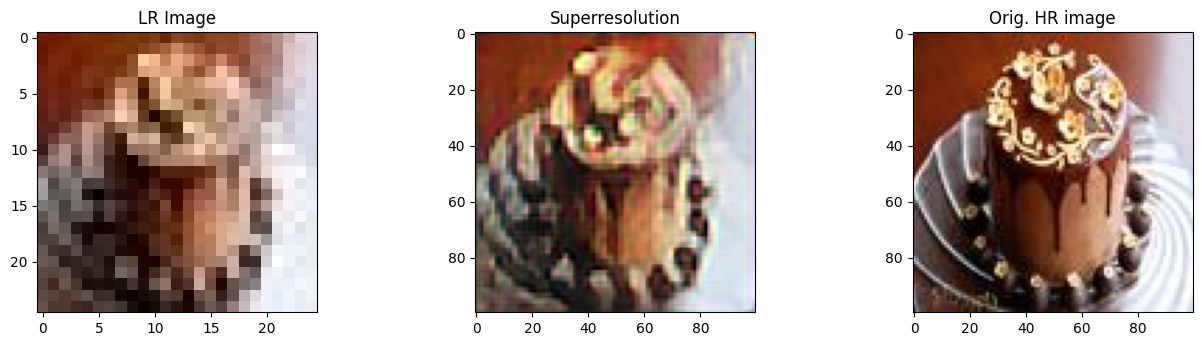

1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


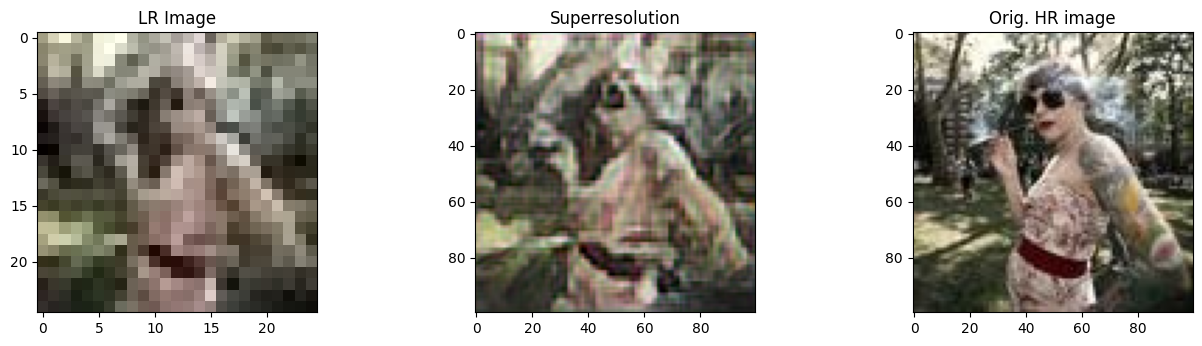

In [22]:
from keras.models import load_model

generator_model = load_model('Generator30.h5', compile=False)
plot_images("data/lr_images/im3.jpg", "data/hr_images/im3.jpg", generator_model)
plot_images("data/lr_images/im1.jpg", "data/hr_images/im1.jpg", generator_model)

In [23]:

lr_test_image = plt.imread("data/lr_images/im4.jpg")
hr_test_image = plt.imread("data/hr_images/im4.jpg")

lr_test_image = lr_test_image / 255
hr_test_image = hr_test_image / 255
    
lr_test_image = np.expand_dims(lr_test_image, axis=0)
hr_test_image = np.expand_dims(hr_test_image, axis=0)

generated_hr = generator_model.predict(lr_test_image)
print(generated_hr.shape, hr_test_image.shape)

1/1 [==============================] - 0s 55ms/step
(1, 100, 100, 3) (1, 100, 100, 3)


### Calculating the PSNR for the generated images and original images

In [24]:
def calculate_psnr(img1, img2, max_value=255):

    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))


In [25]:
from skimage.metrics import structural_similarity as compare_ssim

im1 = np.squeeze(generated_hr)
im2 = np.squeeze(hr_test_image)

score = compare_ssim(im1, im2, multichannel=True)
print("SSIM: {}".format(score))
print("PSNR: {}".format(calculate_psnr(hr_test_image, generated_hr)))

SSIM: 0.7083715796470642
PSNR: 64.20060792356493


/var/folders/wt/28w689qd0jlgv8wtl7h843k00000gn/T/ipykernel_9912/3923250736.py:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  score = compare_ssim(im1, im2, multichannel=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


From the paper, the resulted PSNR was provided as 26.92, SSIM was given at 0.7611 but the model was trained on 350 thousand images, where as the above program was trained for 20 epochs on 3000 images. The obtained mean of PSNR is 64 and SSIM was 0.699.